In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr

from sklearn.metrics import accuracy_score

import logging

import sys
import os

from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D
import math
import json
from scipy import stats


In [3]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [4]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))
        

    

In [19]:
def create_rsi_data(df):
    period = 7

    # Convert the price data to a Pandas DataFrame

    # Calculate daily price changes
    df['Price Change'] = df['Close'].diff()

    # Calculate gains (positive changes) and losses (negative changes)
    df['Gain'] = df['Price Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)

    # Calculate average gains and losses over the specified period
    average_gain = df['Gain'][:period].mean()
    average_loss = df['Loss'][:period].mean()

    # Initialize lists to store RSI values
    rsi_values = []

    epsilon = 1e-10

    # Calculate RSI for the first period
    rs = (average_gain + epsilon) / (average_loss + epsilon)
    rsi = 100 - (100 / (1 + rs))
    rsi_values.append(rsi)

    # Calculate RSI for the remaining data points using a rolling window
    for i in range(period, len(df)):
        average_gain = ((period - 1) * average_gain + df['Gain'].iloc[i]) / period
        average_loss = ((period - 1) * average_loss + df['Loss'].iloc[i]) / period
        
        # Avoid division by zero by adding a small epsilon value
        
        # Calculate Relative Strength (RS)
        rs = (average_gain + epsilon) / (average_loss + epsilon)
        
        # Calculate RSI
        rsi = 100 - (100 / (1 + rs))
        
        rsi_values.append(rsi)

    # Add RSI values to the DataFrame
    df['RSI'] = [None] * (period - 1) + rsi_values
    return df

In [6]:
def create_stochastic_oscillator_data(df):
    stochastic_period = 14  # Main %K period (e.g., 14 days)
    stochastic_d_period = 3  # %D period (e.g., 3 days)

    # Calculate the Lowest Low and Highest High in the specified period
    df['Lowest_Low'] = df['Low'].rolling(stochastic_period).min()
    df['Highest_High'] = df['High'].rolling(stochastic_period).max()

    # Calculate Raw %K
    df['Raw_%K'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100

    # Calculate Smoothed %K (using a simple moving average)
    df['%K'] = df['Raw_%K'].rolling(stochastic_period).mean()

    # Calculate Smoothed %D (using a simple moving average)
    df['%D'] = df['%K'].rolling(stochastic_d_period).mean()

    # Calculate the Stochastic Oscillator difference %K - %D
    df['Stochastic Difference'] = df['%K'] - df['%D']

    return df
    

In [7]:
def create_macd_data(df):
    short_term_period = 12  # Short-term EMA period
    long_term_period = 26   # Long-term EMA period
    signal_period = 9       # Signal line EMA period

    # Calculate the short-term EMA
    df['Short_EMA'] = df['Close'].ewm(span=short_term_period, adjust=False).mean()

    # Calculate the long-term EMA
    df['Long_EMA'] = df['Close'].ewm(span=long_term_period, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['Short_EMA'] - df['Long_EMA']

    # Calculate the signal line (EMA of MACD)
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

    # Calculate the MACD histogram as the difference between MACD and Signal Line
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    return df

In [16]:
def create_cci_data(df):
    cci_period = 14  # CCI period (e.g., 14 days)

    # Calculate Typical Price (TP)
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Calculate Simple Moving Average (SMA) of Typical Prices
    df['SMA_TP'] = df['TP'].rolling(cci_period).mean()

    # Calculate Mean Deviation (MD)
    def mean_deviation(tp_values):
        return np.abs((tp_values - tp_values.mean())).mean()

    df['MD'] = df['TP'].rolling(cci_period).apply(mean_deviation, raw=True)

    # Calculate CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MD'])

    return df




In [9]:
def create_adx_data(df):

    adx_period = 14

    df['TR'] = df.apply(
        lambda row: max(
            row['High'] - row['Low'],
            abs(row['High'] - row['Close']),
            abs(row['Low'] - row['Close'])
        ),
        axis=1
    )   

    # Calculate Plus Directional Movement (+DM) and Minus Directional Movement (-DM)
    df['+DM'] = df['High'].diff()
    df['-DM'] = -df['Low'].diff()

    # Ensure that negative differences are set to zero for +DM and -DM
    df['+DM'] = df['+DM'].apply(lambda x: x if x > 0 else 0)
    df['-DM'] = df['-DM'].apply(lambda x: x if x > 0 else 0)

    # Calculate the Directional Indicators (+DI and -DI)
    df['+DI'] = (df['+DM'].rolling(adx_period).sum() / df['TR'].rolling(adx_period).sum()) * 100
    df['-DI'] = (df['-DM'].rolling(adx_period).sum() / df['TR'].rolling(adx_period).sum()) * 100

    # Calculate the Directional Movement Index (DX)
    df['DX'] = (abs(df['+DI'] - df['-DI']) / abs(df['+DI'] + df['-DI'])) * 100

    # Calculate the Average Directional Index (ADX)
    df['ADX'] = df['DX'].rolling(adx_period).mean()

    return df



In [10]:
def create_obv_data(df):

    obv_lookback = 10

    df['OBV'] = (df['Close'].diff() > 0).astype(int) * df['Volume'].diff().fillna(0).astype(int)
    df['OBV'] = df['OBV'].cumsum()
    df['OBV'] = df['OBV'].diff(obv_lookback) / obv_lookback

    return  df

In [11]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Close'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Close'].ewm(span=small_window, adjust=False).mean()
    df['MA'] = df['Close'].ewm(span=window, adjust=False).mean()
    df['MA difference'] = df['Close'] - df['SMA']

    df = create_rsi_data(df)
    df = create_stochastic_oscillator_data(df)
    df = create_macd_data(df)
    df = create_cci_data(df)
    df = create_adx_data(df)
    df = create_obv_data(df)
    


    return df








In [240]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dictionary = filter_data(ticker_list, start_date, end_date)

    ticker_dict = {}

    for ticker in ticker_dictionary.keys():
        data = ticker_dictionary.get(ticker)

        if np.mean(data['Open']) > 20:
            ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _, _, _, _, _, _, _ in train_set]
    sma = [sma for _, _, sma, _, _, _, _, _, _ in train_set]
    gain = [gain for gain, _, _, _, _, _, _, _, _ in train_set]

    cci = [cci for _, _, _, _, _, _, cci, _, _ in train_set]

    adx = [cci for _, _, _, _, _, _, _, cci, _ in train_set]

    rsi = [cci for _, _, _, _, _, cci, _, _, _ in train_set]

    macd = [cci for _, _, _, _, cci, _, _, _, _ in train_set]

    stoch = [cci for _, _, _,cci, _, _, _, _, _ in train_set] 

    obv = [cci for _, _, _, _, _, _, _, _, cci in train_set]

    df = pd.DataFrame(train_set, columns=['Gain', 'LMAC', 'SMAC', "Stoch", "MACD", "RSI", "CCI", "ADX", "OBV"])

    correlation_coefficients = {}

    indicators = ['LMAC', 'SMAC', "Stoch", "MACD", "RSI", "CCI", "ADX", "OBV"]

    for indicator in indicators:
        correlation_coefficient, _ = stats.pointbiserialr(df[indicator].fillna(0), df['Gain'])
        correlation_coefficients[indicator] = correlation_coefficient

    sorted_indicators = sorted(correlation_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
    print(sorted_indicators)

    

    fig = plt.figure(figsize = (20, 8))
    plt.scatter(sma, obv, c=gain, cmap='bwr', marker='o')

    # Add color bar
    cbar = plt.colorbar()
    cbar.set_label('Binary Value')

    plt.title("Scatter plot of winning (red) and losing (blue) trades based on rate of change in moving averages")
    plt.xlabel("SMAC")
    plt.ylabel("OBV")

    # Show the plot
    plt.show()

    target = [target for target, _, _, _, _, _, _, _, _  in train_set]
    features = [(x,y) for _,x,y, _, _, _, _, _, _  in train_set]

    # print("Valid crossovers:", len(target))
    # print("Successful crossovers:", target.count(1))

    print(gain.count(1))
    print(gain.count(0))
    print(len(gain))

    model = RandomForestClassifier(n_estimators = 20, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .7:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [13]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dictionary = filter_data(ticker_list, start_date, end_date)

    ticker_dict = {}

    for ticker in ticker_dictionary.keys():
        data = ticker_dictionary.get(ticker)

        if np.mean(data['Open']) > 20:
            ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .75:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (correct_signals / trades, target.count(1) / len(target))



In [14]:
window = 200
large_window = 80
small_window = 20


In [53]:


init_start = '2013-09-06'
init_end = '2023-09-27'

start_date = '2020-09-01'
end_date = '2023-09-27'

recent_start = '2022-08-01'
recent_end = '2023-09-27'

long_start = '2018-08-31'
long_end = '2023-09-27'

train_start = '2003-08-31'
train_end = '2013-09-27'

ten_start = '2013-09-27'
ten_end = '2018-09-27'

common_ticks = [
    "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
    "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS",
    "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
    "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
    "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
    "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK",
    "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
    "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
    "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
    "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
    "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
    "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB",
    "BMY", "UL", "PDD", "SPGI", "AMAT", "RY", "HON", "NOW", "GE", "RTX", "QCOM", "IDEXY",
    "FTI", "LUV", "VFS", "ROKU", "DISH", "USB", "SLB", "BUR", "GOLD", "RIG", "BKR", "DAL",
    "KHC", "CLF", "AGNC", "SNOW", "RUN", "GGB", "AEO", "CIG", "ENB", "RF", "NEE", "PTEN", "CVX"
    "VST", "VTRS", "BTE", "CARR", "BRFS", "CLVT", "CVE", "JPM", "PR", "KGC",
    "JNJ", "NYCB", "MDLZ", "MO", "MRK", "XPEV", "JCI", "HPE", "GILD", "TEVA",
    "D", "NEM", "EQT", "NKE", "IQ", "WU", "OXY", "BCS", "FCX", "ROL", "FHN", "HST", "U", "BTG", "CNHI", "MS",
    "WMB", "FITB", "AES", "RTX", "KIM", "CVNA", "HPQ", "X", "WRK", "FNMA", "TSM", "FTNT", "AMCR", "INFY"
    "BA", "BROS", "COIN", "CTRA", "FSR", "DELL", "DIDIY", "STLA", "CVS", "BK", "JD", "COTY",
    "KDP", "SBSW", "TME", "TOST", "PSNY", "ATVI", "NWL", "CHWY", "SE", "BEKE", "PPL", "NOV", "VFC", "ZI", "VLO"
    "SBRA", "DVN", "CNQ", "BB", "ADBE", "ORCL", "IBM", "CRM", "INTC", "CSCO", "AMD", "SAP",
    "QCOM", "AVGO", 'CVX', "HD", "LLY", "PG", "WMT", "LVMUY", "JPM", "XOM", "JNJ", "UNH", "BRK-A", "BRK-B",
    "GM", "MA", "NESN.SW", "MRK", "ABBV", "KO", "PEP", "COST", "SHEL", "MCD", "DIS", "NKE",
    "CAT", "LOW", "UNP", "GE"
]

ticks = []

with open('nyse_tickers.txt', 'r') as file:
    for line in file:
        line = line.strip()
            
            # Check if the line is not empty
        if line:
            # Append the non-empty line (ticker) to the list
            ticks.append(line)

common_ticks = list(set(ticks))[:2000]

common_ticks = ["TSLA", "NFLX", "MSFT", "AMZN", "APPL", "GOOG", "META", "WAL", "SBUX", "NKE", "CSCO", "INTC", "IBM"
                "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
                "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS"
                "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
                "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
                "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
                "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK"]
# ]
#             #     "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
            #     "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
            #     "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
            #     "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
            #     "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
            #     "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB",
            #     "BMY", "UL", "PDD", "SPGI", "AMAT", "RY", "HON", "NOW", "GE", "RTX", "QCOM", "IDEXY"
            # ]

common_ticks = list(set(common_ticks))
                


common_init = create_train_set(common_ticks, init_start, init_end, large_window, small_window, window)
common_mid = create_train_set(common_ticks, start_date, end_date, large_window, small_window, window)
common_short = create_train_set(common_ticks, recent_start, recent_end, large_window, small_window, window)
common_long = create_train_set(common_ticks, train_start, train_end, large_window, small_window, window)
common_decade = create_train_set(common_ticks, long_start, long_end, large_window, small_window, window)
common_tens = create_train_set(common_ticks, ten_start, ten_end, large_window, small_window, window)

In [294]:


def get_crossover_data(dataset, window):
    train_data = []
    just_bought = -20
    for i in range(20, len(dataset) - 25):
        # if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
        if (dataset['Stochastic Difference'][i]) < 0:
            lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
            sma_change = np.abs((dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10)
            ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

            future = list(dataset['High'][i+2:i+20])
            gain = 1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else 0

            # gain = None

            # for n in range(i+2,i+20):
            #     if dataset['High'][n] > 1.07 * dataset['Open'][i + 1]:
            #         gain = 1
            #         break
            #     if dataset['Low'][n] < .93 * dataset['Open'][i + 1]:
            #         gain = 0
            #         break

            # if gain is None:
            #     gain = .5
            
            





            stoch_diff = dataset['Stochastic Difference'][i]
            macd = dataset['MACD_Histogram'][i]
            rsi = dataset['RSI'][i]
            cci = dataset['CCI'][i]
            adx = dataset['ADX'][i]
            obv = dataset['OBV'][i]
            if (sma_change) > .015 and i > just_bought + 20:
                just_bought = i
                train_data.append((gain, lma_change, sma_change, stoch_diff, macd, rsi, cci, adx, obv))
    return train_data

1636
1816
1881
2398
2436
2491
1631
1700
1860
1888
1909
2438
120
1551
1600
1621
1643
1673
1723
1760
1828
1849
2056
2343
2374
2456
212
391
762
818
241
396
471
551
1646
1639
447
500
612
690
891
912
933
968
1009
1076
1111
1132
1216
1331
1376
1416
1449
1564
1639
1682
1703
1748
1772
1798
1827
1849
1878
1909
1934
2049
2086
2107
2174
2195
2218
2245
2318
2339
2365
2421
2477
1639
1645
38
66
125
226
381
407
521
929
1686
1749
2329
240
421
784
847
965
986
1217
1247
1707
1747
1942
1644
34
55
76
105
277
410
582
634
692
937
985
1119
1228
1276
1634
1663
1701
1821
1882
2211
2289
2464
413
1106
2112
2173
1314
2058
2369
2449
1647
1854
1888
1909
2364
301
499
761
797
924
1177
1235
1317
1364
50
110
218
41
281
323
440
462
485
579
846
912
977
1042
1099
63
128
200
387
461
509
530
716
737
47
82
123
281
338
424
2125
2308
2370
569
1642
857
1645
84
169
199
253
277
332
360
394
415
487
516
548
596
285
640
732
827
1255
1301
1744
2449
1639
1633
1654
1702
1831
1639
[('Stoch', 0.11584671865792213), ('ADX', -0.095840542660

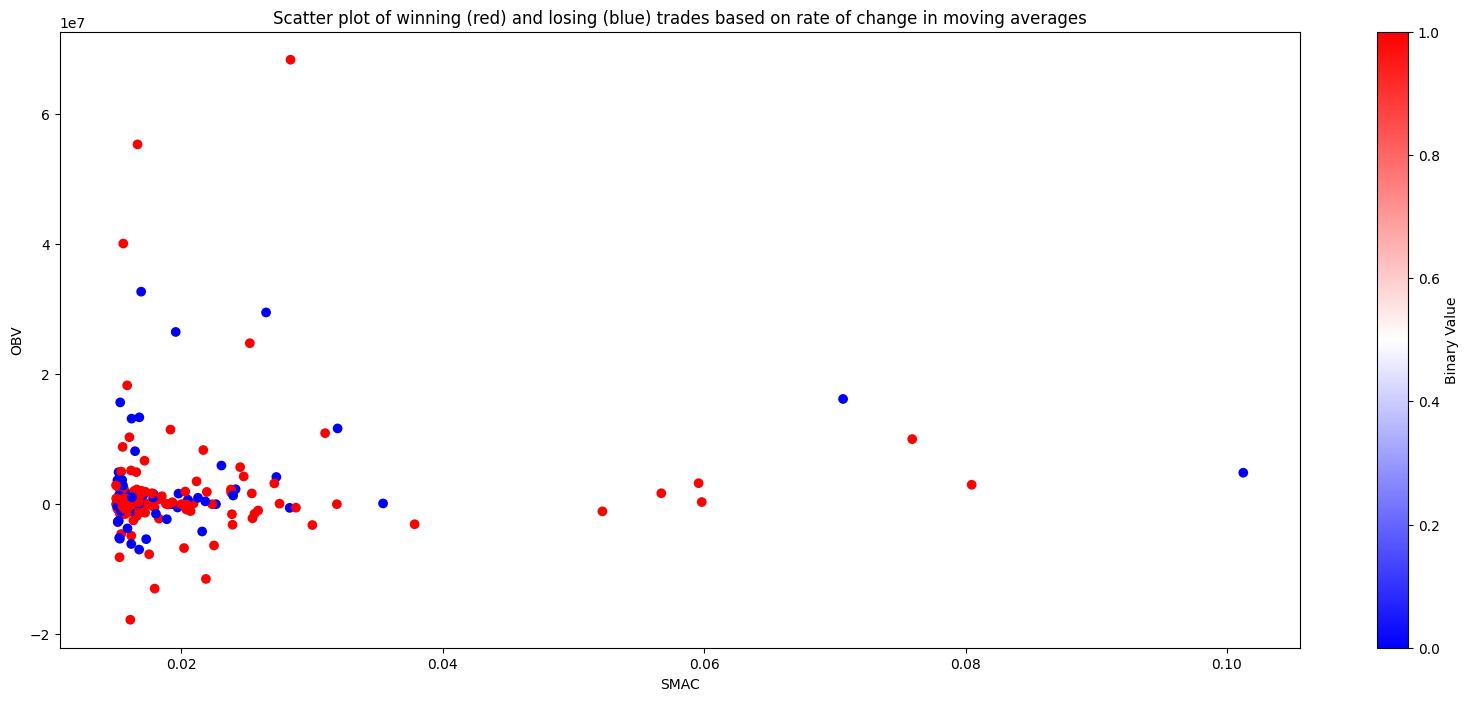

142
68
210
Amount of trades 83
Amount of successful trades 78
Accuracy: 0.7380952380952381


In [295]:

model = train_model(common_init, large_window, small_window, window)

In [ ]:
test_model(common_decade, large_window, small_window, window, model)

Valid crossovers: 1438
Successful crossovers: 909
Predicted successful crossovers: 1433
Amount of trades 205
Amount of successful trades 150
Accuracy: 0.6300417246175244


(0.7317073170731707, 0.6321279554937413)

811
Buy signal: TLRY on 2018-11-01 00:00:00
Change in asset
TLRY bought on 2018-11-02 00:00:00: 99.290
Buy signal: AMD on 2018-11-05 00:00:00
Change in asset
AMD bought on 2018-11-06 00:00:00: 19.500
Sell signal: AMD on 2018-11-06 00:00:00
AMD sold on 2018-11-07 00:00:00: 21.450, move: 0.100
Sell signal: TLRY on 2018-11-07 00:00:00
TLRY sold on 2018-11-08 00:00:00: 109.219, move: 0.100
Buy signal: NVDA on 2018-11-23 00:00:00
Change in asset
NVDA bought on 2018-11-26 00:00:00: 37.472
Sell signal: NVDA on 2018-12-03 00:00:00
NVDA sold on 2018-12-04 00:00:00: 41.220, move: 0.100
Buy signal: TLRY on 2018-12-18 00:00:00
Change in asset
TLRY bought on 2018-12-19 00:00:00: 82.390
Sell signal: TLRY on 2019-01-11 00:00:00
TLRY sold on 2019-01-14 00:00:00: 90.629, move: 0.100
Buy signal: SNAP on 2019-02-26 00:00:00
Change in asset
SNAP bought on 2019-02-27 00:00:00: 10.080
Sell signal: SNAP on 2019-03-14 00:00:00
SNAP sold on 2019-03-15 00:00:00: 11.088, move: 0.100
Buy signal: TLRY on 2019-08-2

2.425

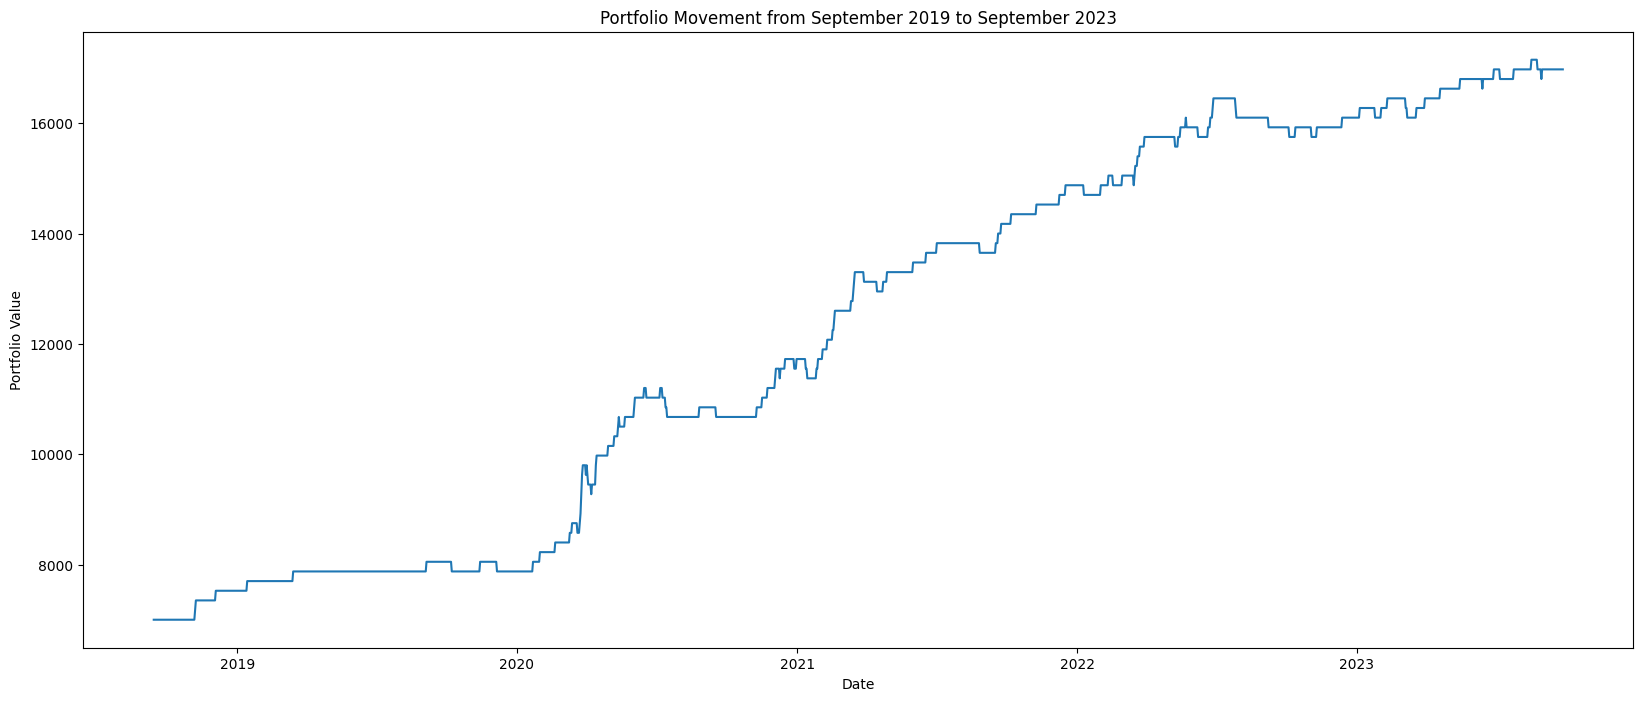

In [299]:

def get_signal_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset) - 1):
            if dataset['Stochastic Difference'][i] < 0:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = np.abs((dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10)
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                
                stoch_diff = dataset['Stochastic Difference'][i]
                macd = dataset['MACD_Histogram'][i]
                rsi = dataset['RSI'][i]
                cci = dataset['CCI'][i]
                adx = dataset['ADX'][i]
                obv = dataset['OBV'][i]
                if (sma_change) > .015:
                    date = dataset['Date'][i]
                    trade_data.append((date, ticker))
    print(len(trade_data))
    return trade_data

def create_trade_signals(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_signal_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Ticker'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2018-09-14", end= "2023-09-27")
    date_list = date_range.tolist()

    # positions = []

    wins = []
    loss = []


    to_buy = []
    positions = []
    to_sell = []

    loss = []
    wins = []

    dates = []
    portfolio = []

    buys = []

    prev_sell_ticker = ""
    prev_sell_move = 0

    prev_buy_ticker = []

    for i in date_list:
        # Buy positions the next day

        for asset in to_buy:
            asset_df = ticker_dict[asset[0]]
            index = list(asset_df['Date']).index(asset[1])
            if(i == (asset_df['Date'][index + 1])):
                print("{} bought on {}: {:.3f}".format(asset[0], i, asset_df['Open'][index + 1]))
                capital -= trade_amount * .05
                positions.append([asset[0], asset_df['Open'][index + 1], 20])
                to_buy.remove(asset)




        # Sell positions

        for asset in to_sell:
            asset_df = ticker_dict[asset[0][0]]
            if i == asset_df['Date'][asset[1]]:

                buy_price = asset[0][1]

                if asset[2] == 1:
                    sell_price = buy_price * (1.1)
                    capital += trade_amount * (sell_price / buy_price - 1)
                # elif asset[2] == 3:
                #     sell_price = buy_price * .93
                else:
                    # sell_price = asset_df['Open'][asset[1]]
                    sell_price = buy_price * .95
            
                print("{} sold on {}: {:.3f}, move: {:.3f}".format(asset[0][0], i, sell_price, sell_price / buy_price - 1))
                to_sell.remove(asset)
                positions.remove(asset[0])
                prev_sell_ticker = asset[0][0]
                move = sell_price / buy_price - 1
                prev_sell_move = move
                prev_buy_ticker.remove(asset[0][0])
                if move < 0:
                    loss.append(move)
                if move > 0:
                    wins.append(move)
                


        # Mark position for selling

        for asset in positions:
            asset_df = ticker_dict[asset[0]]
            if i in asset_df['Date']:
                index = list(asset_df['Date']).index(i)
                asset[2]-= 1
                if asset_df['High'][index] > asset[1] * 1.1:
                    to_sell.append([asset, index + 1, 1])
                    print("Sell signal: {} on {}".format(asset[0], i))
                elif asset[2] == 0:
                    to_sell.append([asset, index + 1, 2])
                    print("Hold limit reached for {}".format(asset[0]))
                # elif asset_df['Low'][index] < asset[1] * .93:
                #     to_sell.append([asset, index + 1, 3])
                #     print("Stop loss triggered for {}".format(asset[0]))
                






        # Create buy signal
        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i:
                buys.append([sorted_df['Date'][n], sorted_df['Ticker'][n]])

            if sorted_df['Date'][n] == i and capital > trade_amount * .05:
                # capital -= trade_amount
                
                # if sorted_df['Ticker'][n] == prev_sell_ticker and prev_sell_move > 0:
                #     print("Buy signal: {} on {}".format(sorted_df['Ticker'][n], sorted_df['Date'][n]))
                #     print("Same asset")
                #     to_buy.append((sorted_df['Ticker'][n], sorted_df['Date'][n]))
                if sorted_df['Ticker'][n] not in prev_buy_ticker:
                    print("Buy signal: {} on {}".format(sorted_df['Ticker'][n], sorted_df['Date'][n]))
                    print("Change in asset")
                    to_buy.append((sorted_df['Ticker'][n], sorted_df['Date'][n]))

                    prev_buy_ticker.append(sorted_df['Ticker'][n])

                # positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

        portfolio.append((capital + len(positions) * trade_amount * .05))
        dates.append(i)

    print((capital + len(positions) * trade_amount) / initial_capital)
    print(len(wins))
    print(len(loss))
    print(np.mean(wins))
    print(np.mean(loss))
    plt.figure(figsize = (20, 8))
    plt.plot(dates, portfolio)
    plt.title("Portfolio Movement from September 2019 to September 2023")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")

    return (capital + len(positions) * trade_amount) / initial_capital

create_trade_signals(common_decade, window, 7000, 3500, model)

Amount of trades 133
Amount of successful trades 121
Accuracy: 0.7748917748917749
Buy signal: TME on 2022-11-25 00:00:00
TME bought on 2022-11-28 00:00:00: 5.710
Sell signal: TME on 2022-11-28 00:00:00
TME sold on 2022-11-29 00:00:00: 5.996, move: 0.050
Buy signal: YMM on 2022-12-08 00:00:00
YMM bought on 2022-12-09 00:00:00: 8.750
Stop loss triggered for YMM
YMM sold on 2022-12-13 00:00:00: 8.312, move: -0.050
Buy signal: IQ on 2022-12-15 00:00:00
IQ bought on 2022-12-16 00:00:00: 3.710
Sell signal: IQ on 2022-12-16 00:00:00
IQ sold on 2022-12-19 00:00:00: 3.896, move: 0.050
Buy signal: LYFT on 2023-01-26 00:00:00
LYFT bought on 2023-01-27 00:00:00: 15.230
Sell signal: LYFT on 2023-01-27 00:00:00
LYFT sold on 2023-01-30 00:00:00: 15.991, move: 0.050
Buy signal: COIN on 2023-02-09 00:00:00
COIN bought on 2023-02-10 00:00:00: 58.260
Sell signal: COIN on 2023-02-10 00:00:00
COIN sold on 2023-02-13 00:00:00: 61.173, move: 0.050
Buy signal: BUR on 2023-04-13 00:00:00
BUR bought on 2023-04-

C:\Users\sayuj\AppData\Local\Temp\ipykernel_19188\848016294.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20, 8))


2022-11-25 00:00:00: Buy signal for TME
2022-12-08 00:00:00: Buy signal for YMM
2022-12-15 00:00:00: Buy signal for IQ
2023-01-26 00:00:00: Buy signal for LYFT
2023-02-09 00:00:00: Buy signal for COIN
2023-04-13 00:00:00: Buy signal for BUR
2023-05-19 00:00:00: Buy signal for CVNA
2023-05-22 00:00:00: Buy signal for OPEN
2023-06-12 00:00:00: Buy signal for SOFI
2023-07-12 00:00:00: Buy signal for RIVN
2023-08-15 00:00:00: Buy signal for TLRY
Buy signal: EQT on 2020-04-16 00:00:00
EQT bought on 2020-04-17 00:00:00: 13.040
Sell signal: EQT on 2020-04-20 00:00:00
EQT sold on 2020-04-21 00:00:00: 13.692, move: 0.050
Buy signal: BTG on 2020-04-23 00:00:00
Buy signal: SHOP on 2020-04-23 00:00:00
BTG bought on 2020-04-24 00:00:00: 5.340
Stop loss triggered for BTG
BTG sold on 2020-04-27 00:00:00: 5.073, move: -0.050
Buy signal: CVNA on 2020-05-04 00:00:00
CVNA bought on 2020-05-05 00:00:00: 82.000
Sell signal: CVNA on 2020-05-05 00:00:00
CVNA sold on 2020-05-06 00:00:00: 86.100, move: 0.050
B

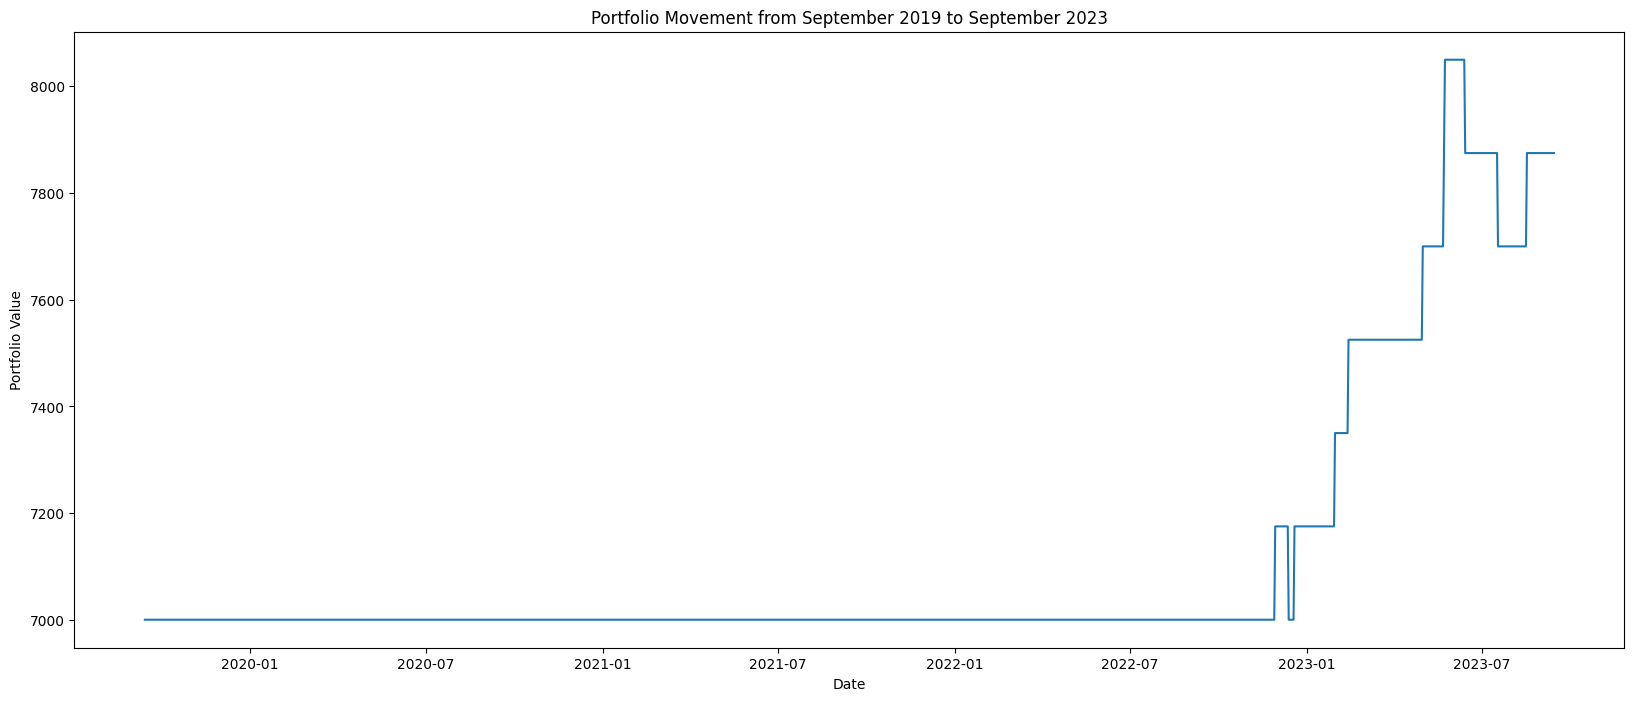

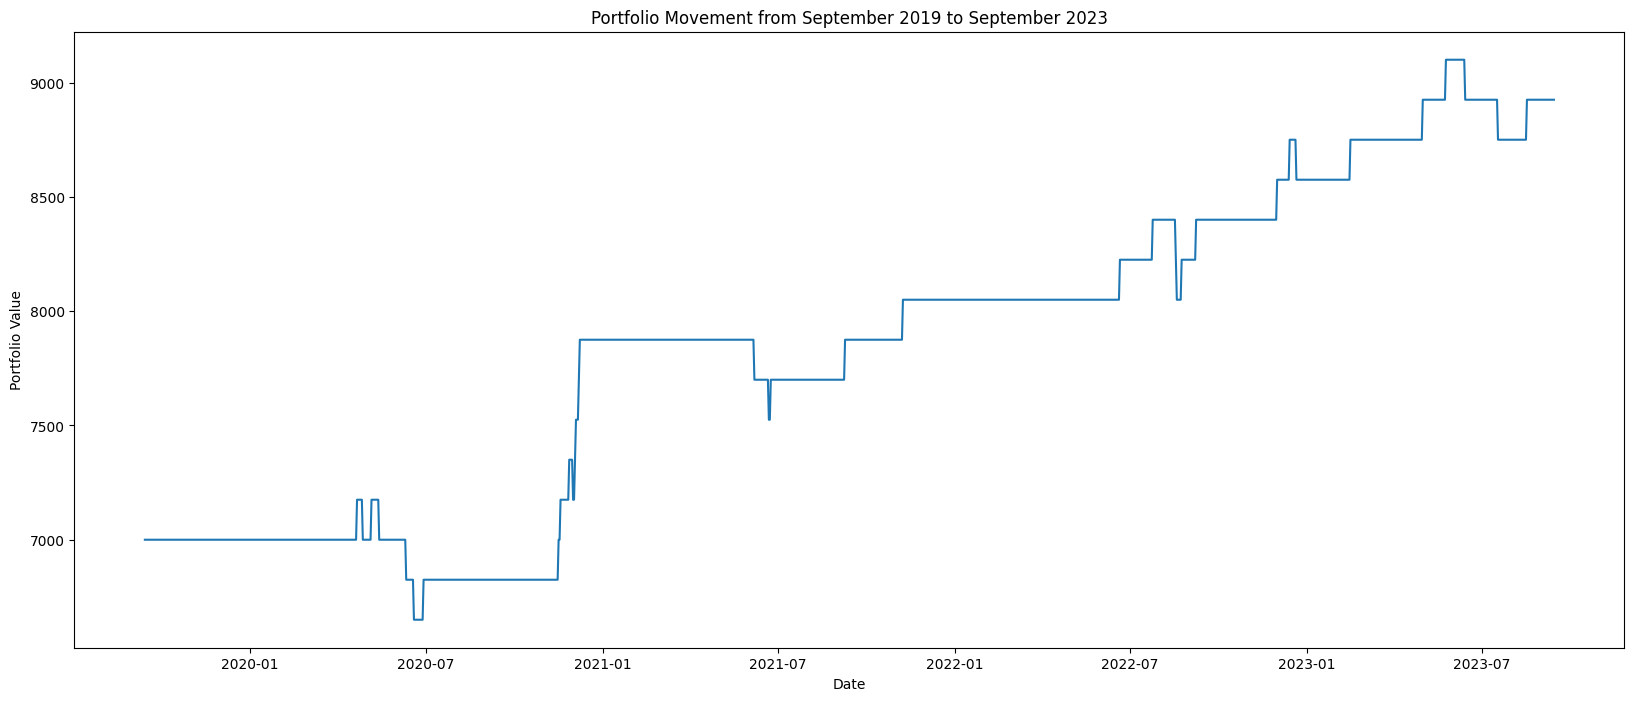

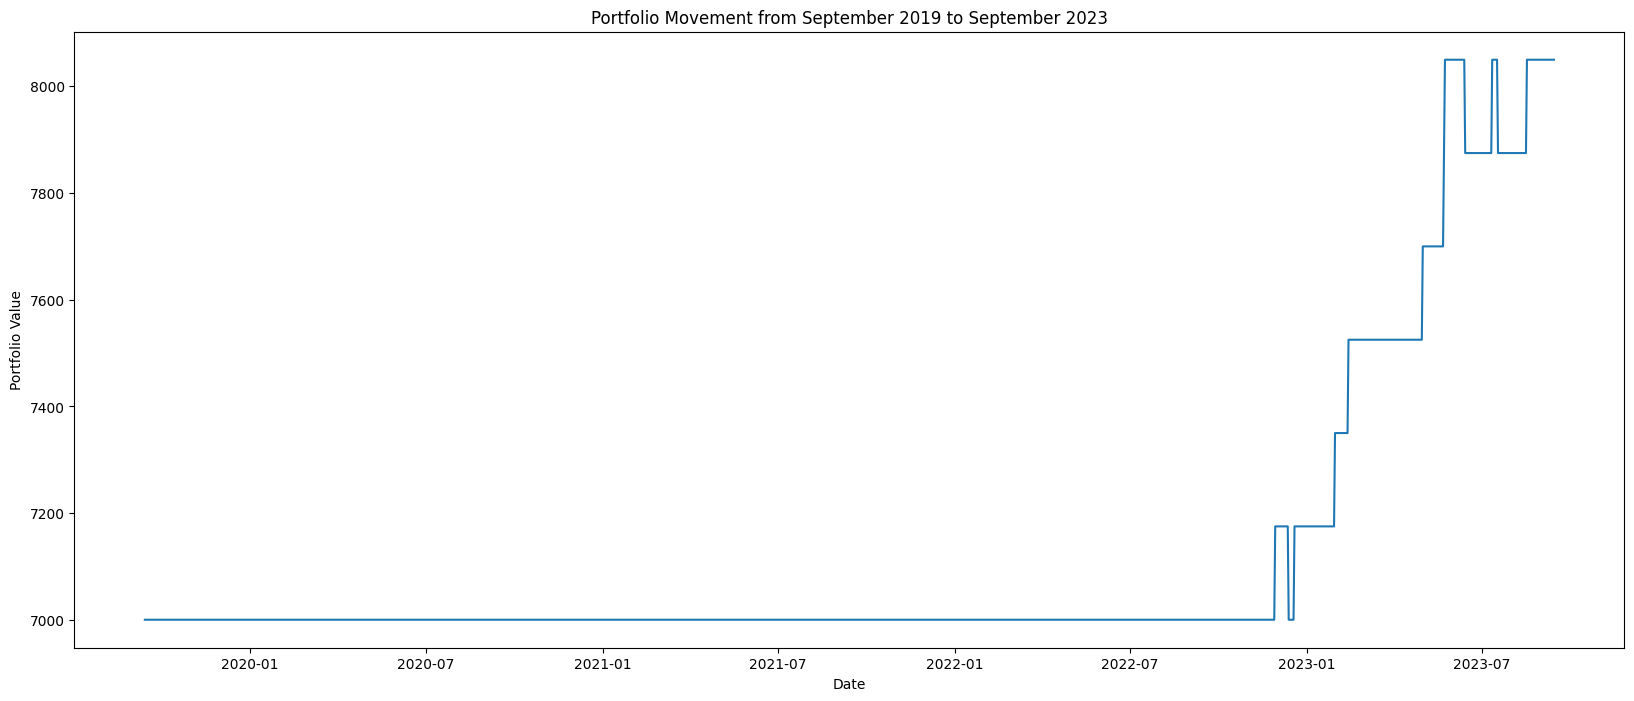

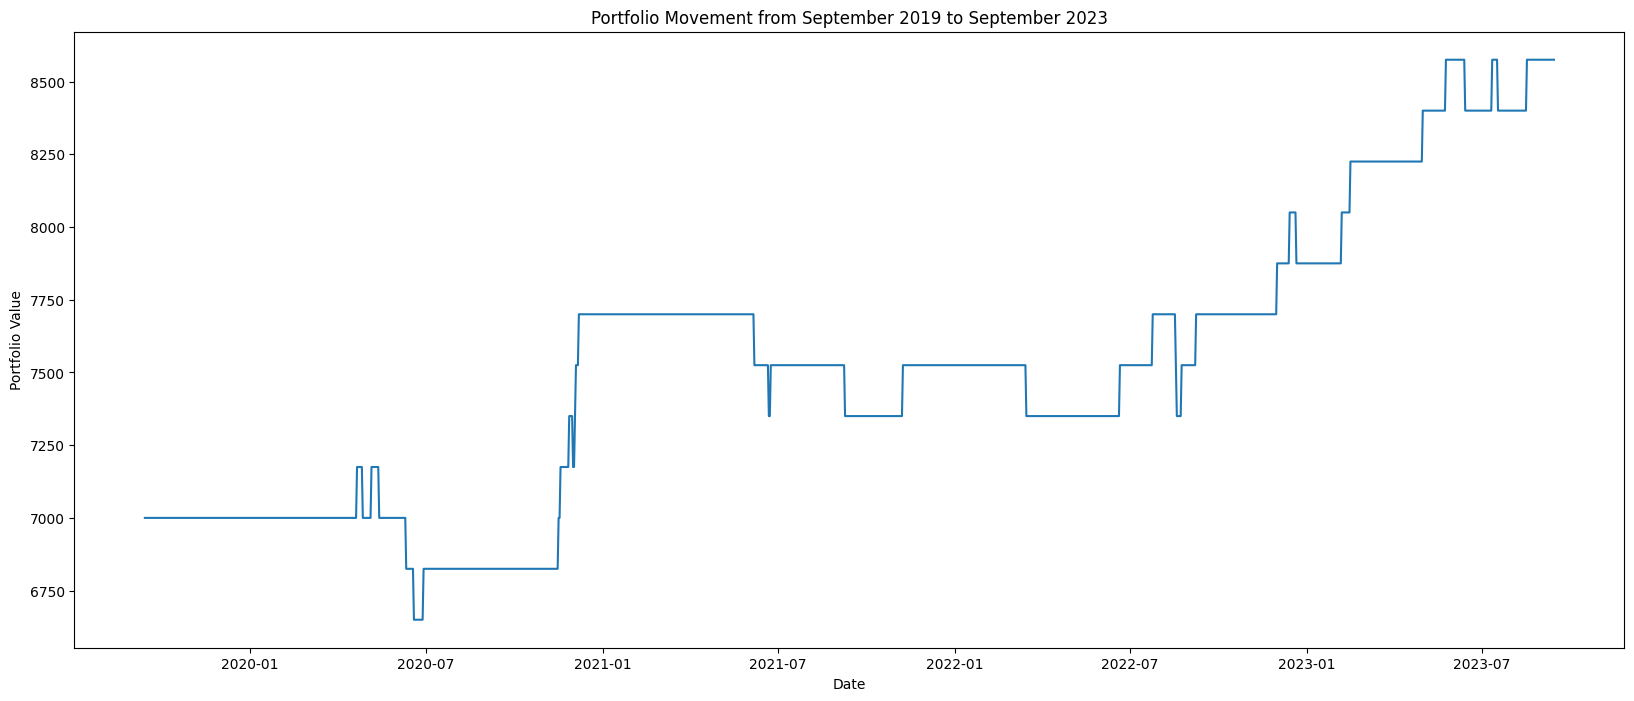

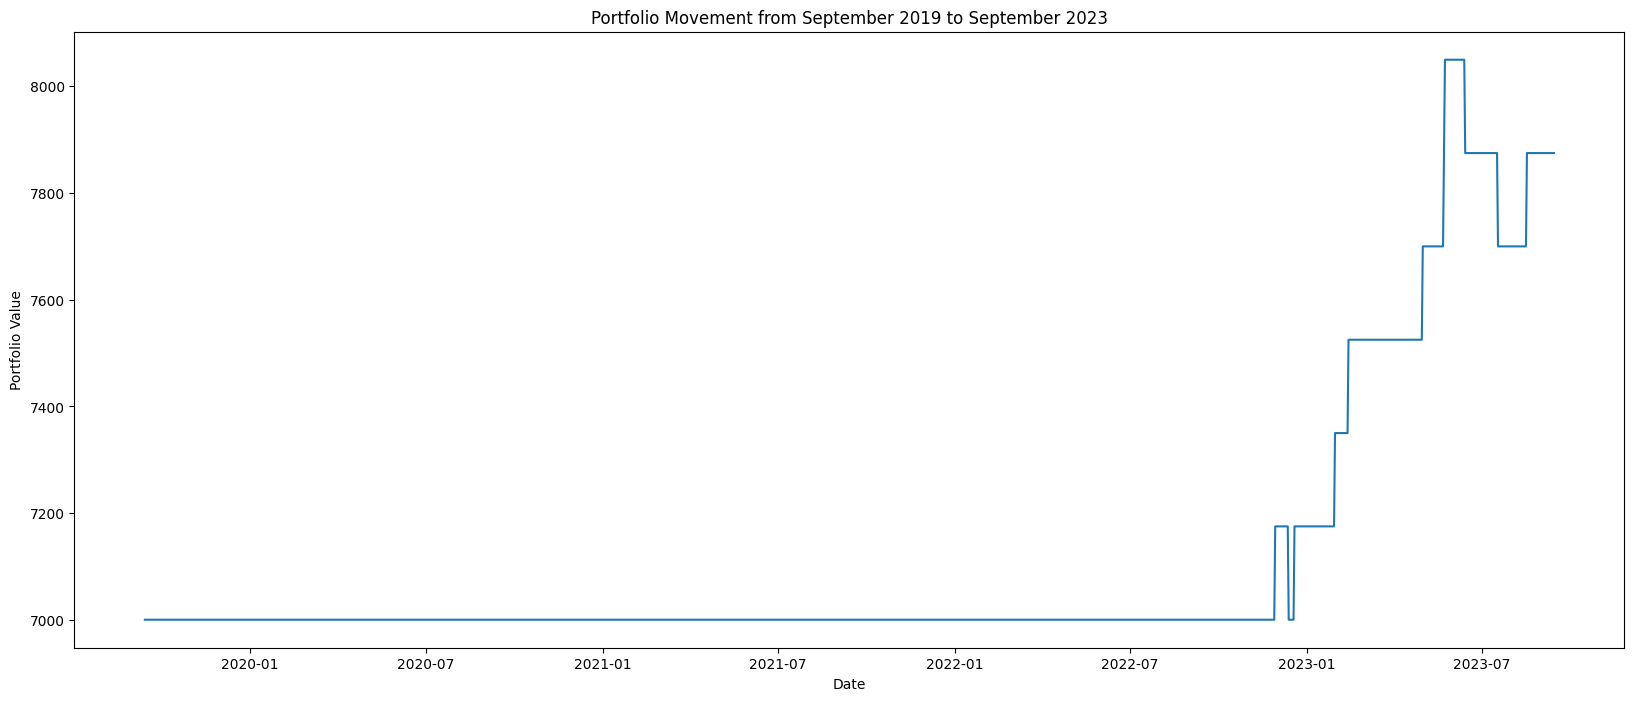

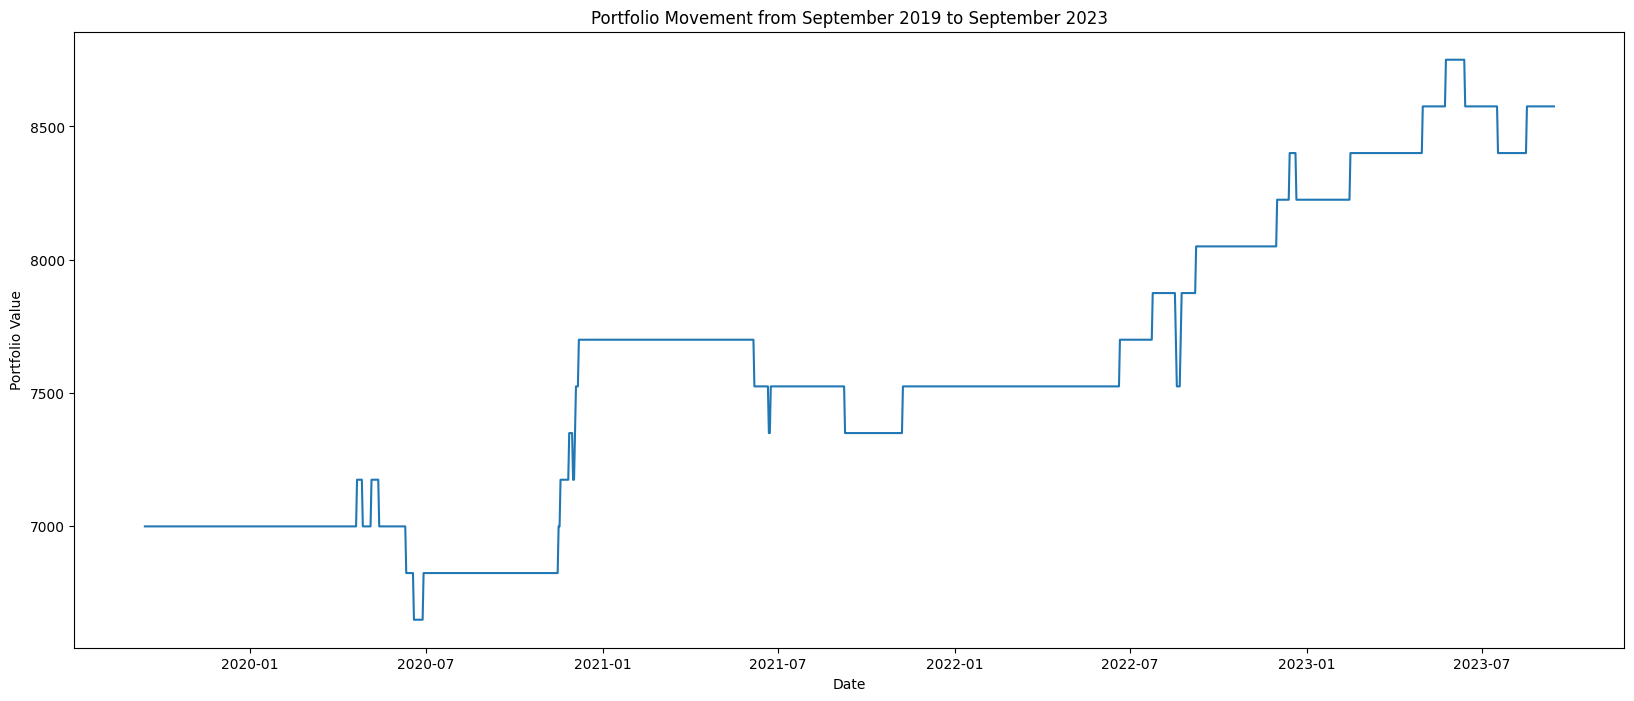

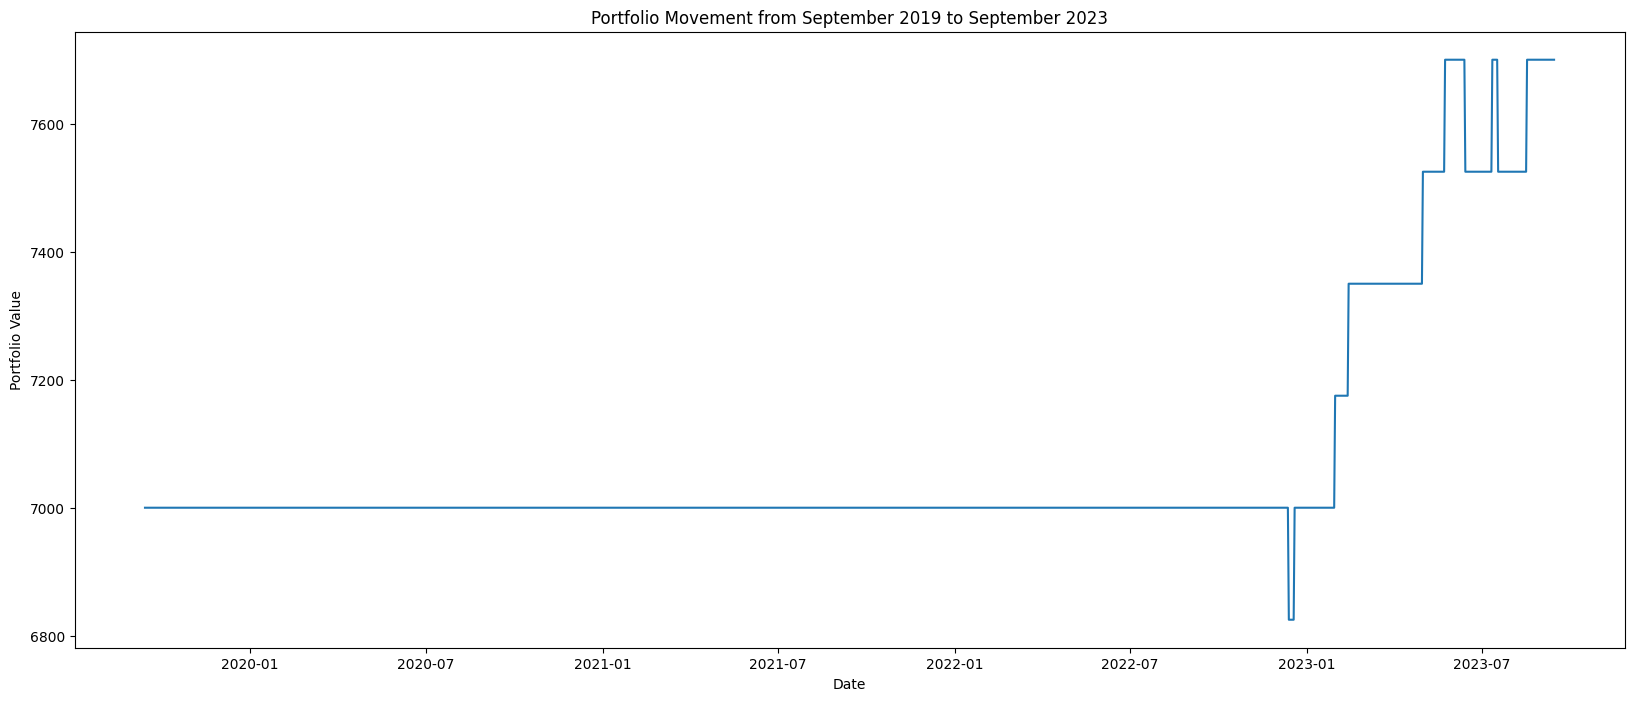

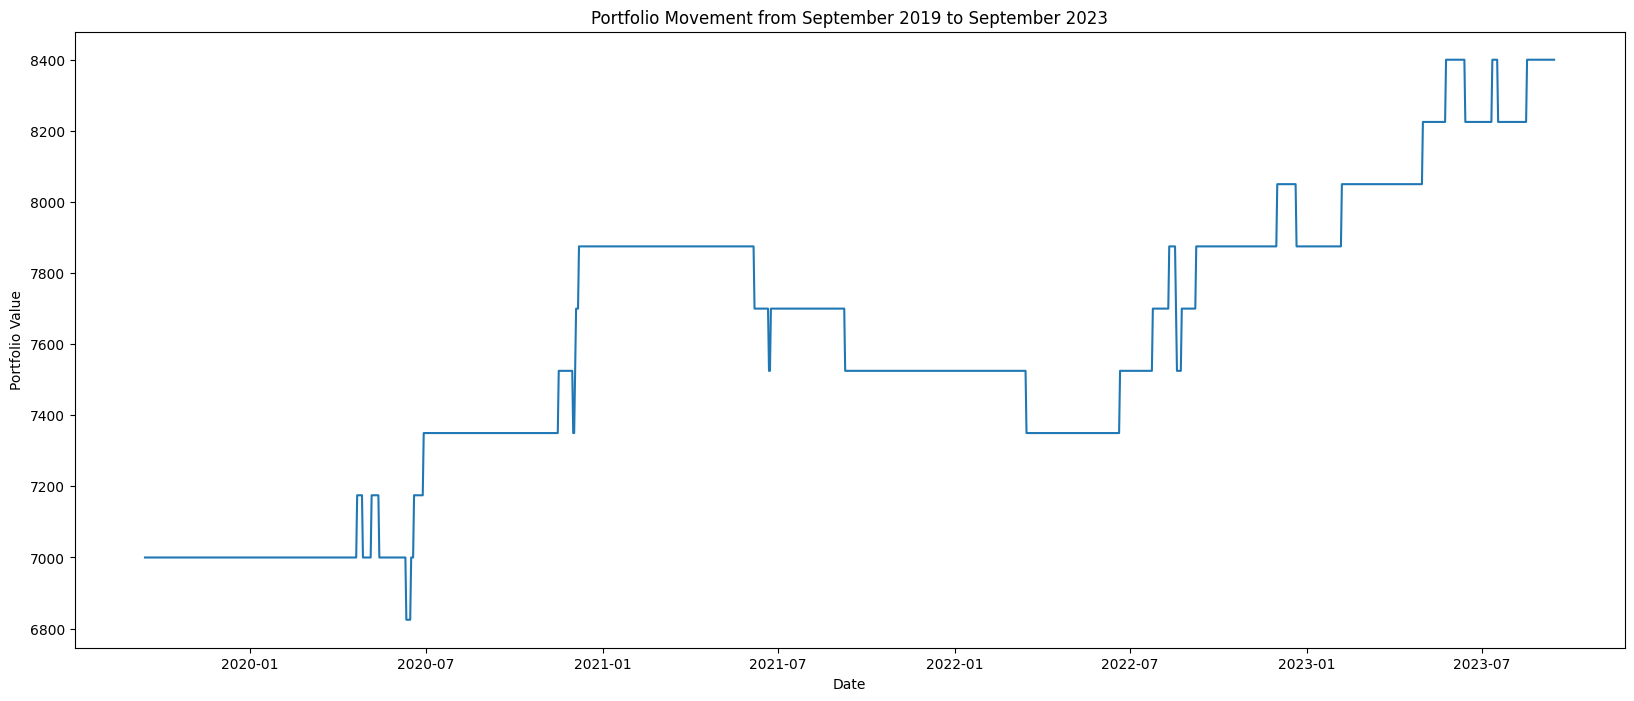

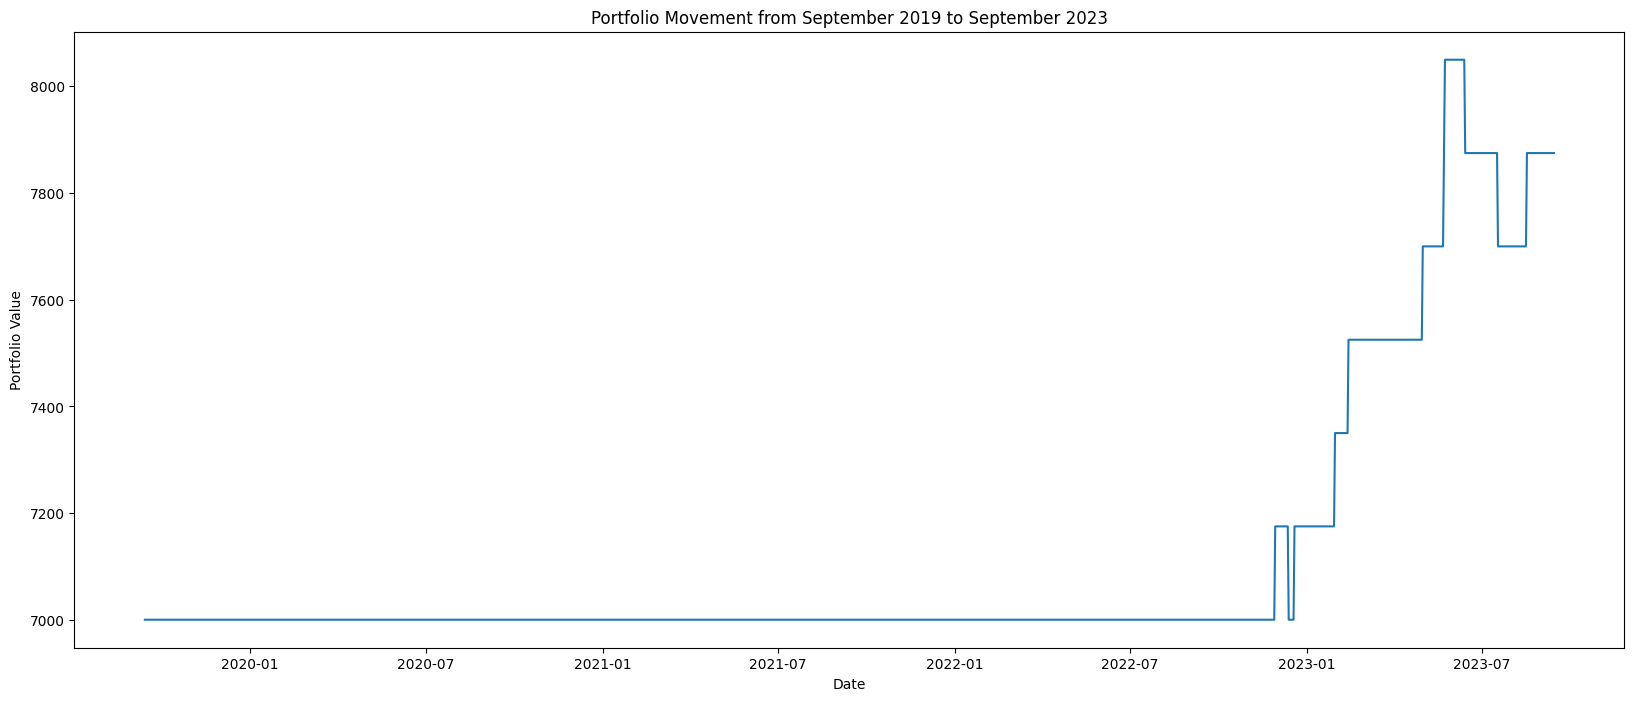

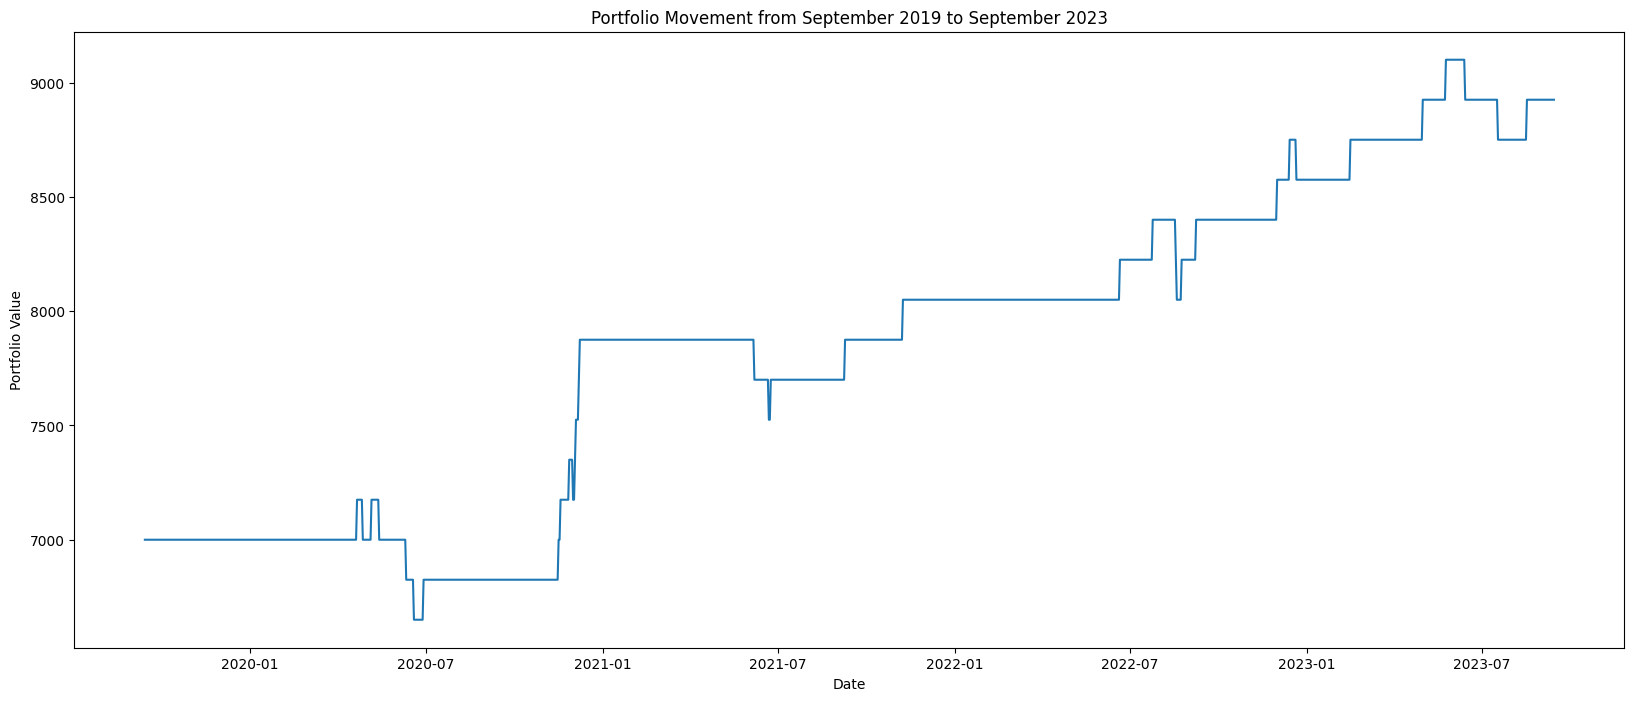

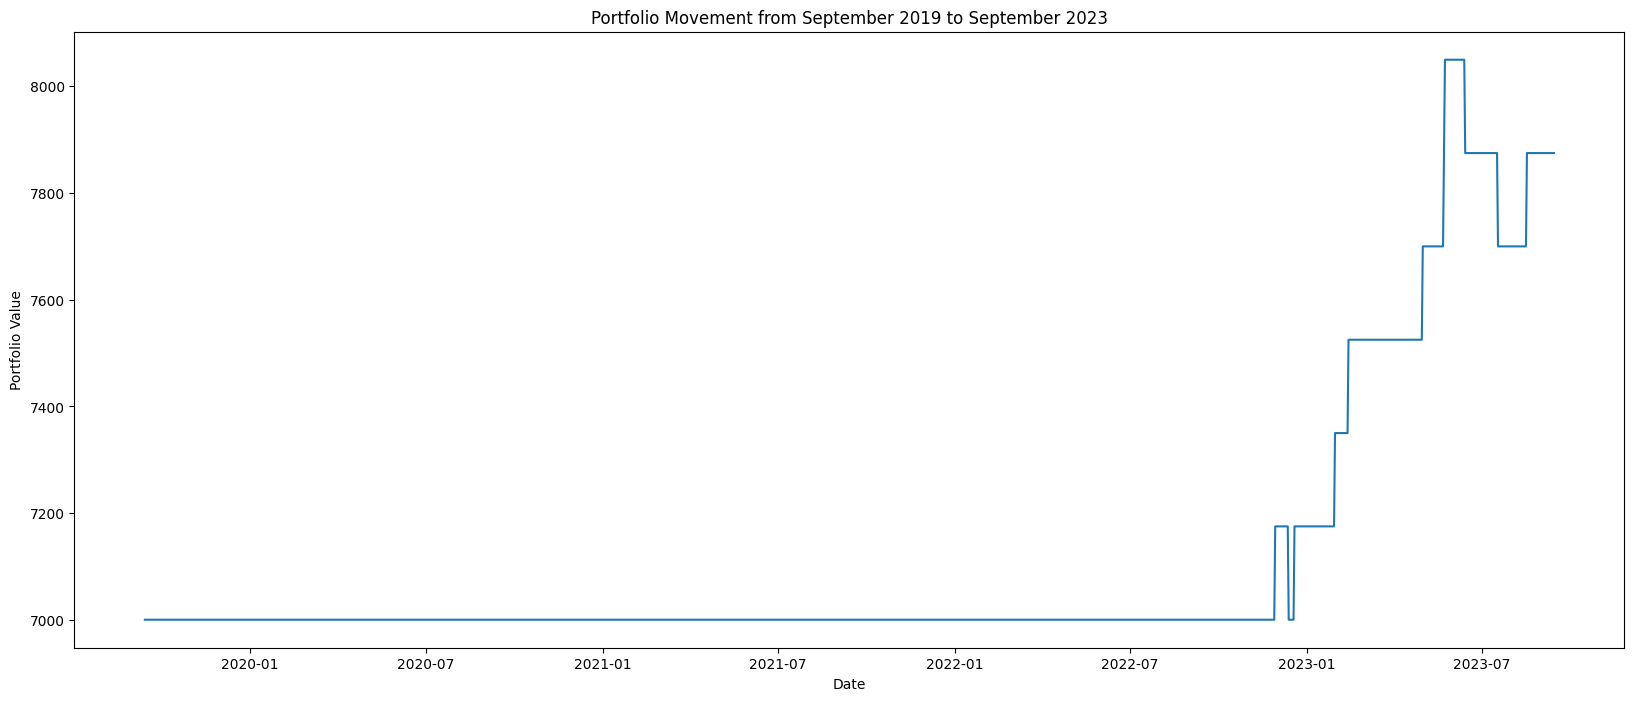

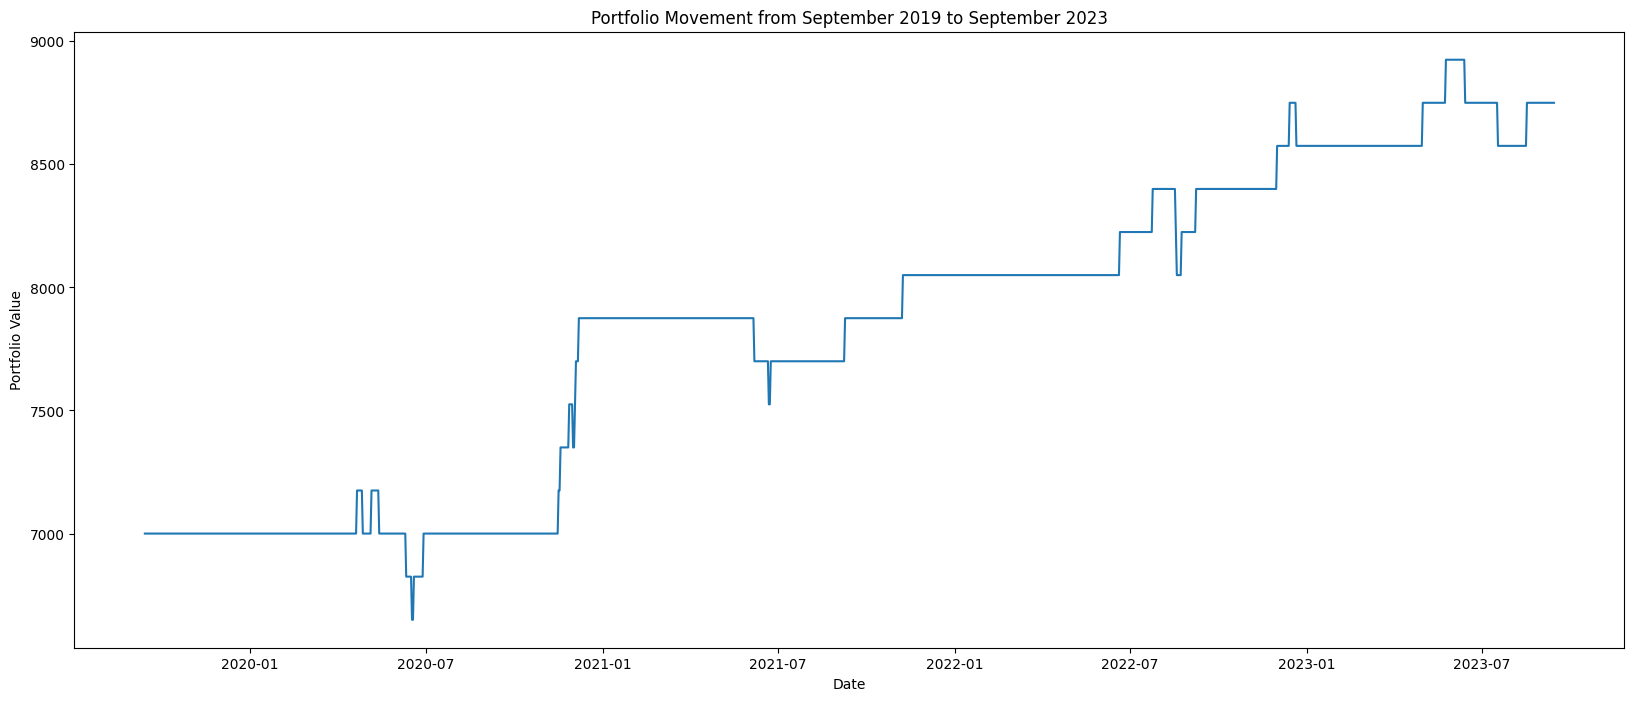

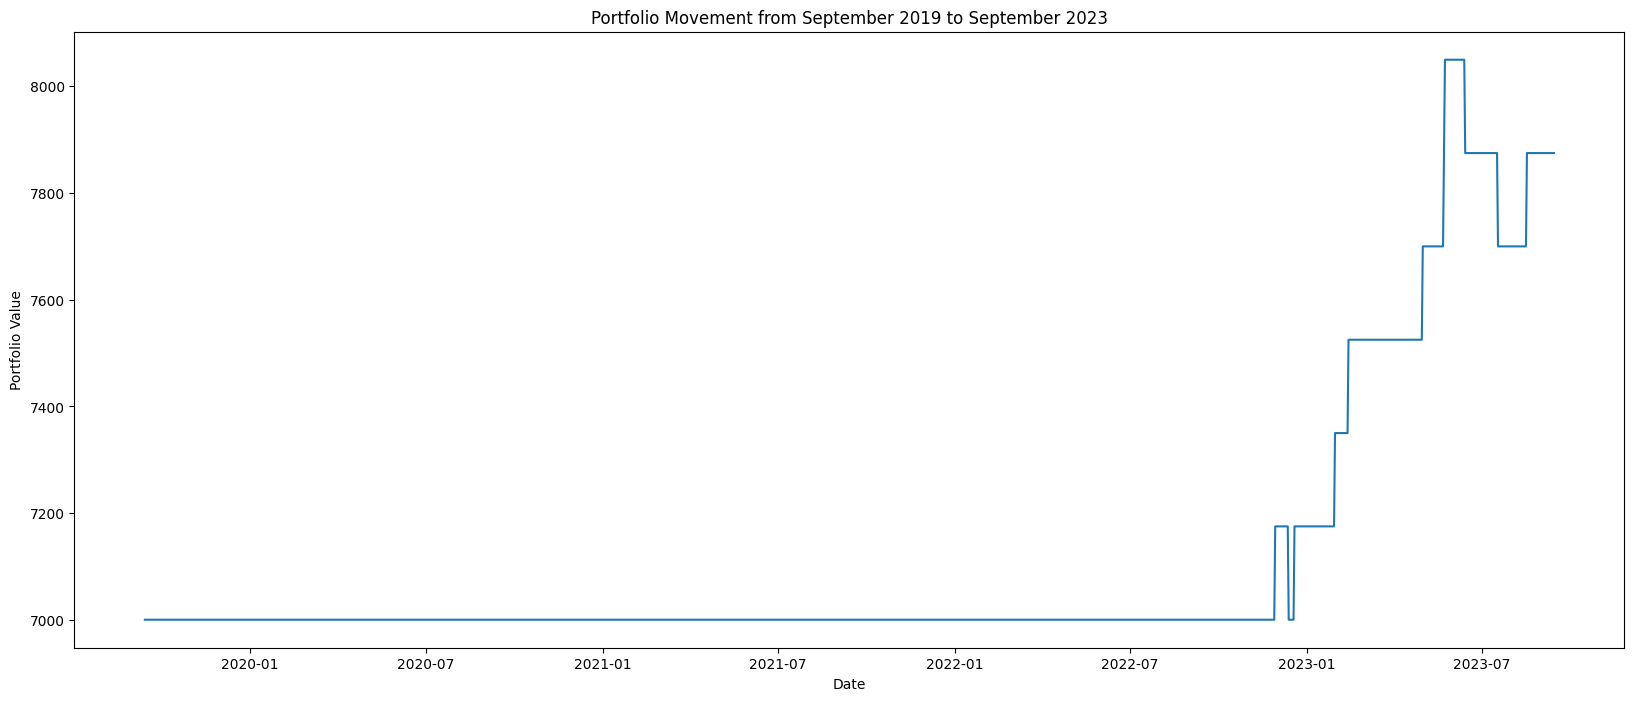

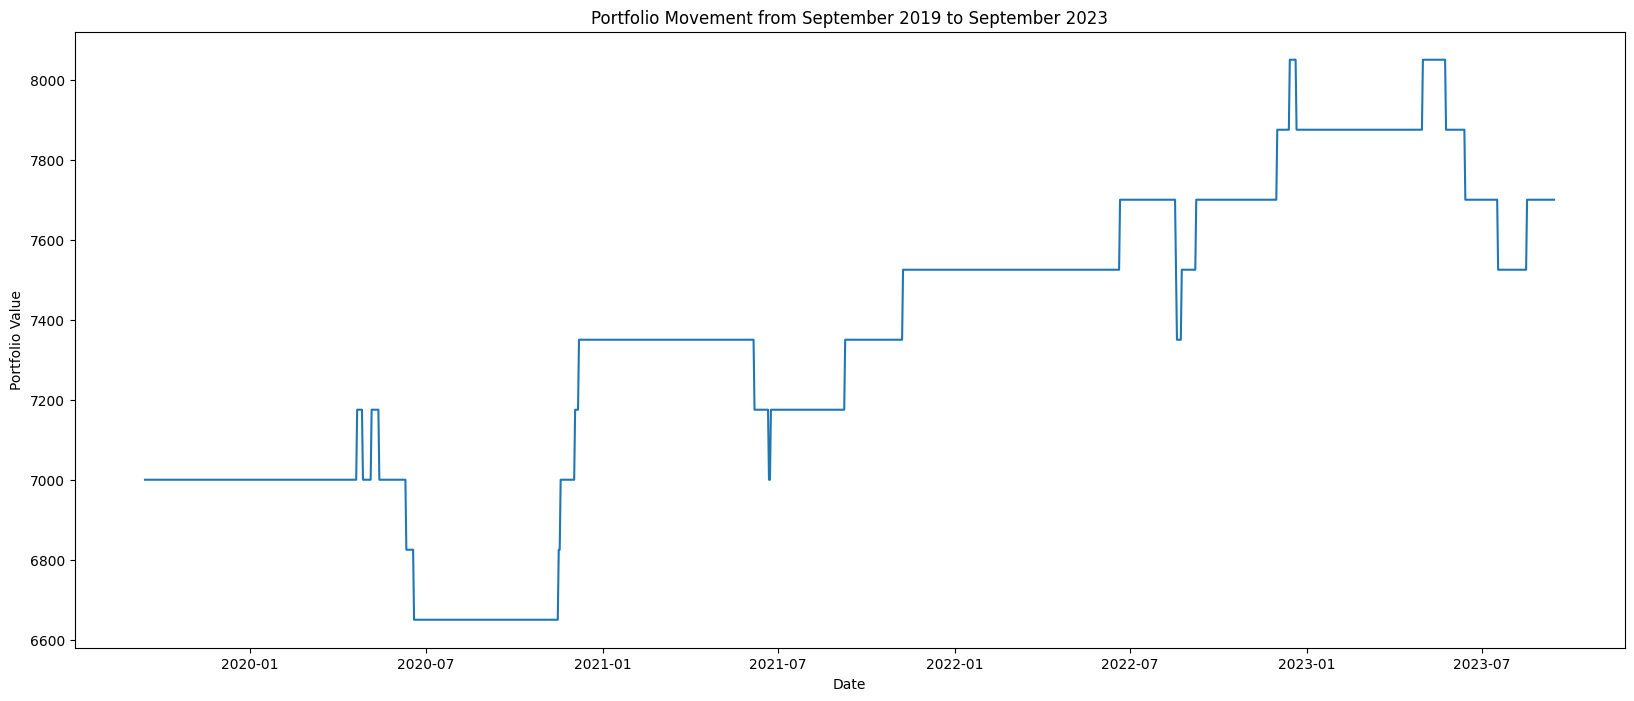

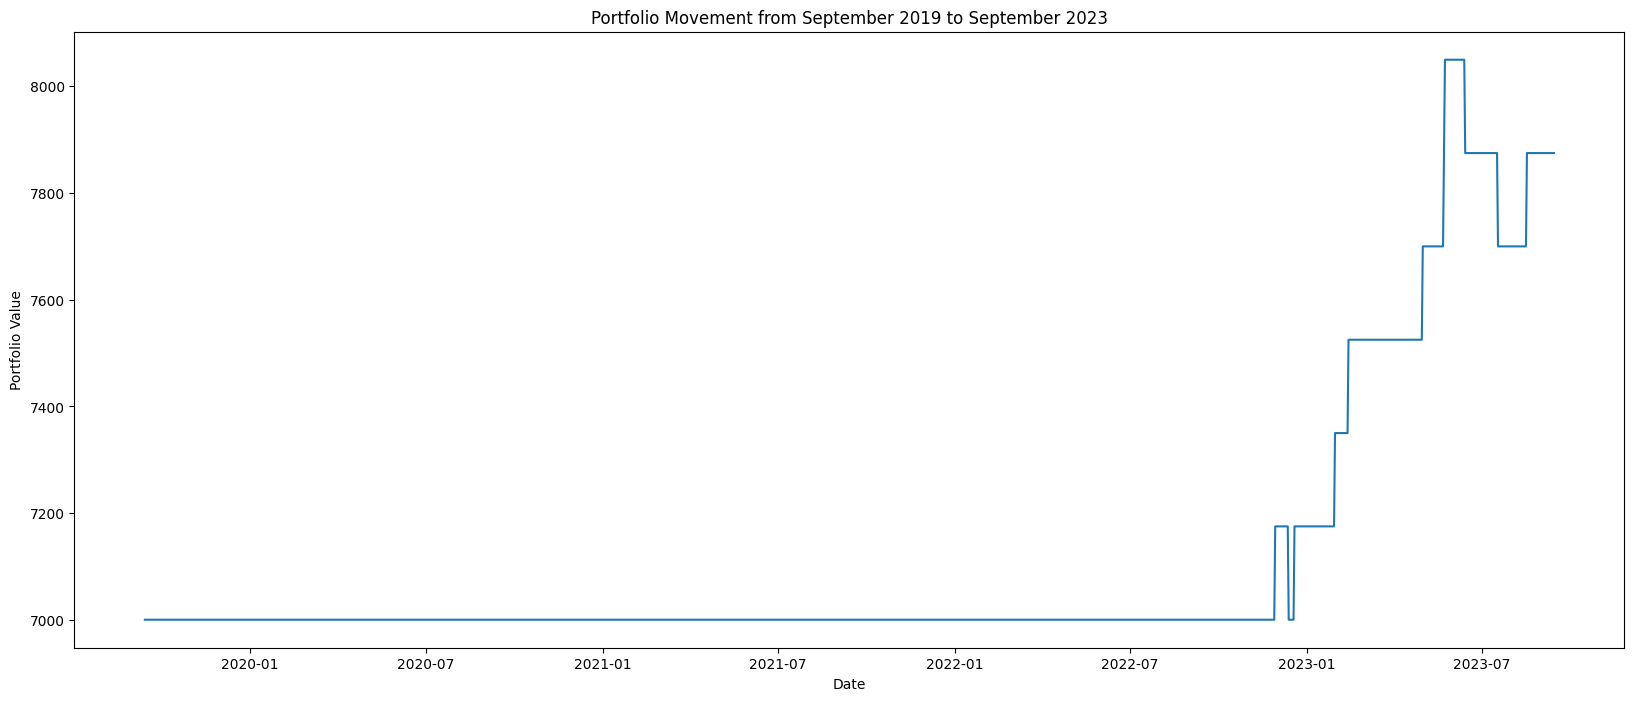

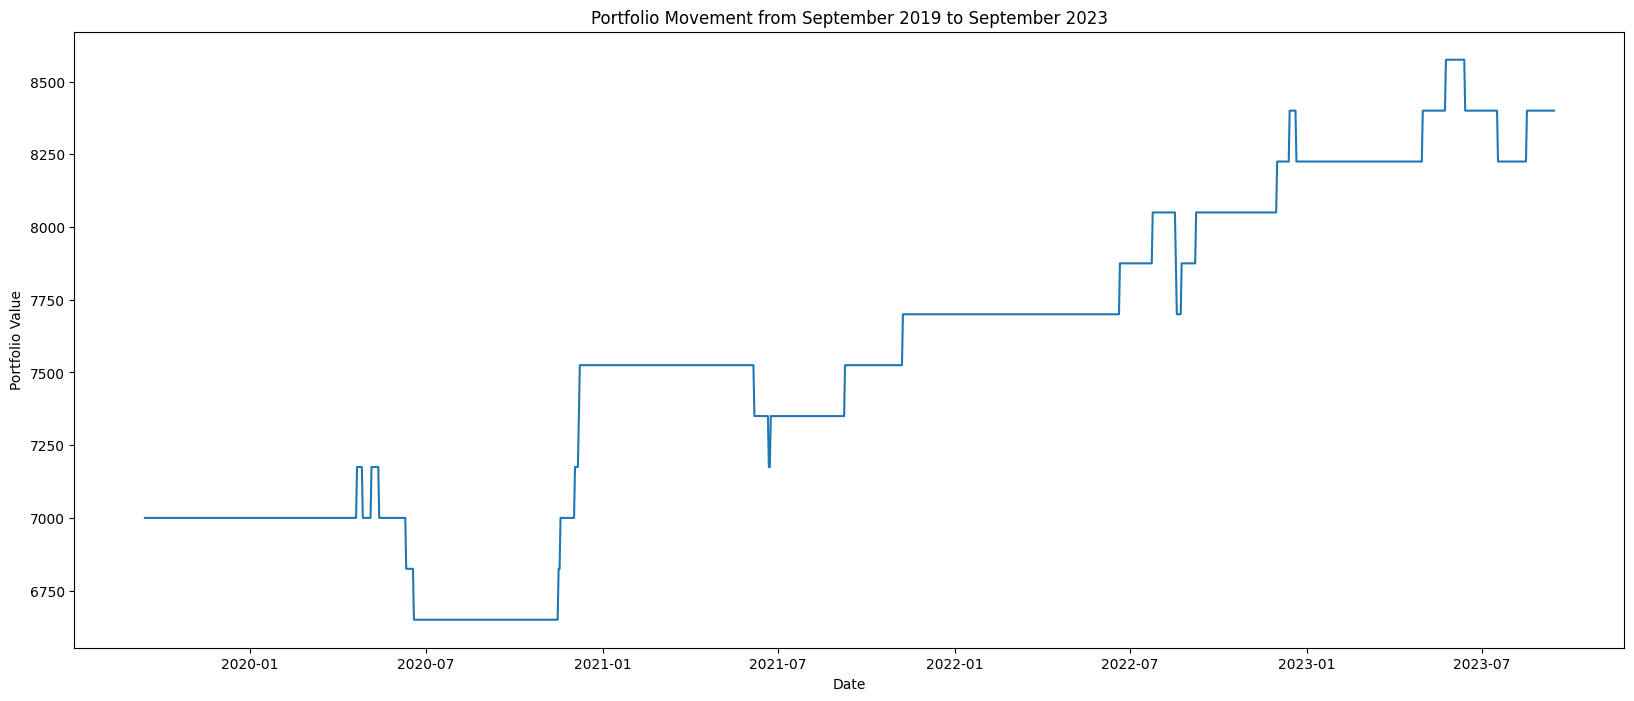

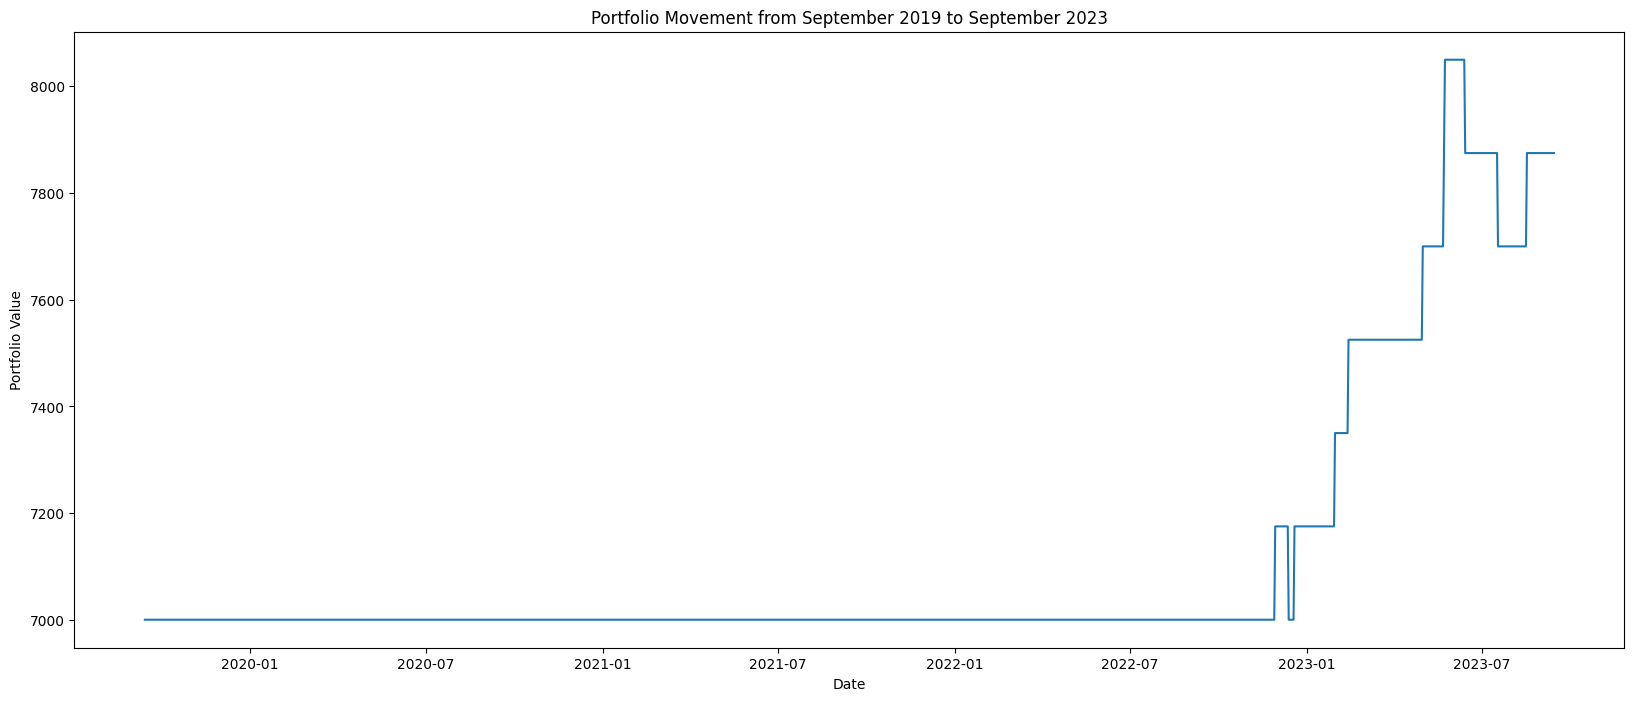

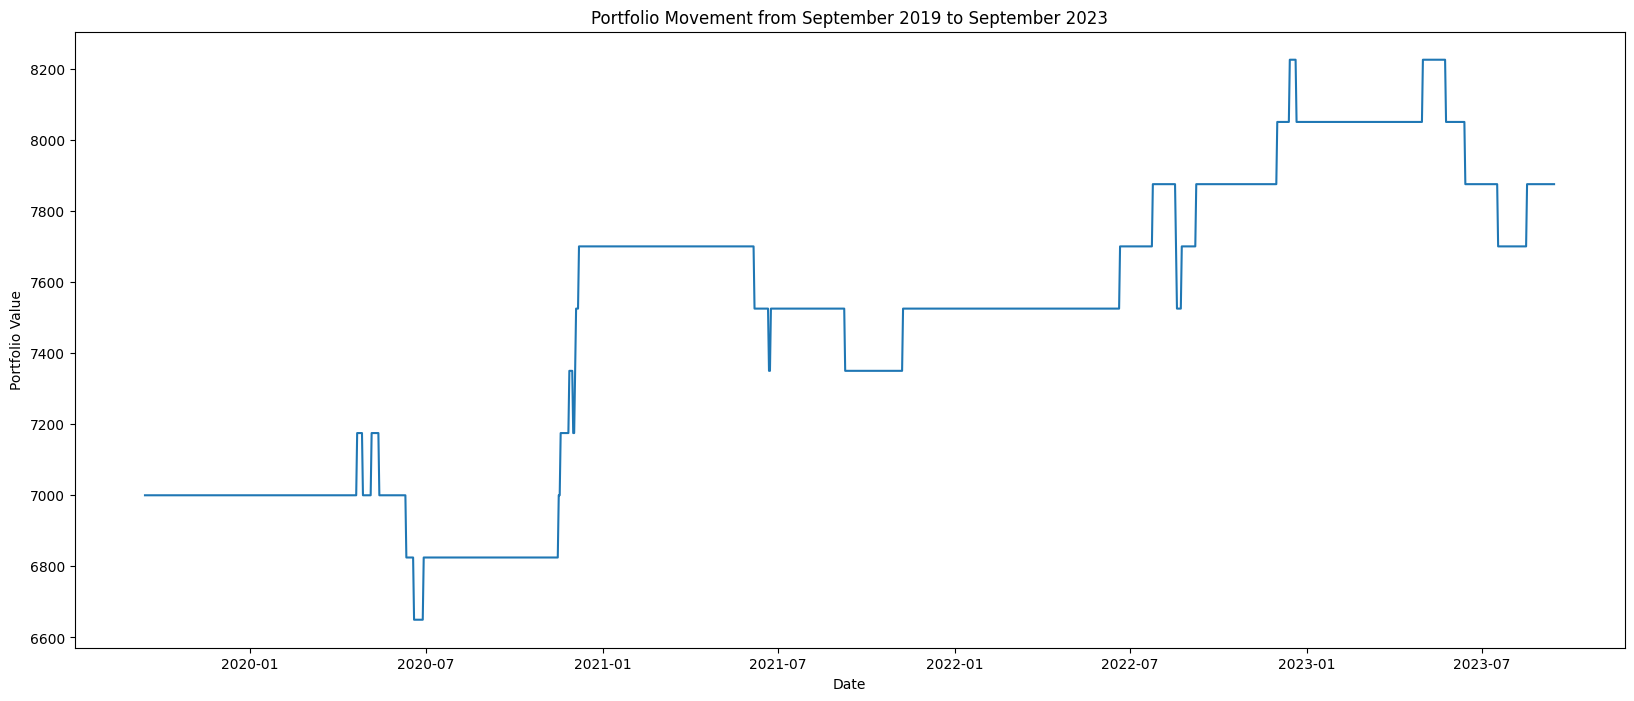

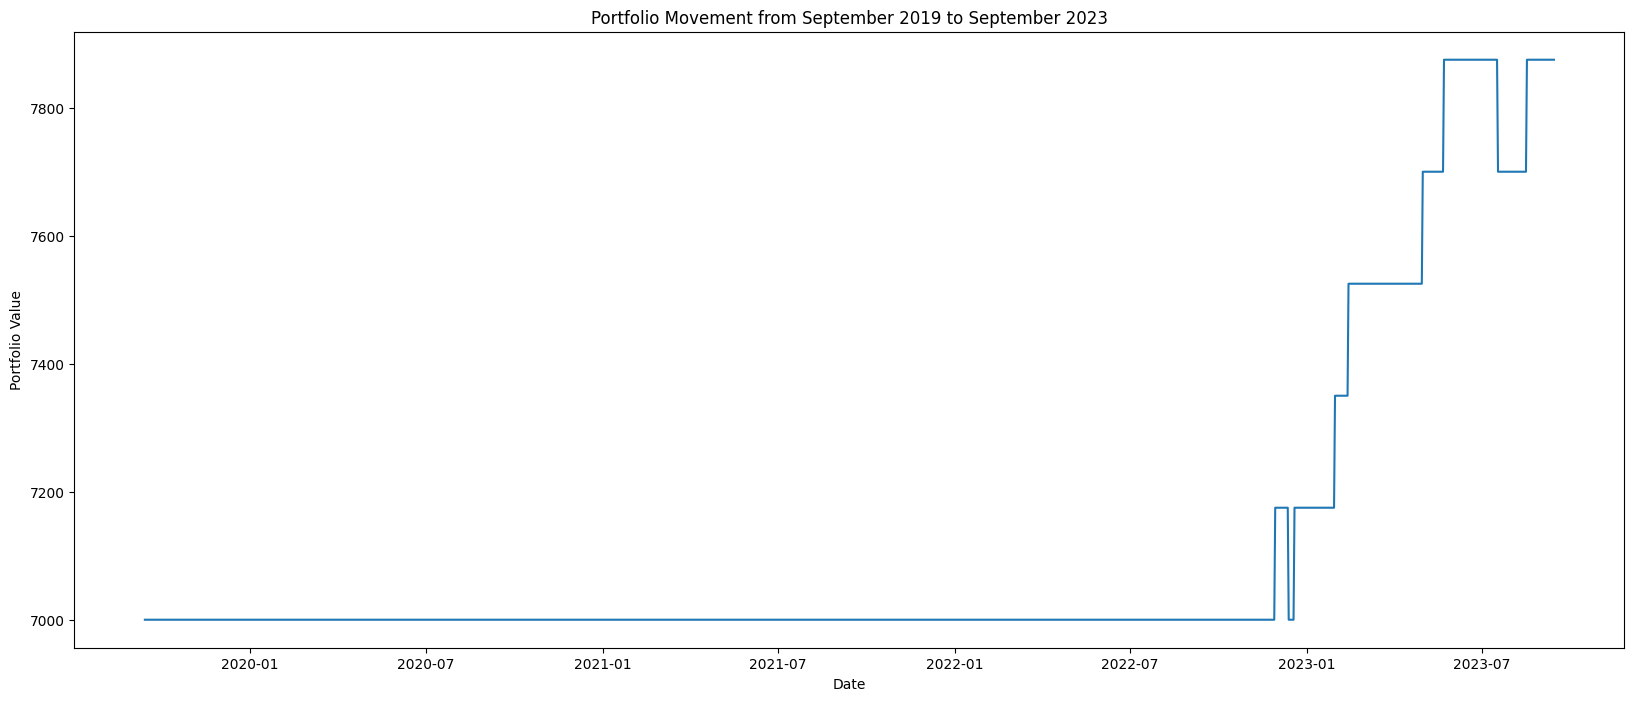

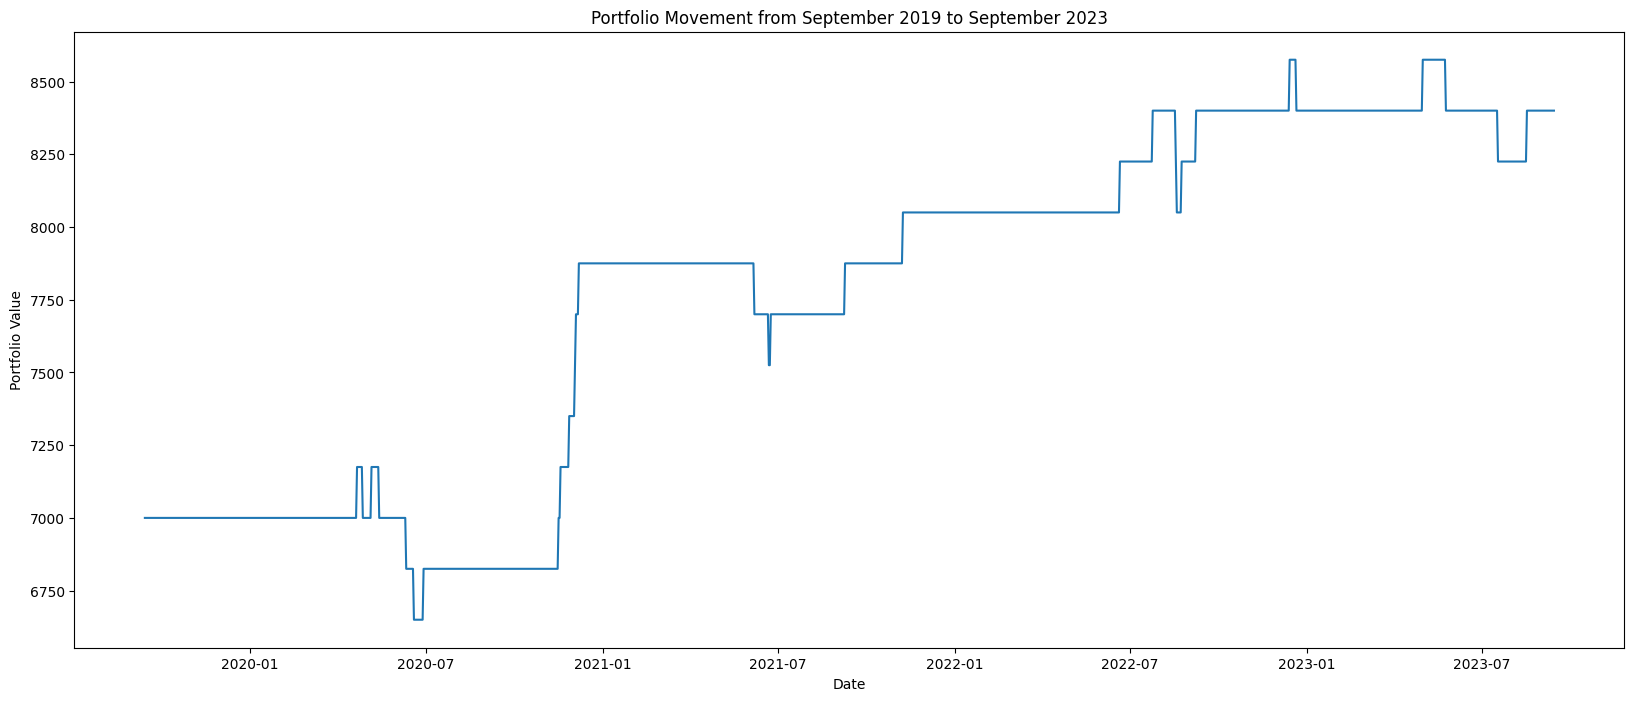

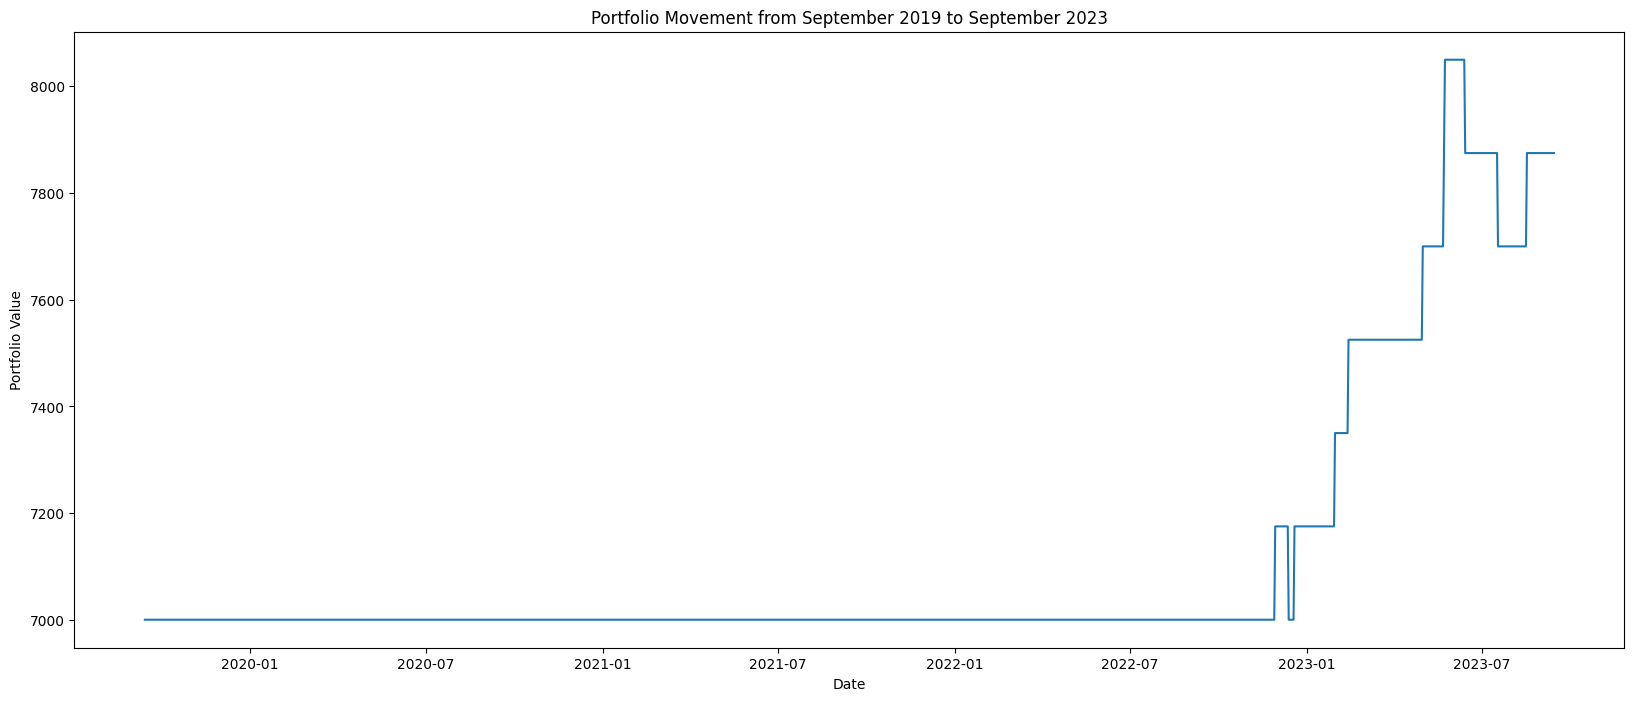

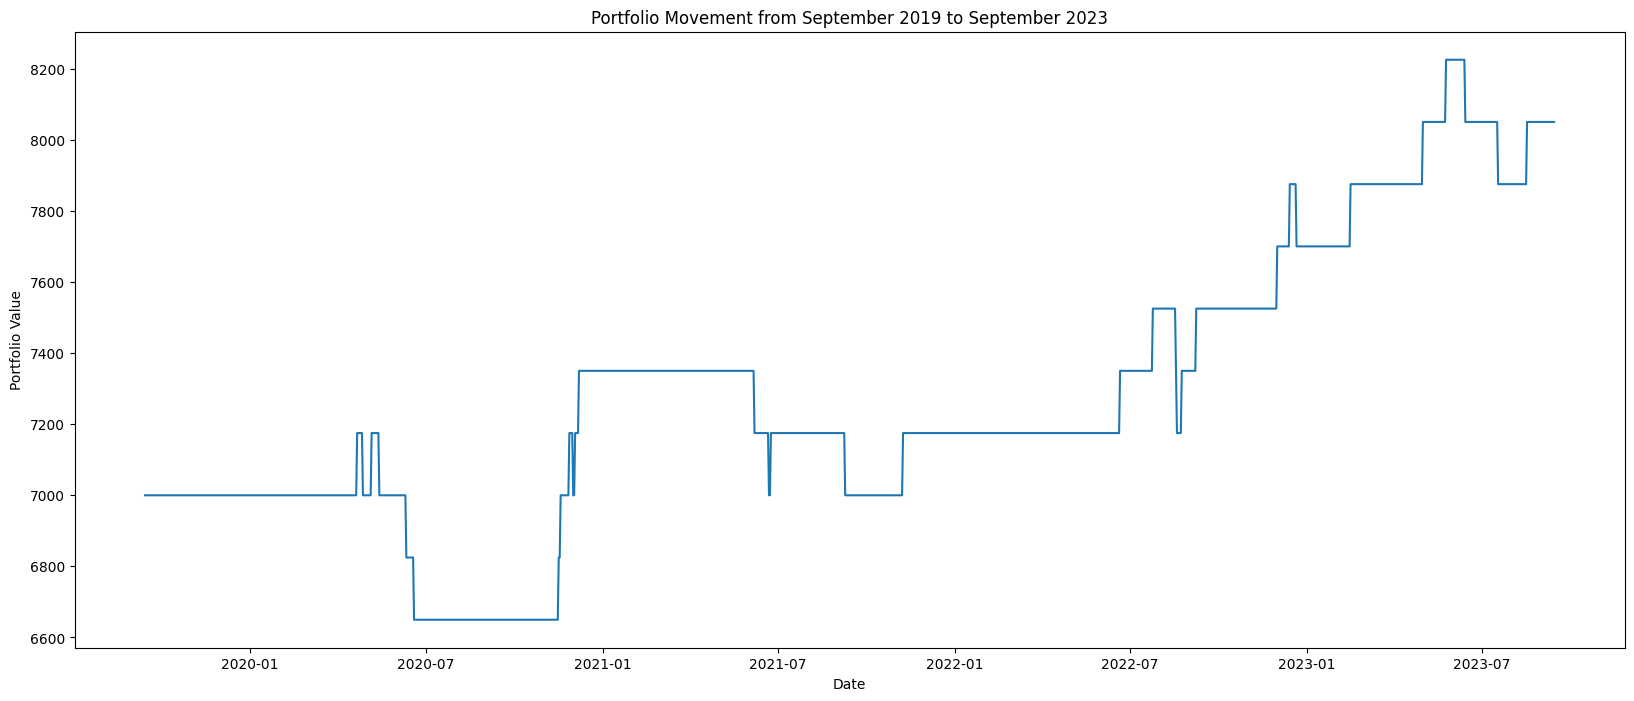

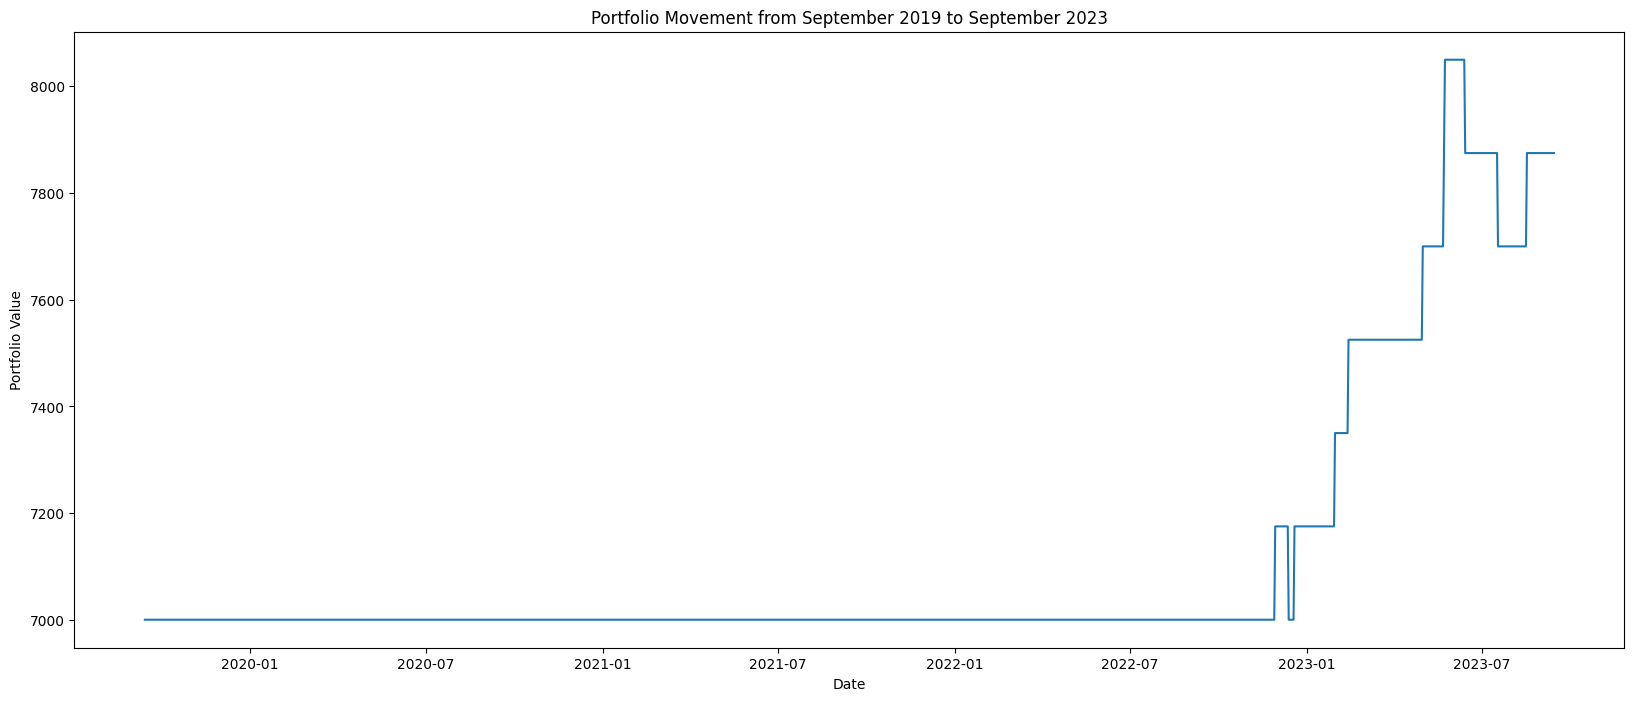

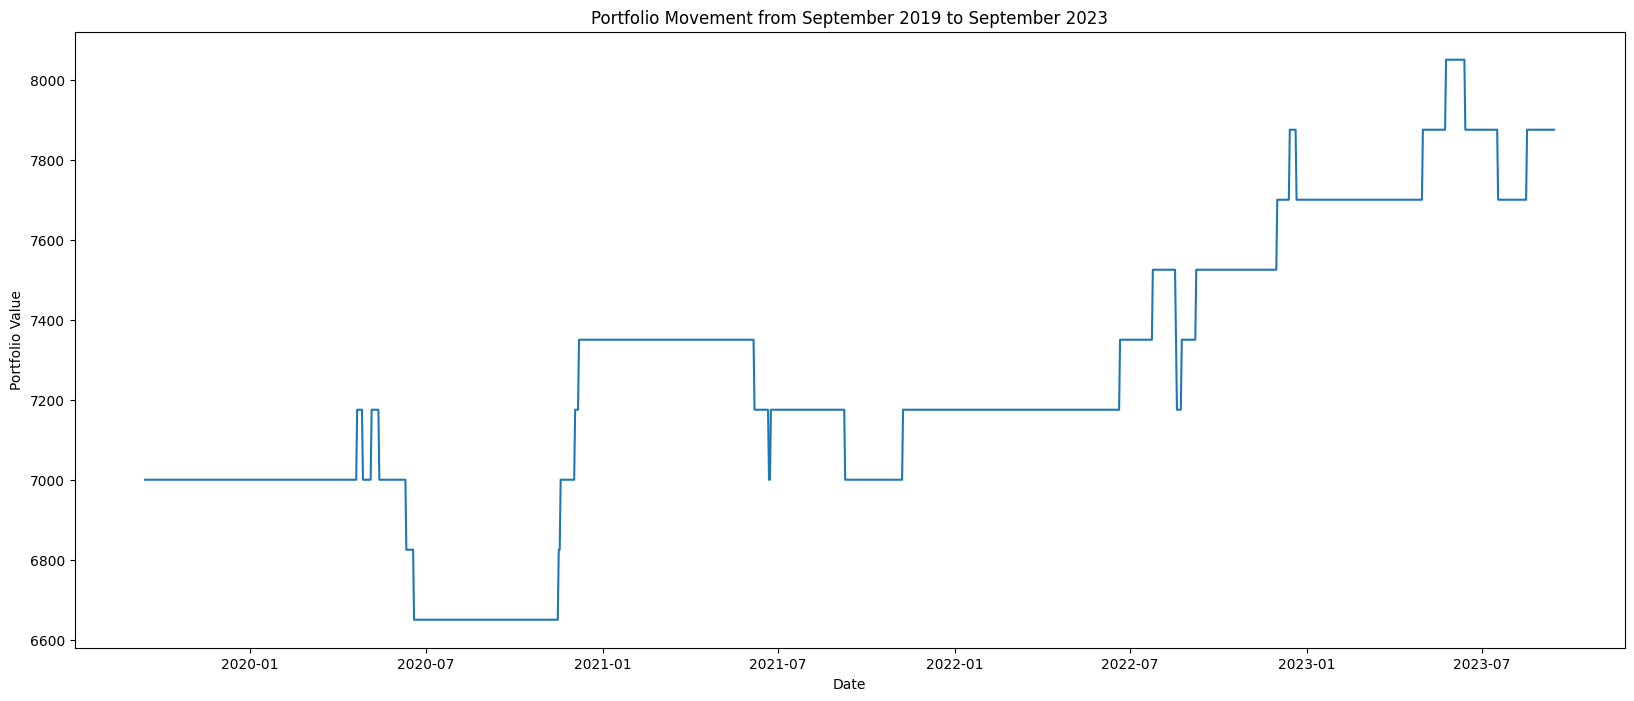

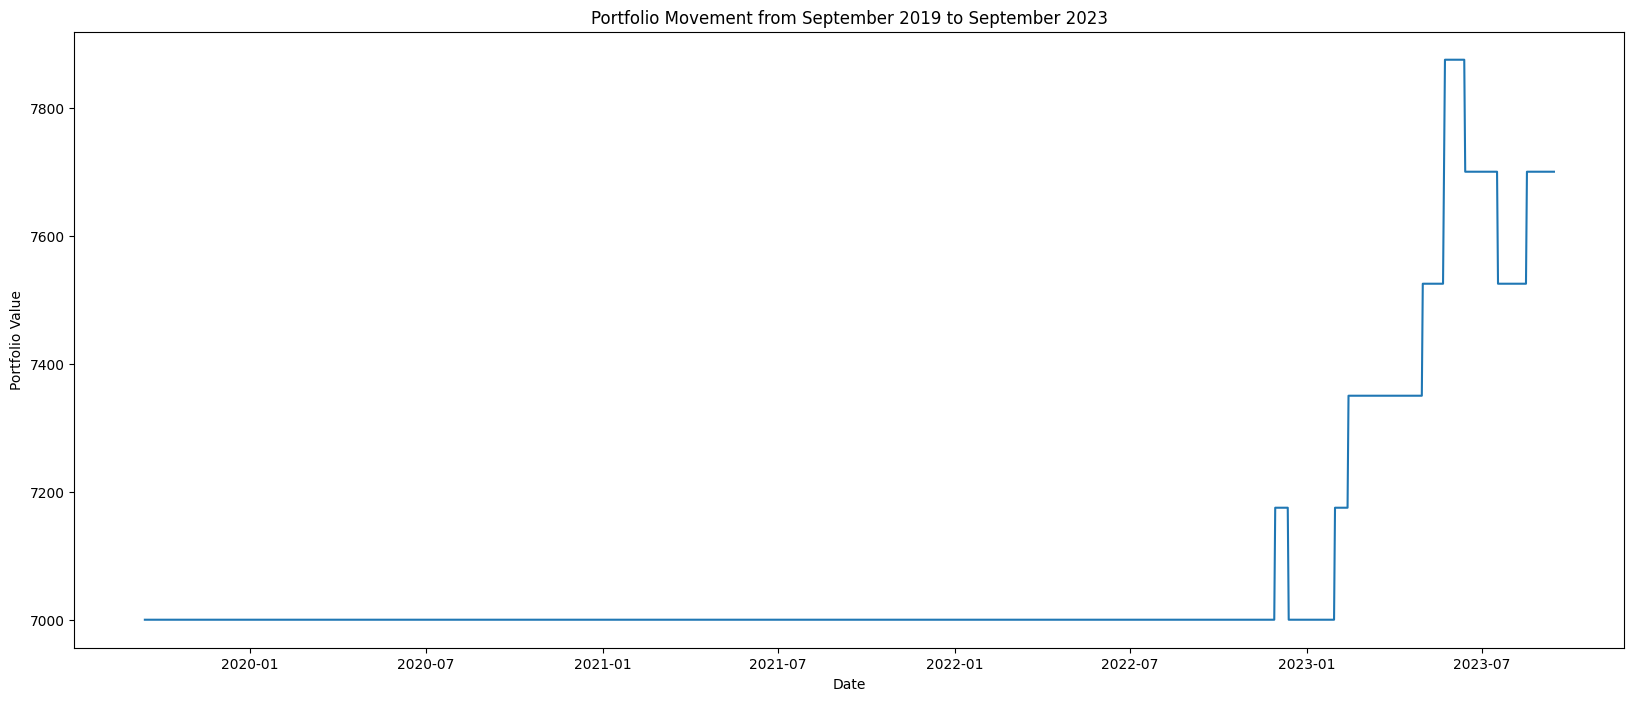

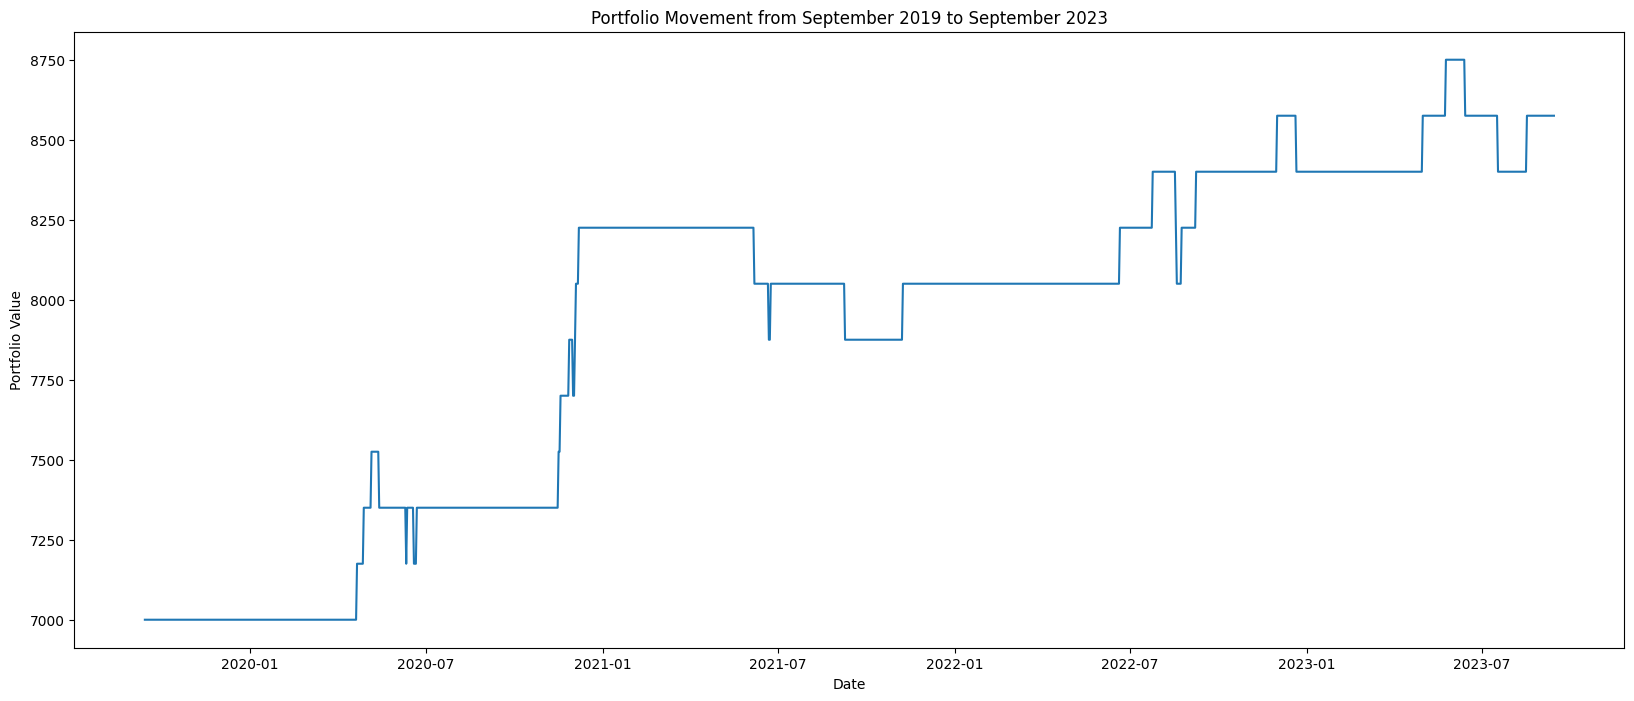

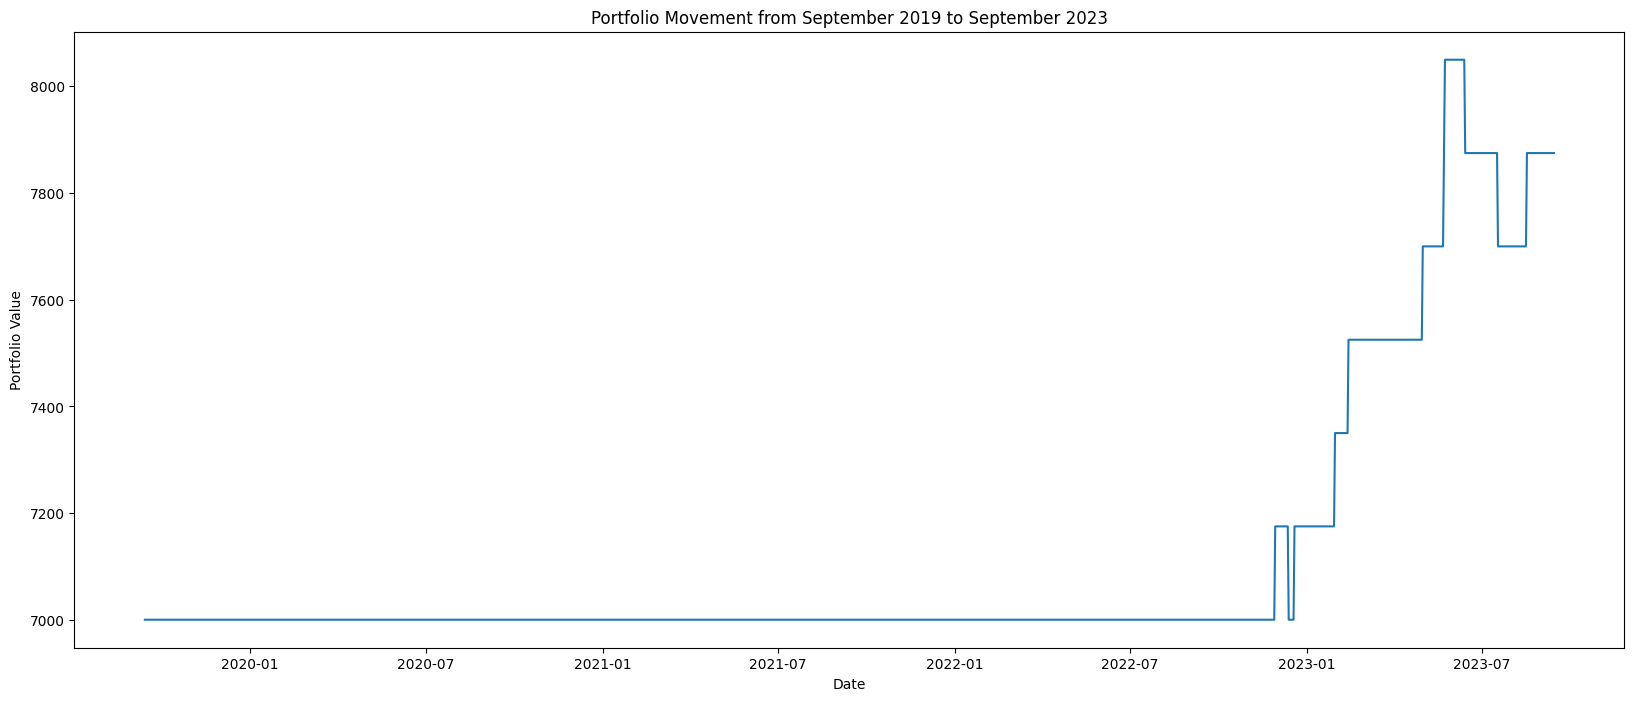

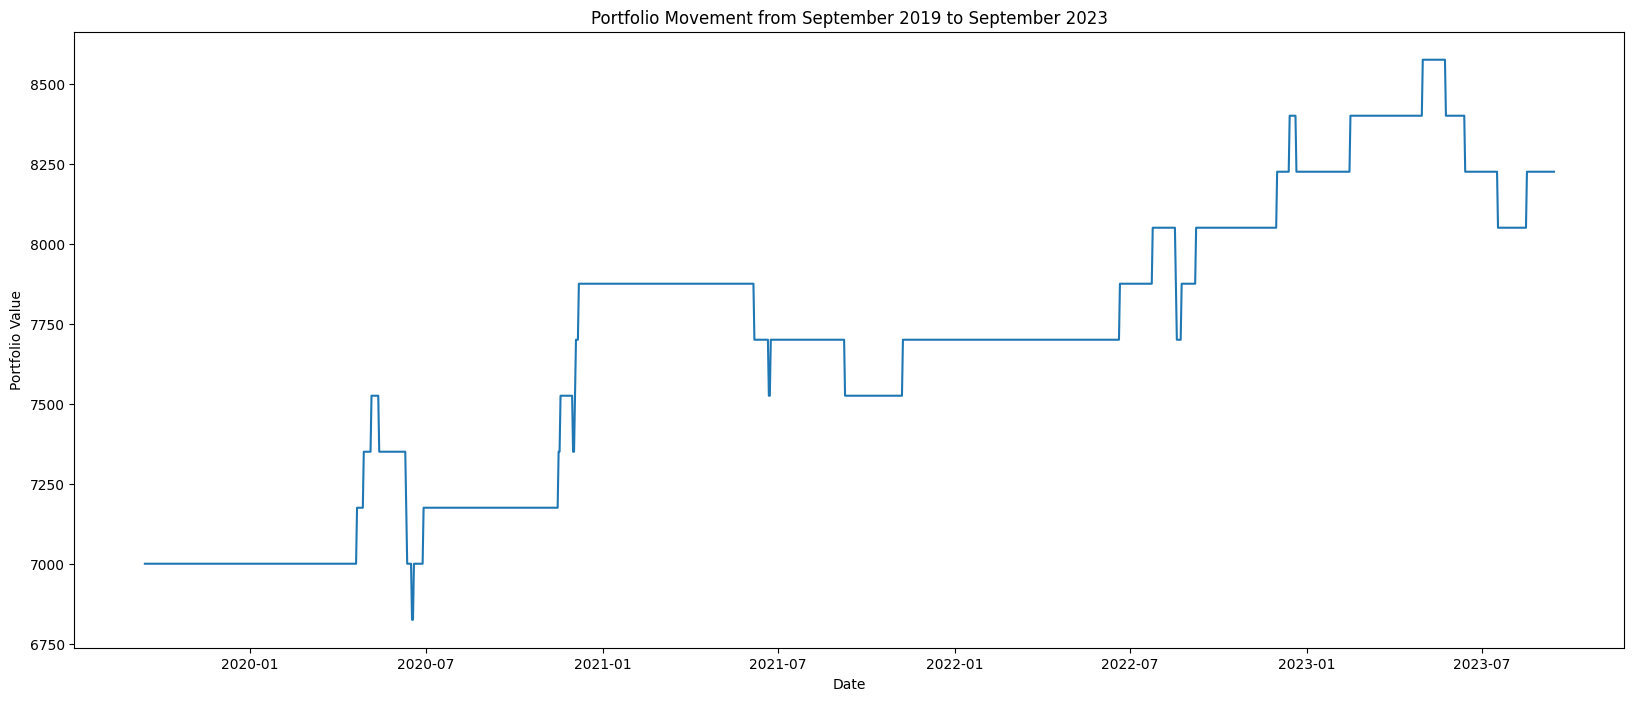

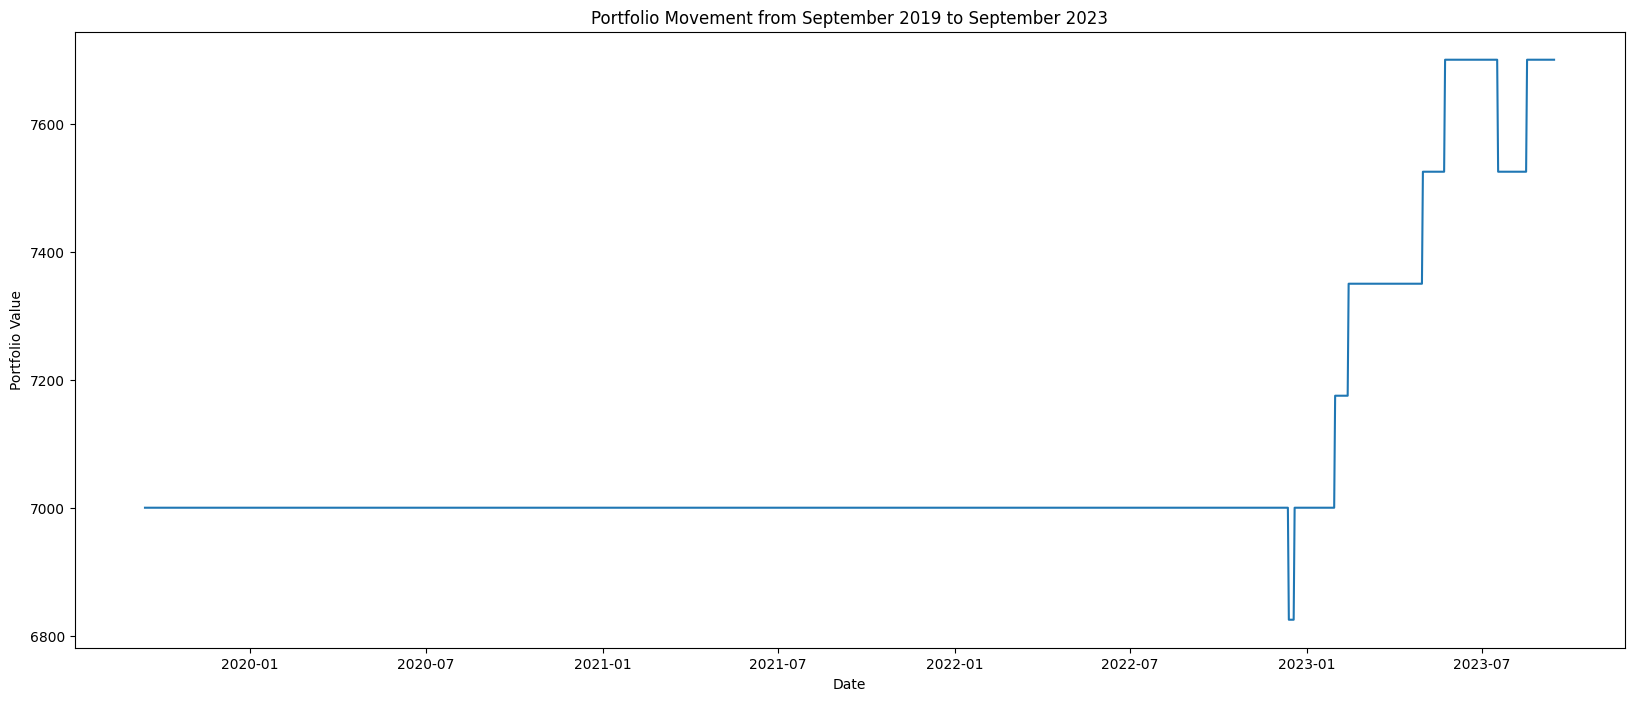

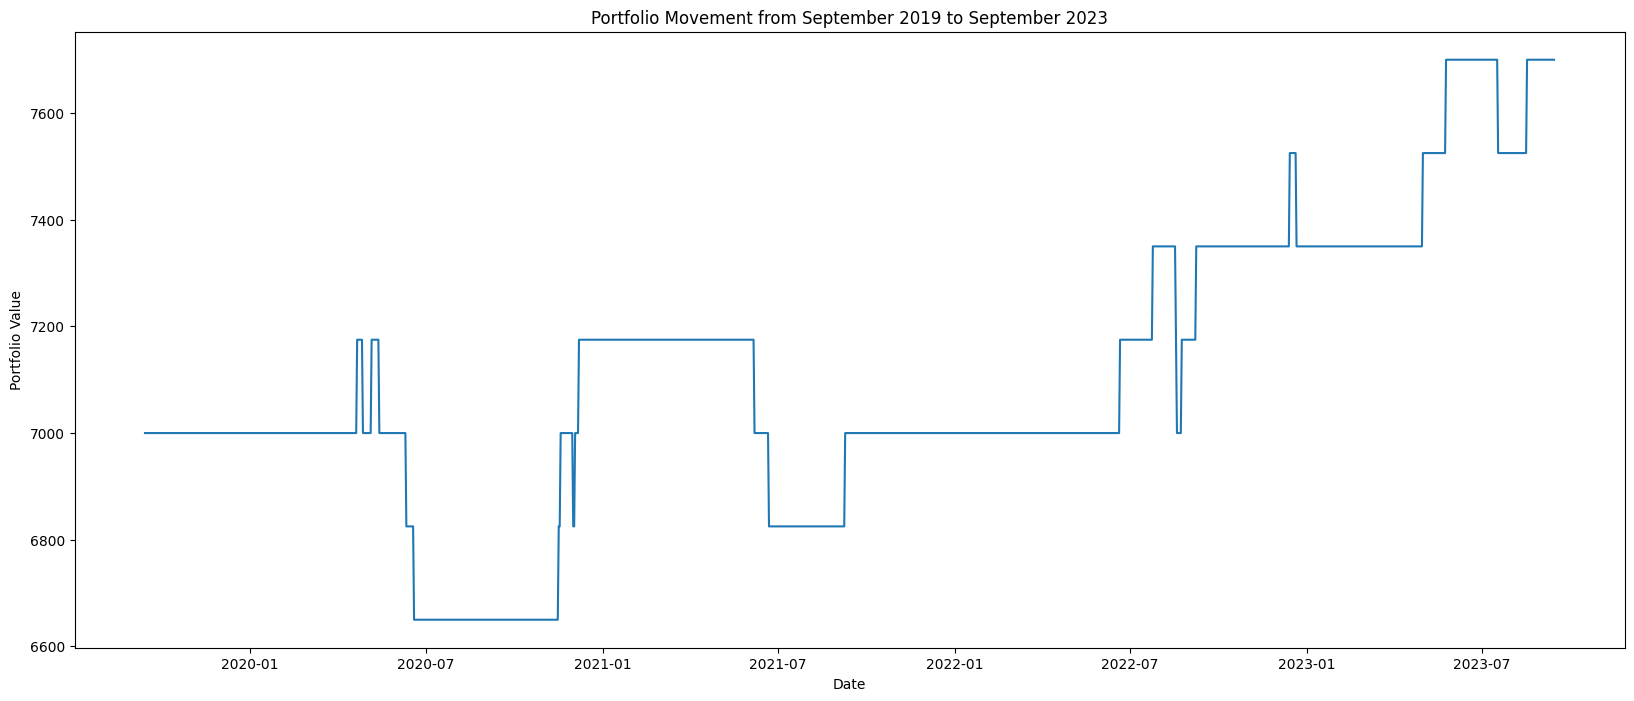

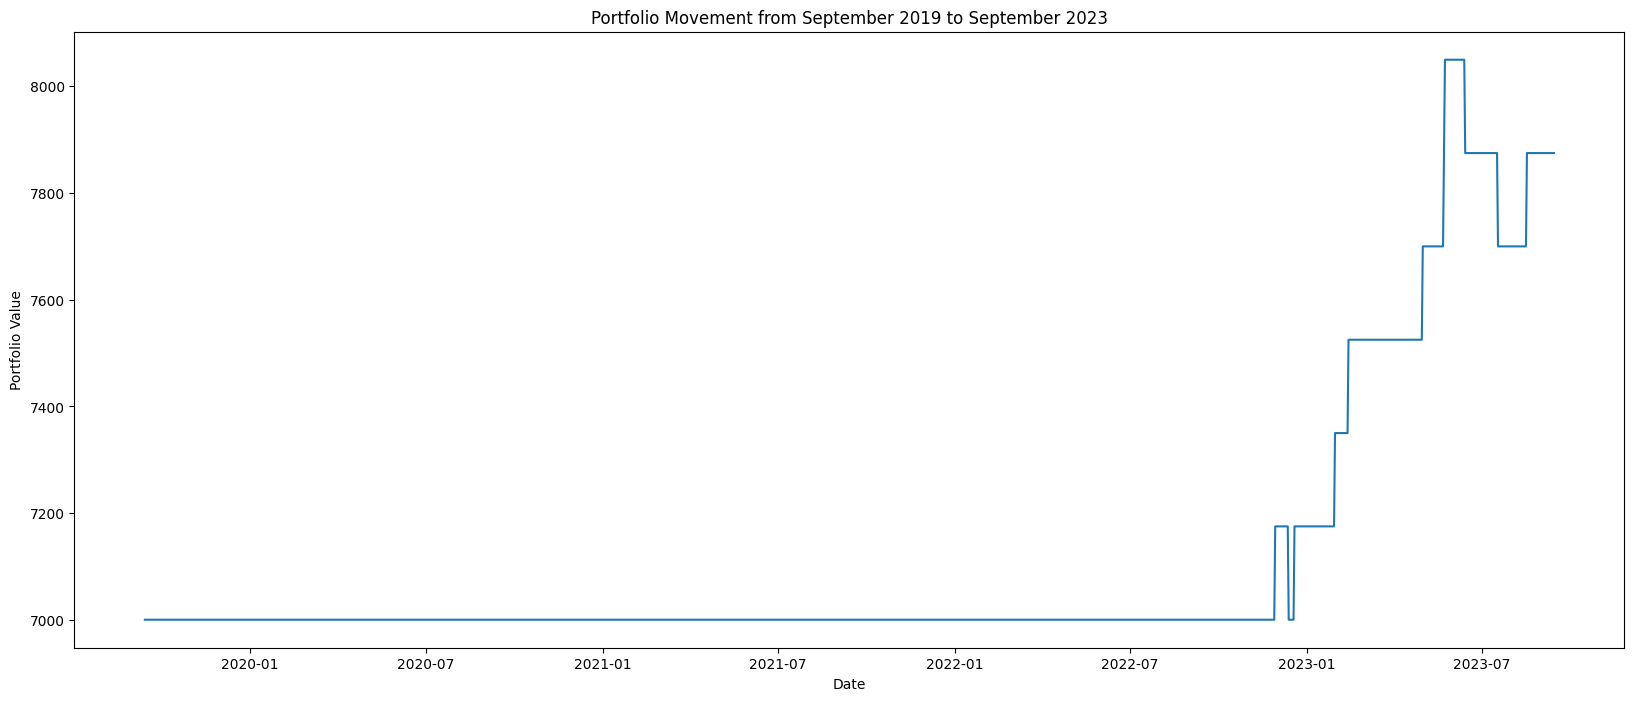

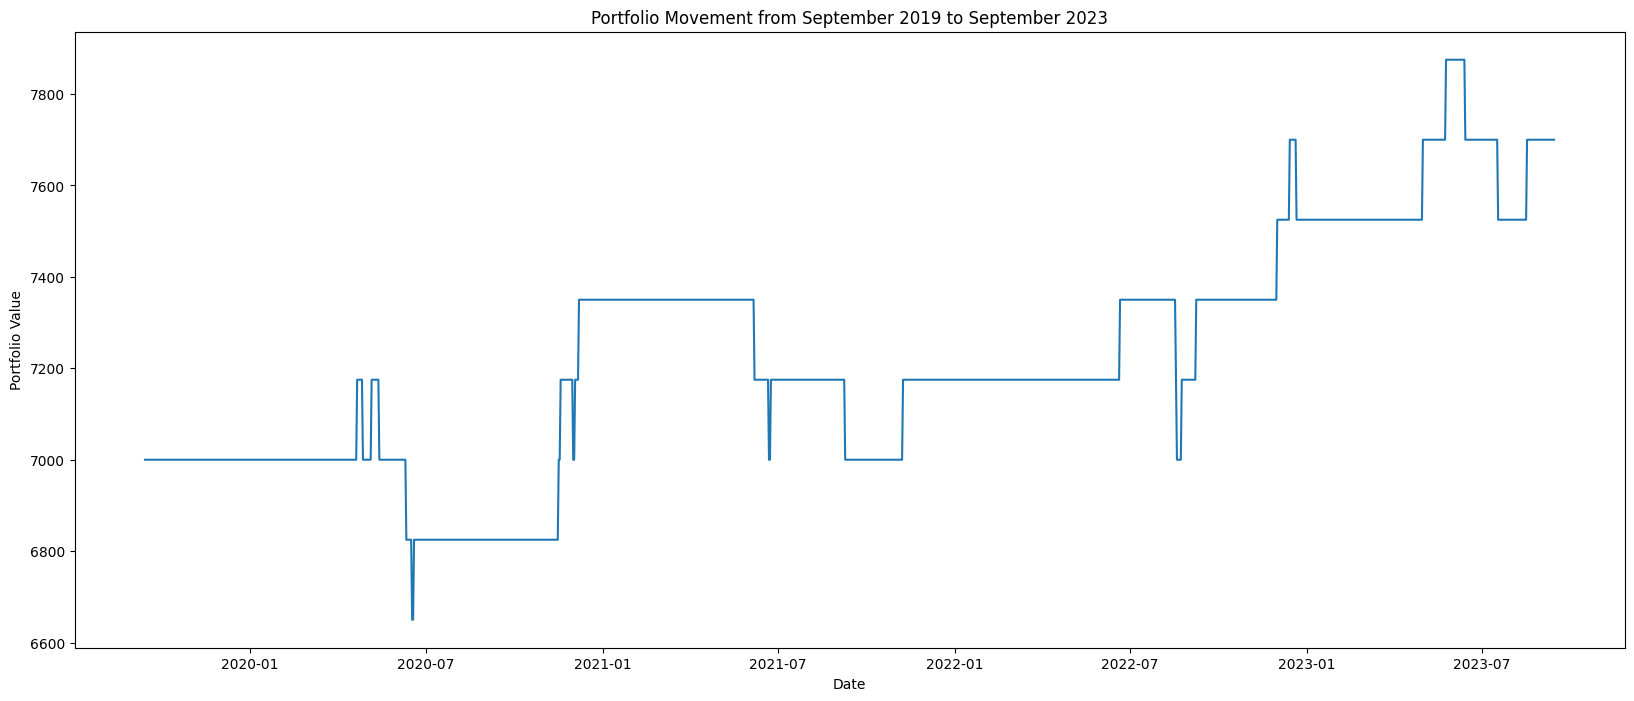

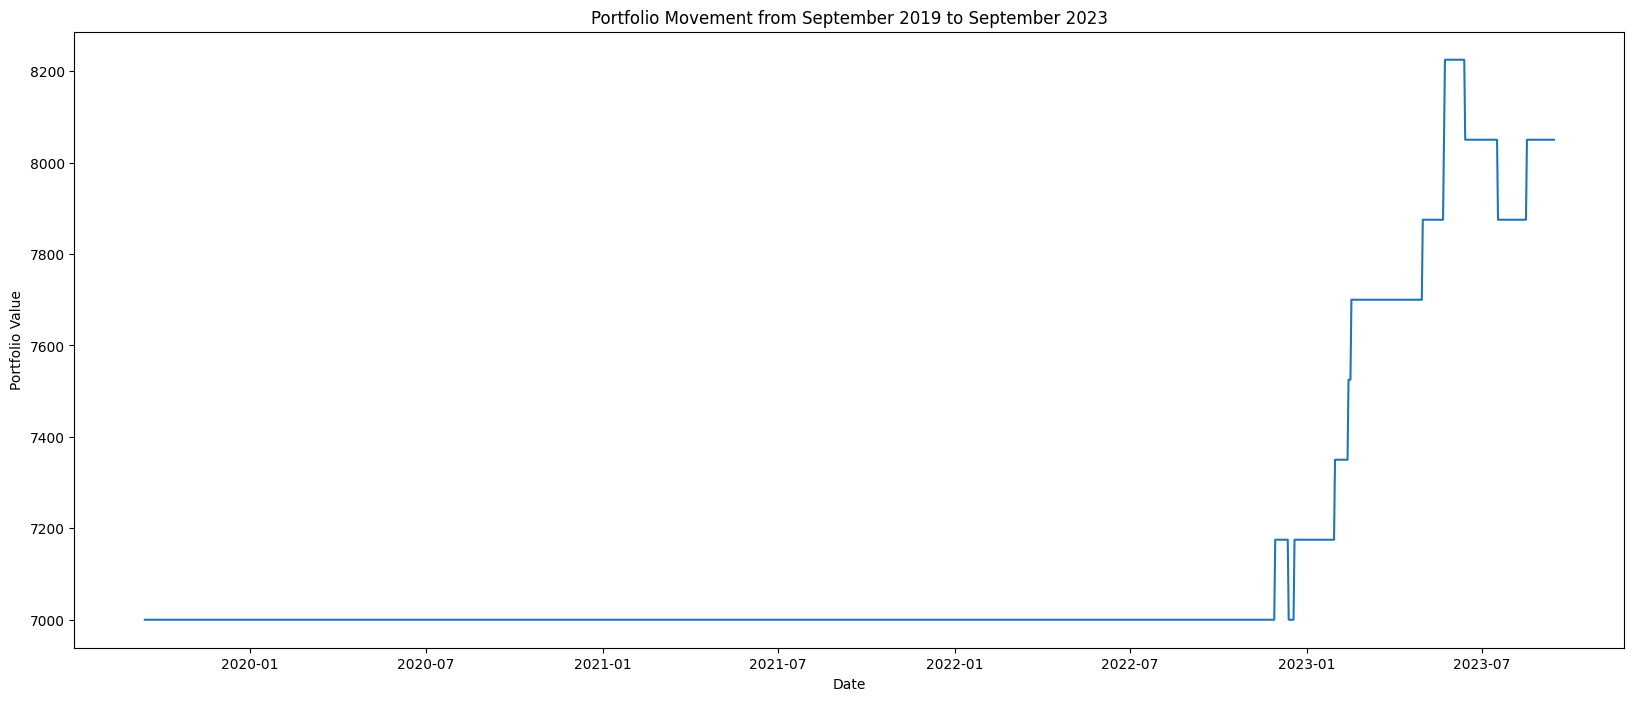

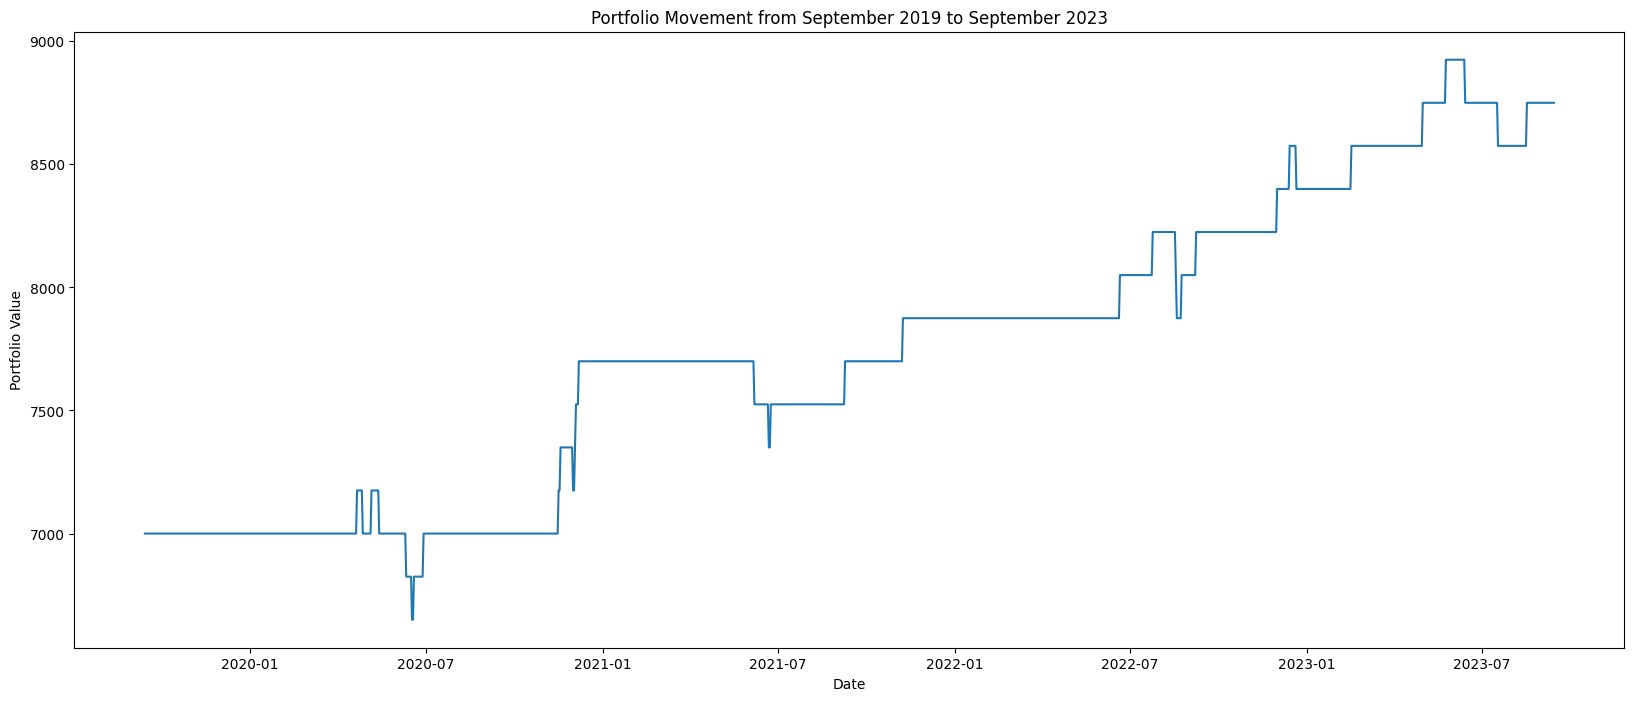

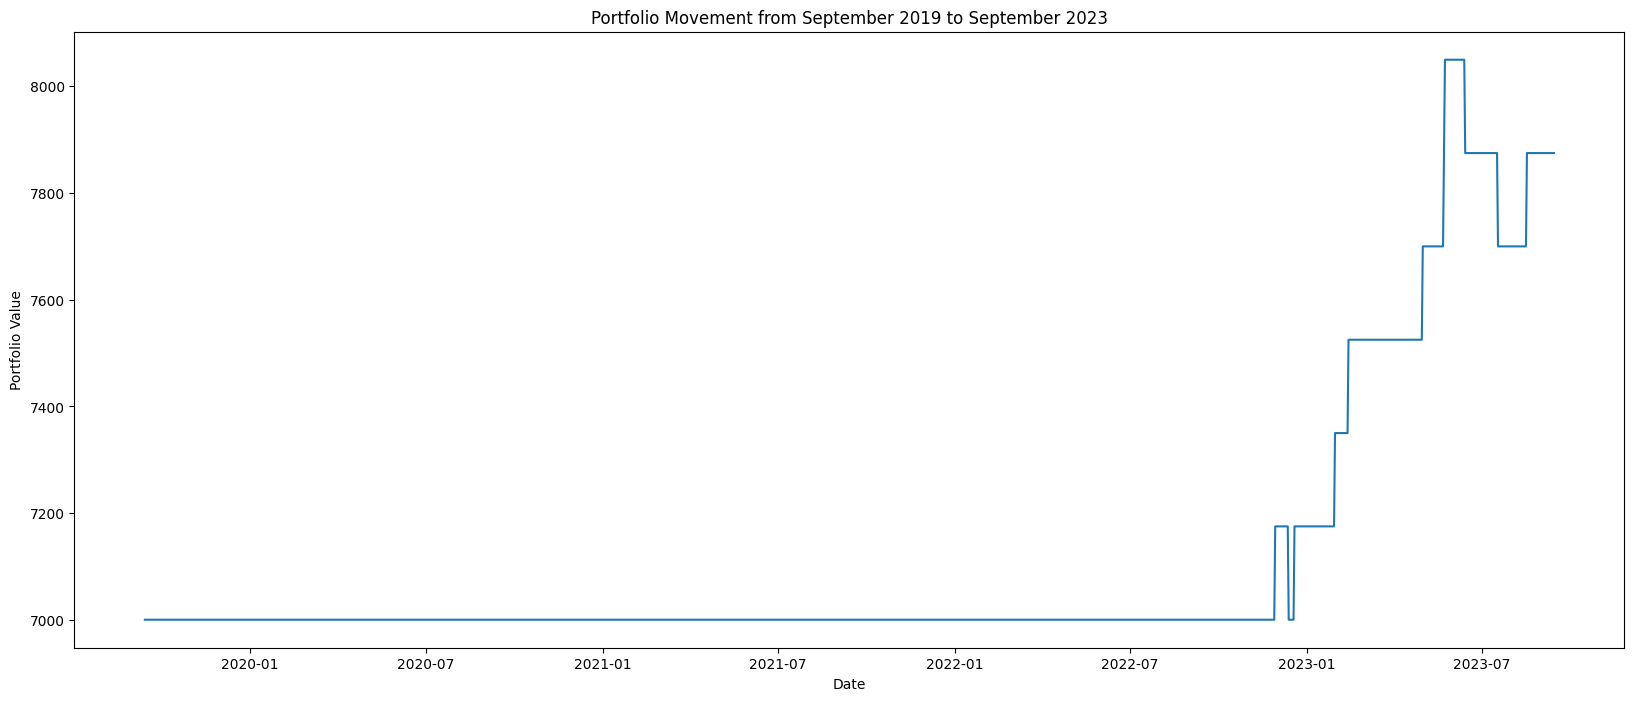

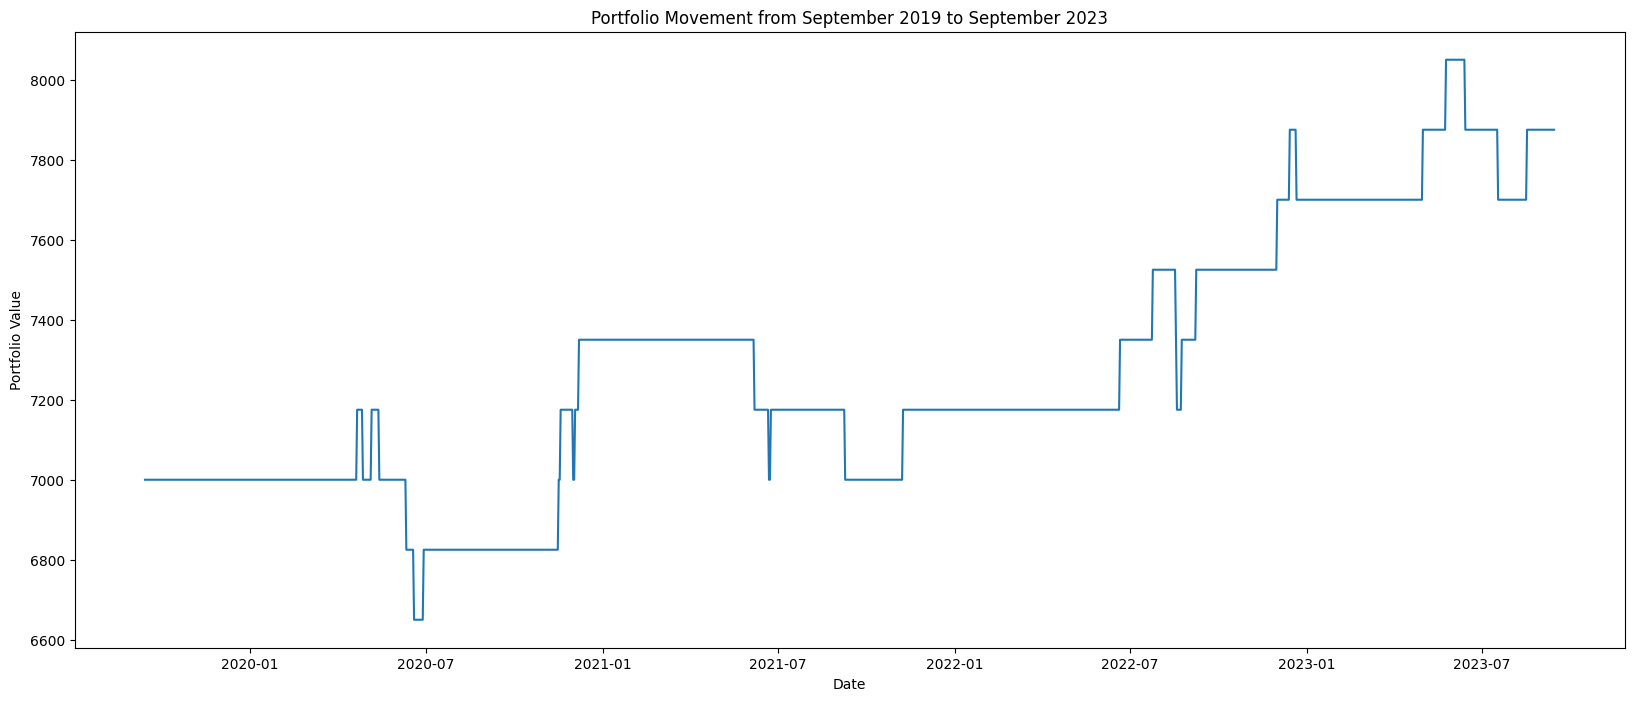

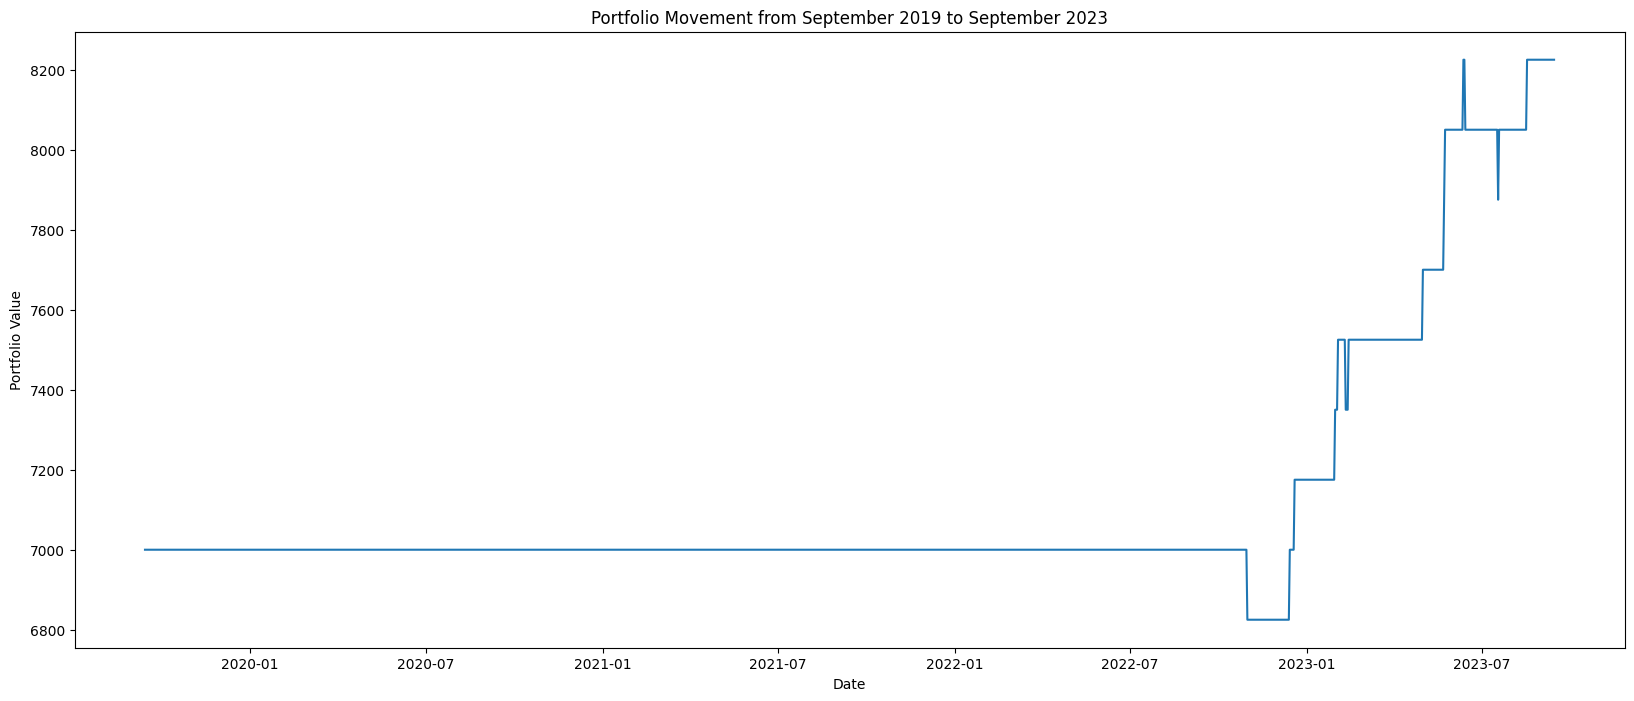

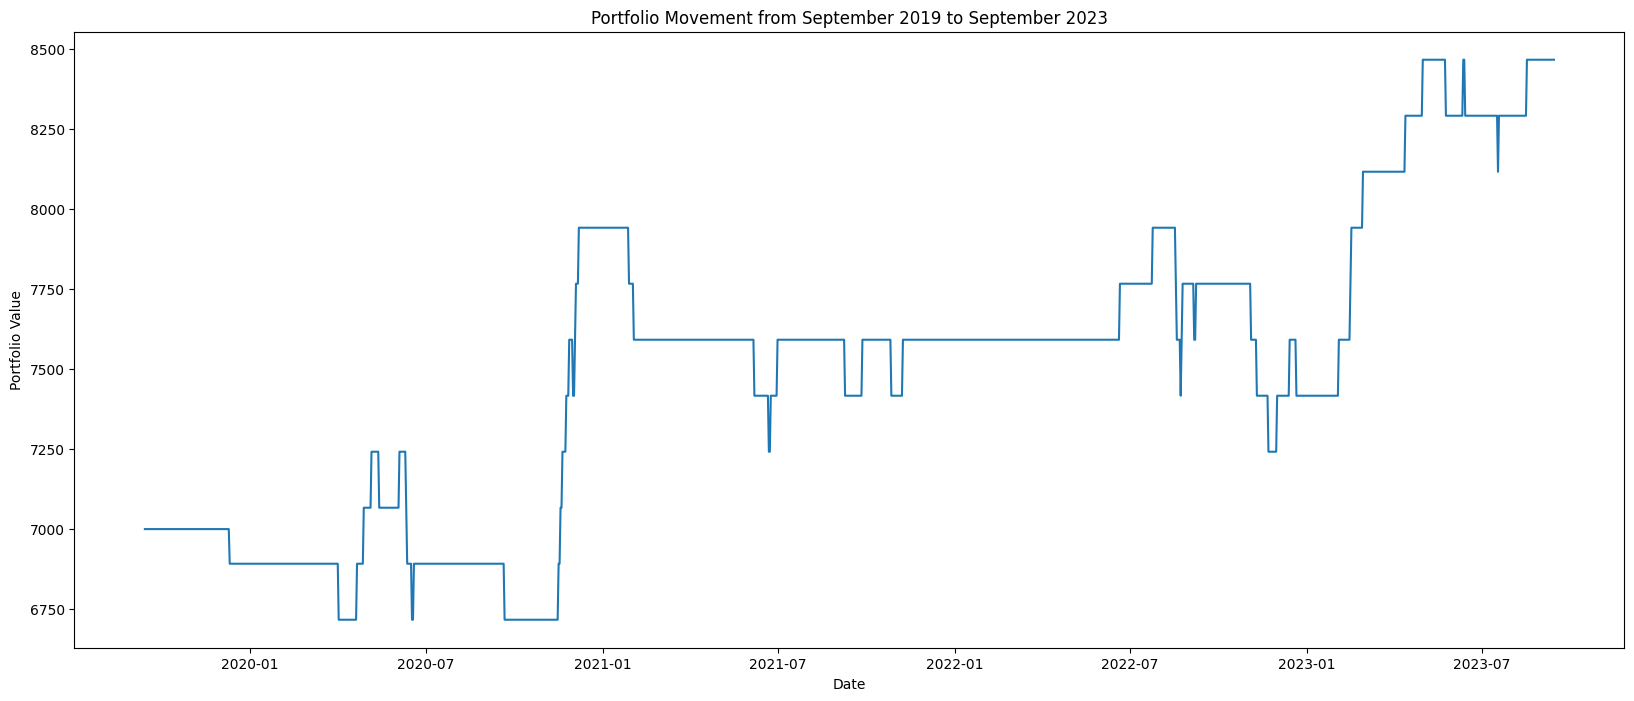

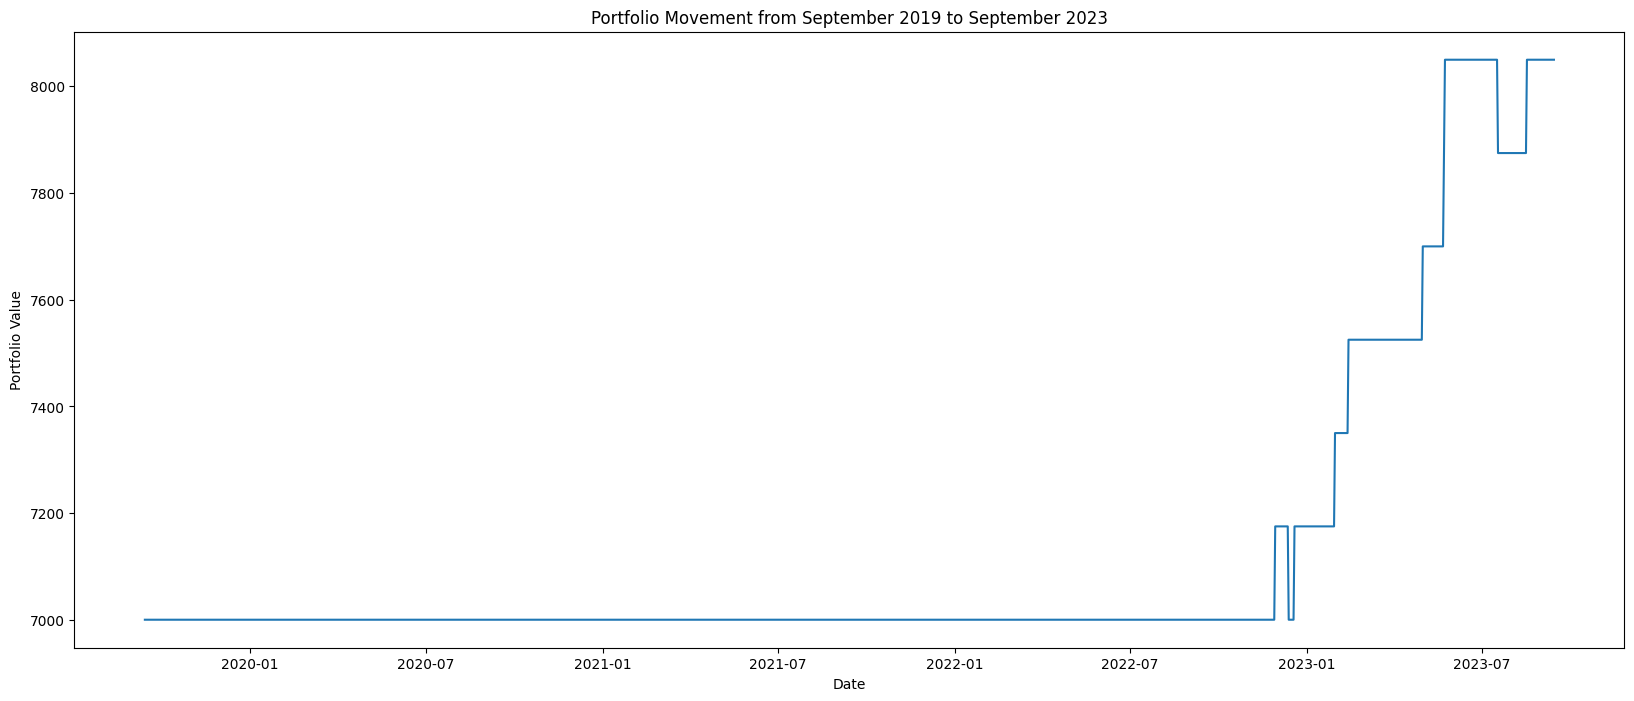

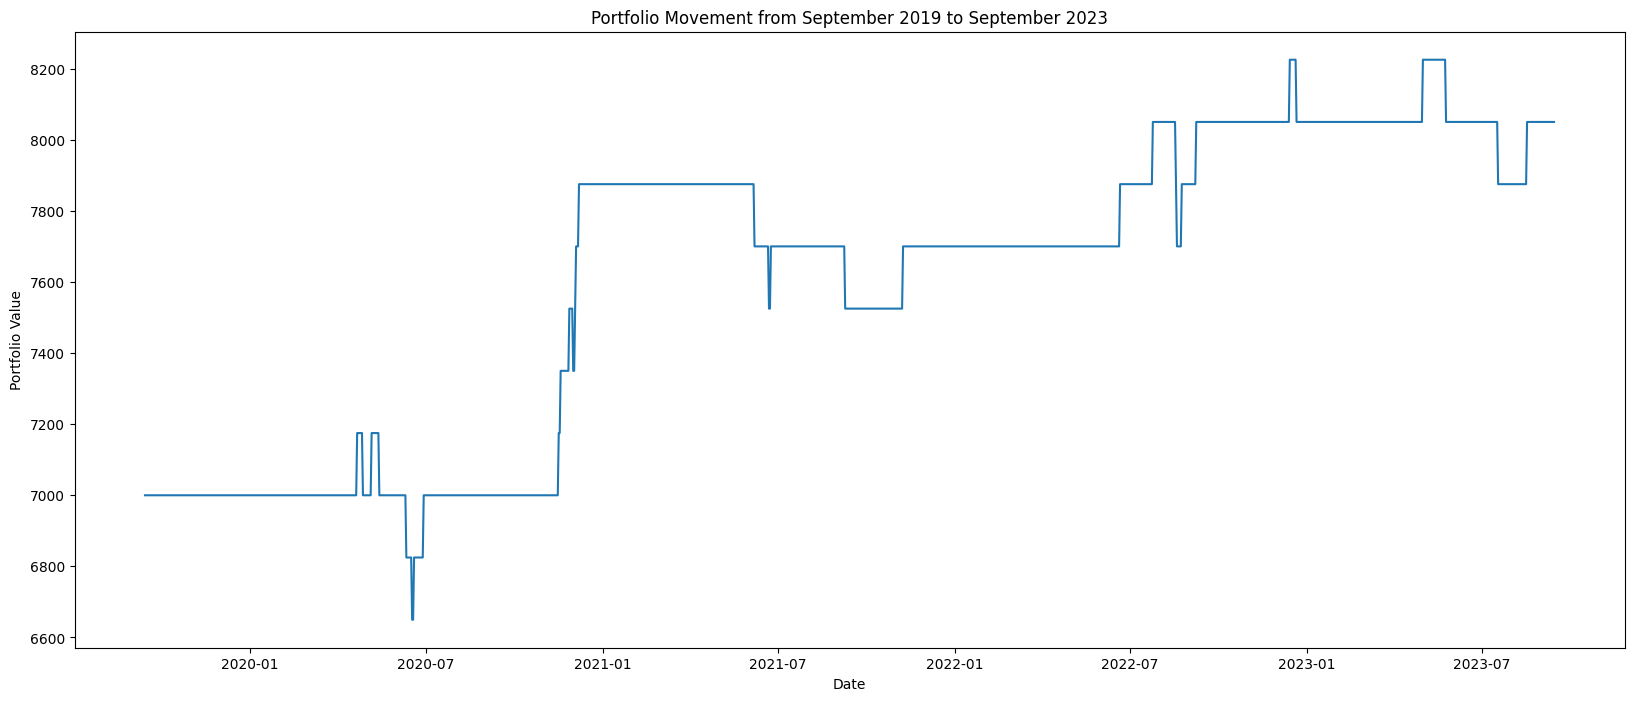

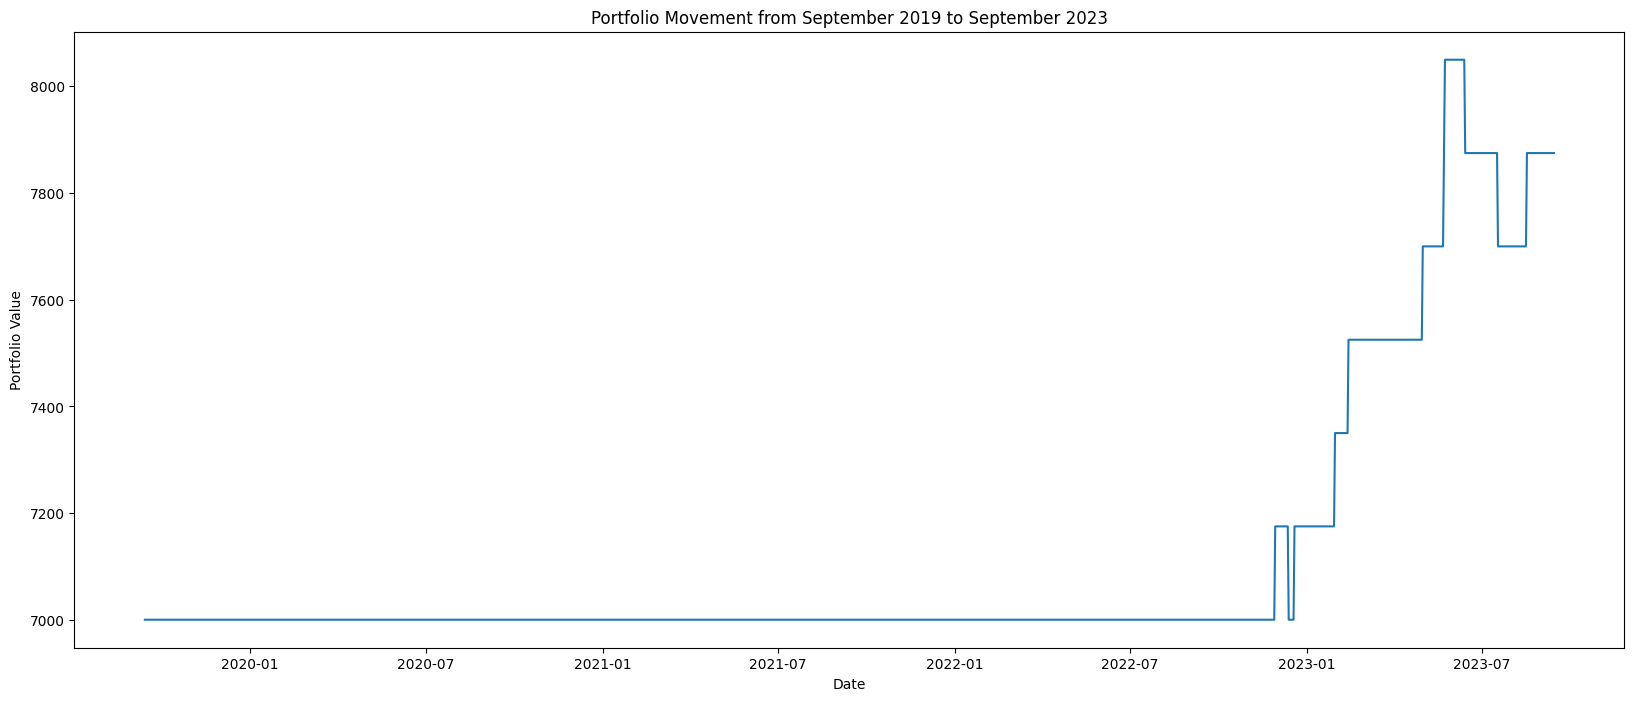

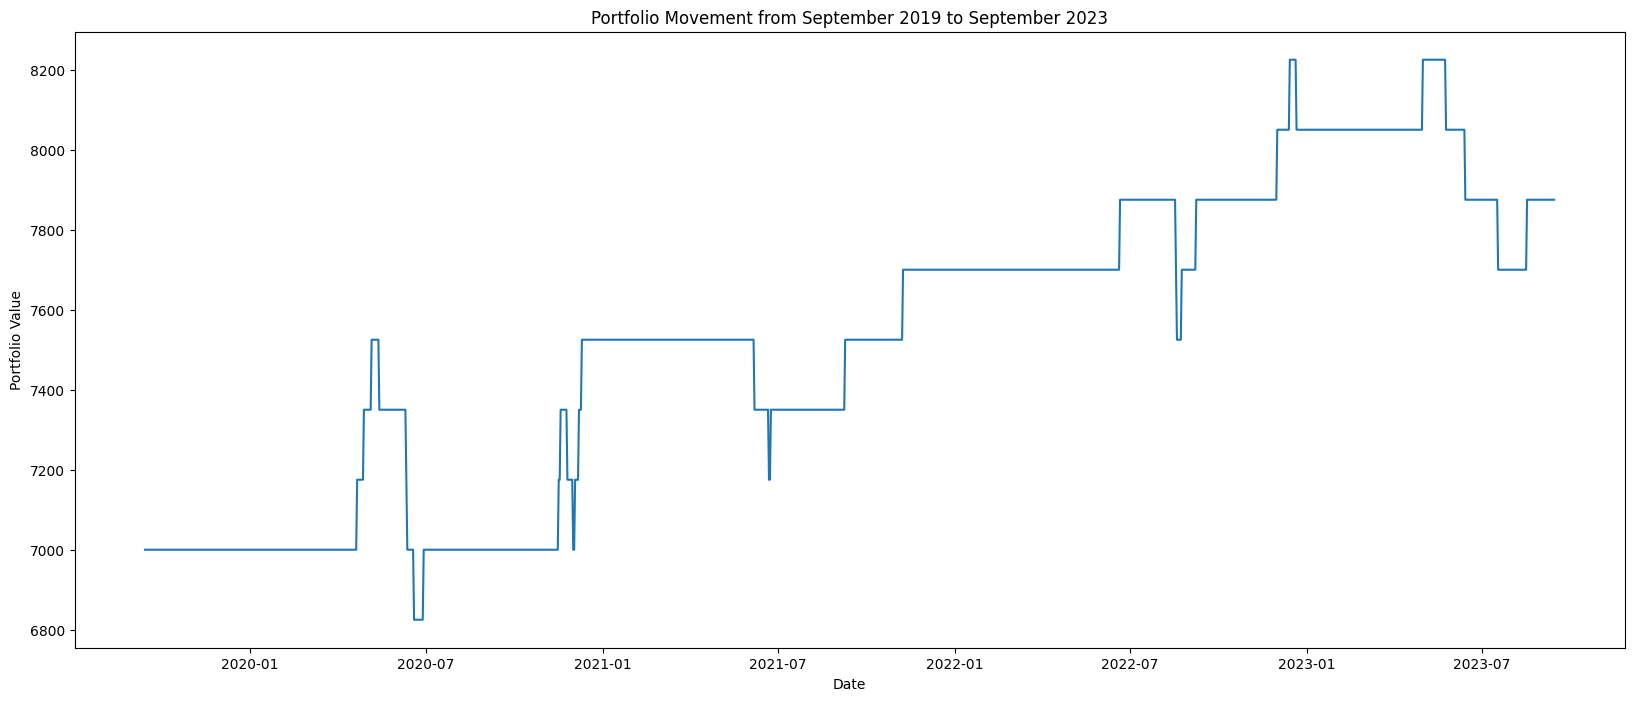

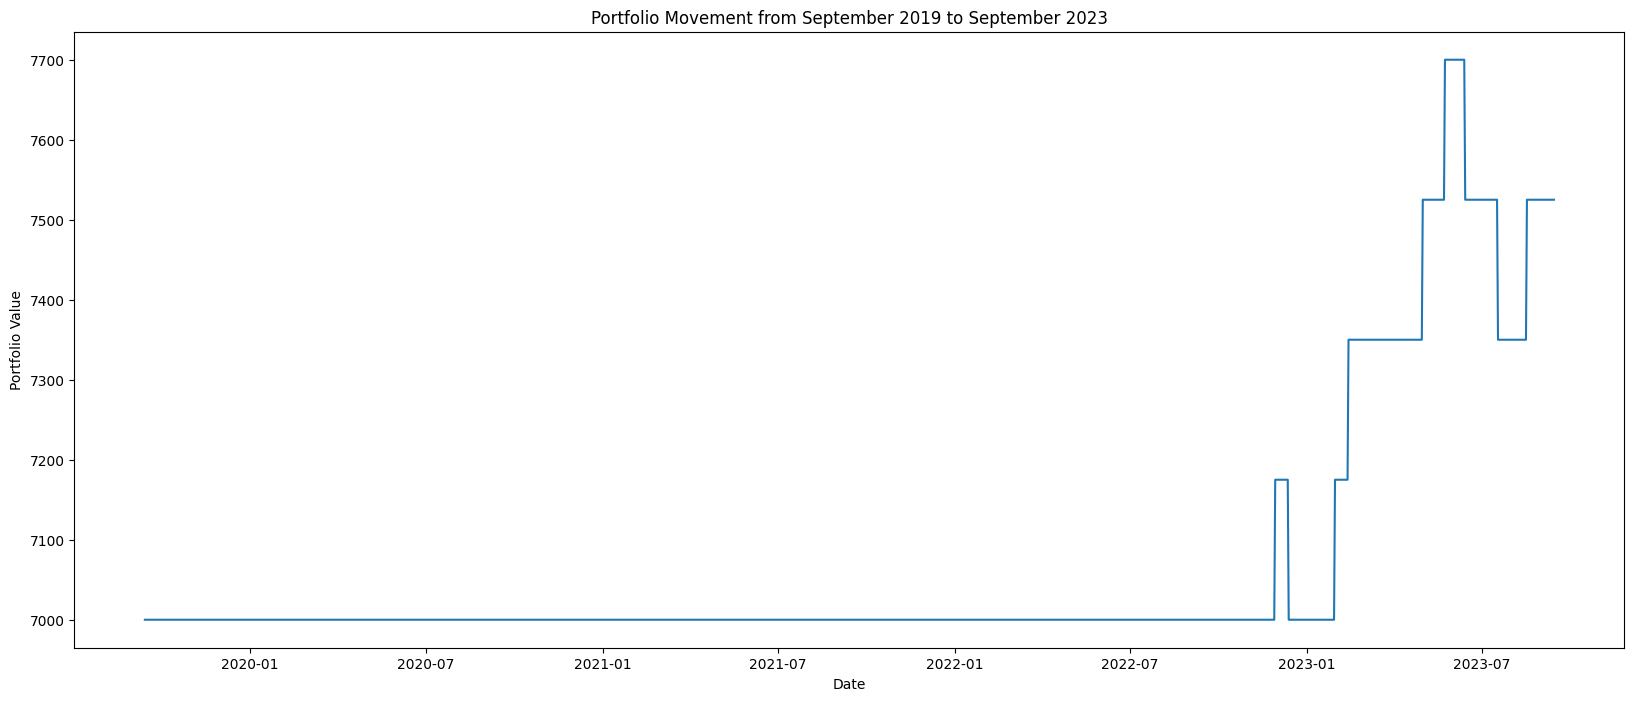

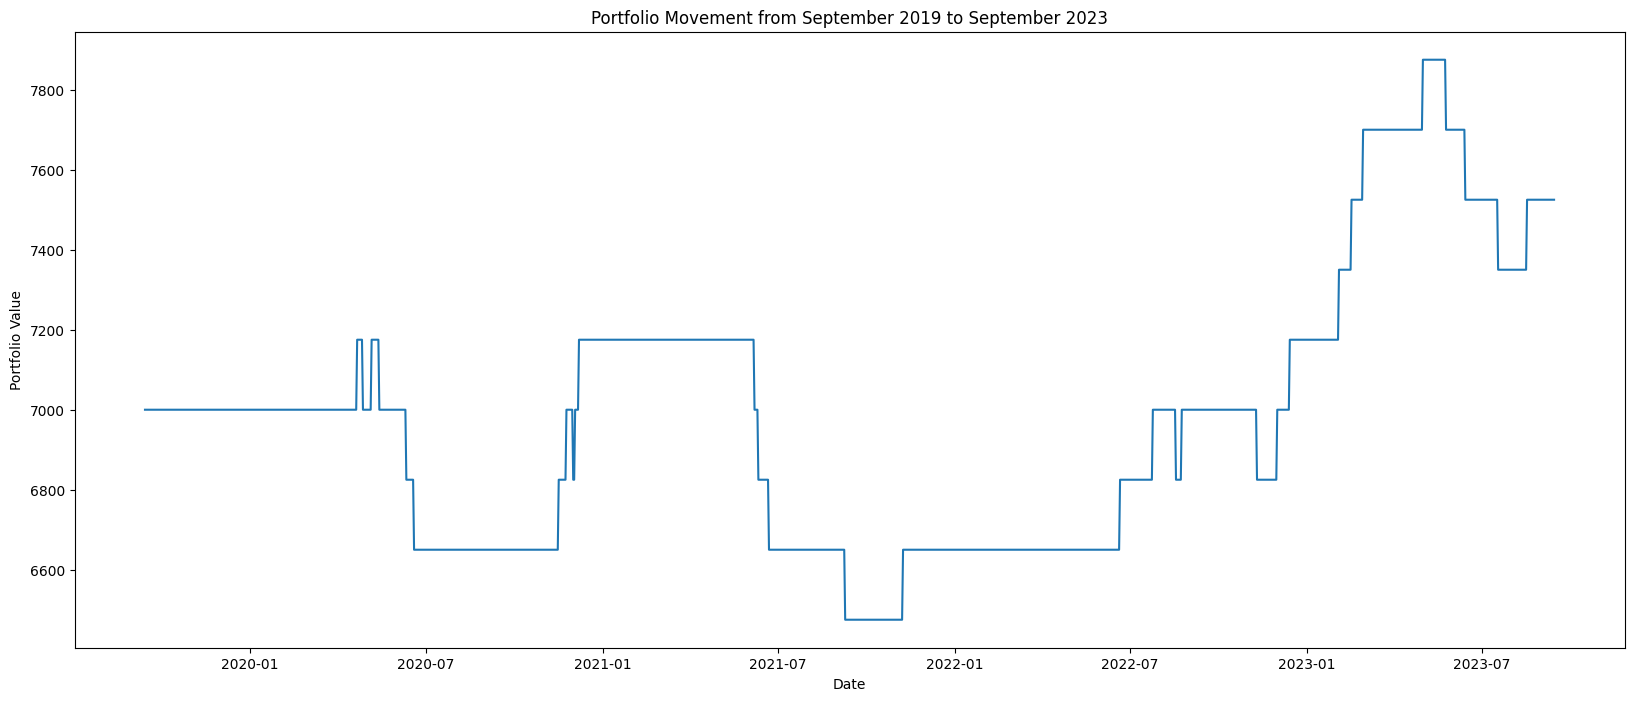

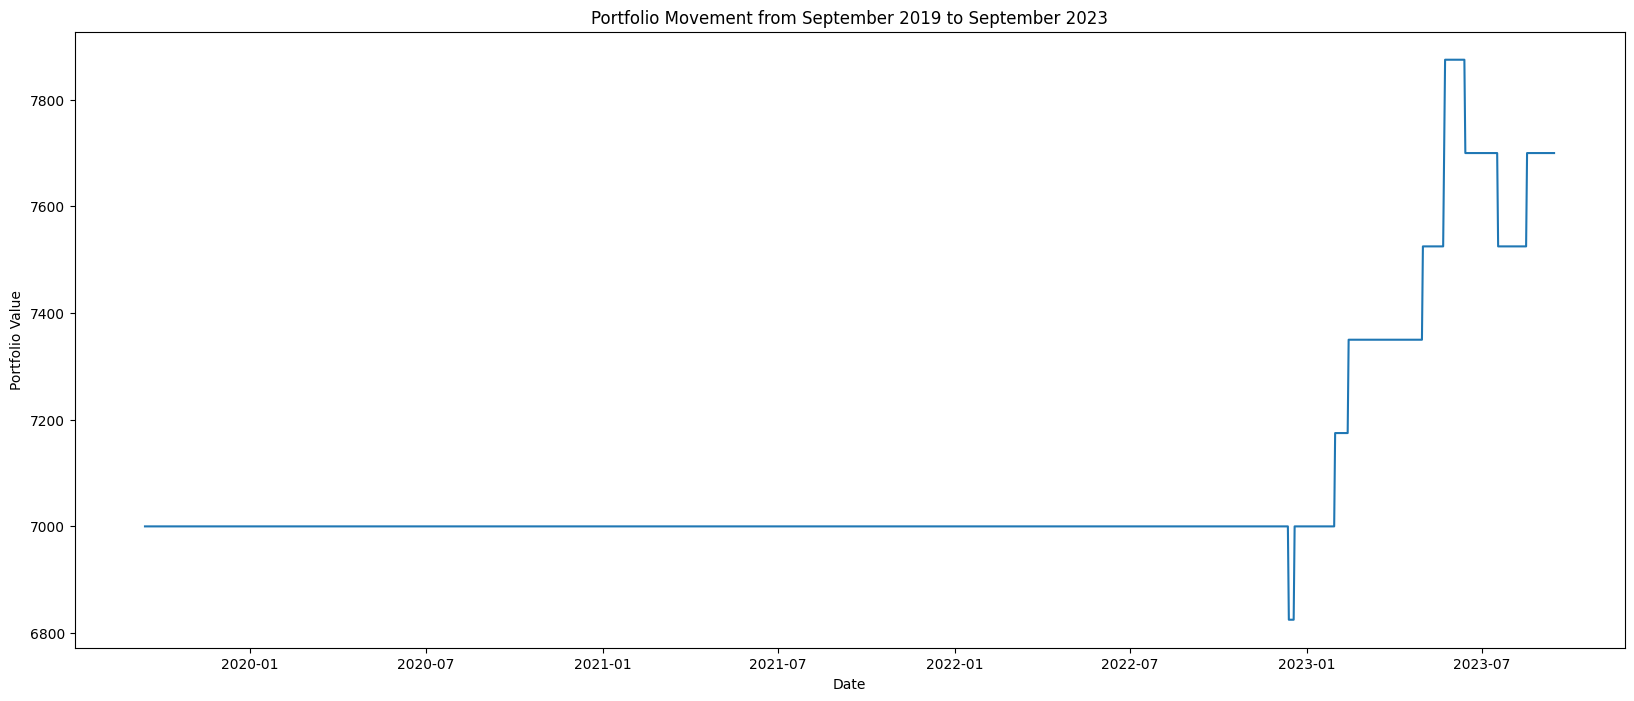

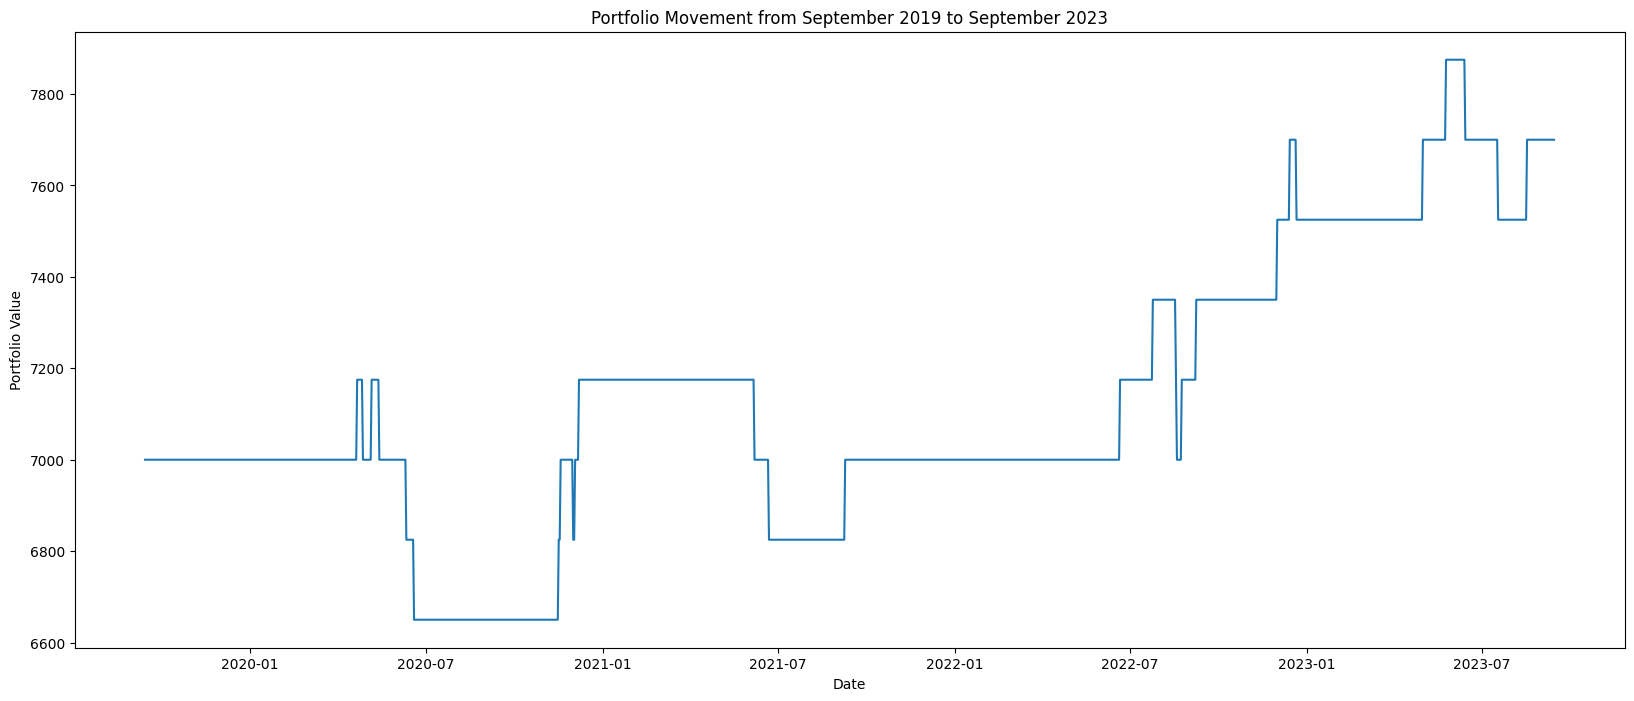

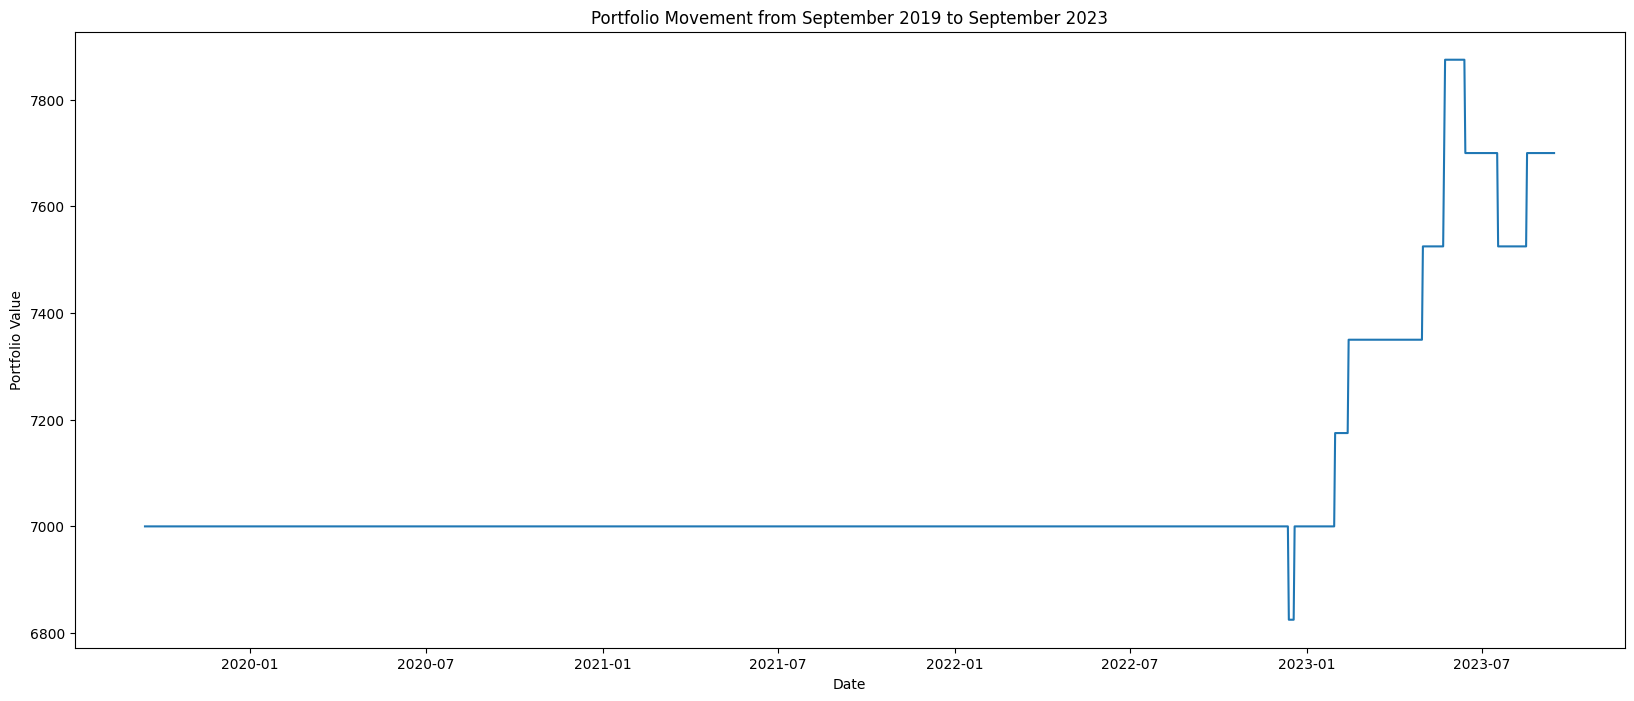

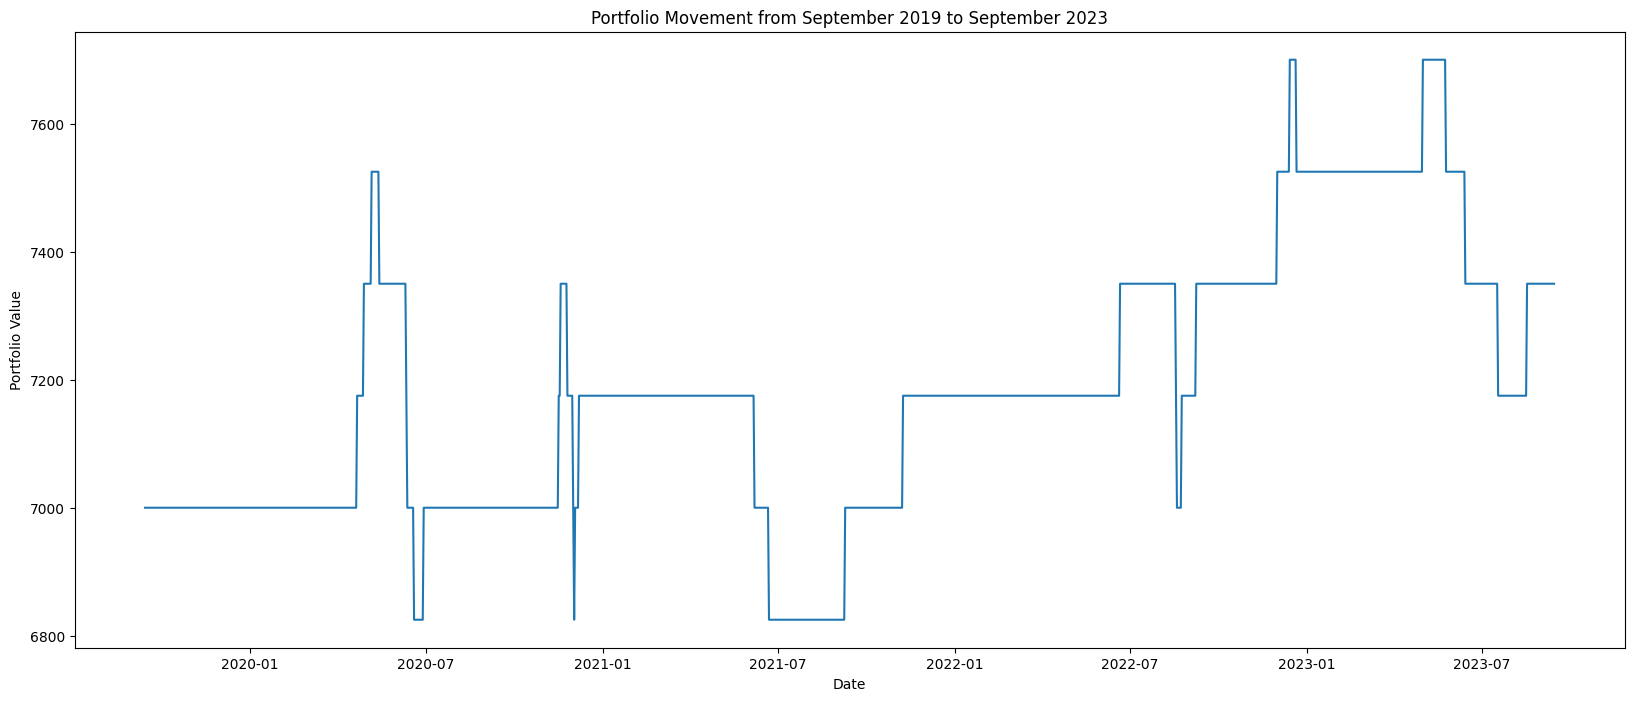

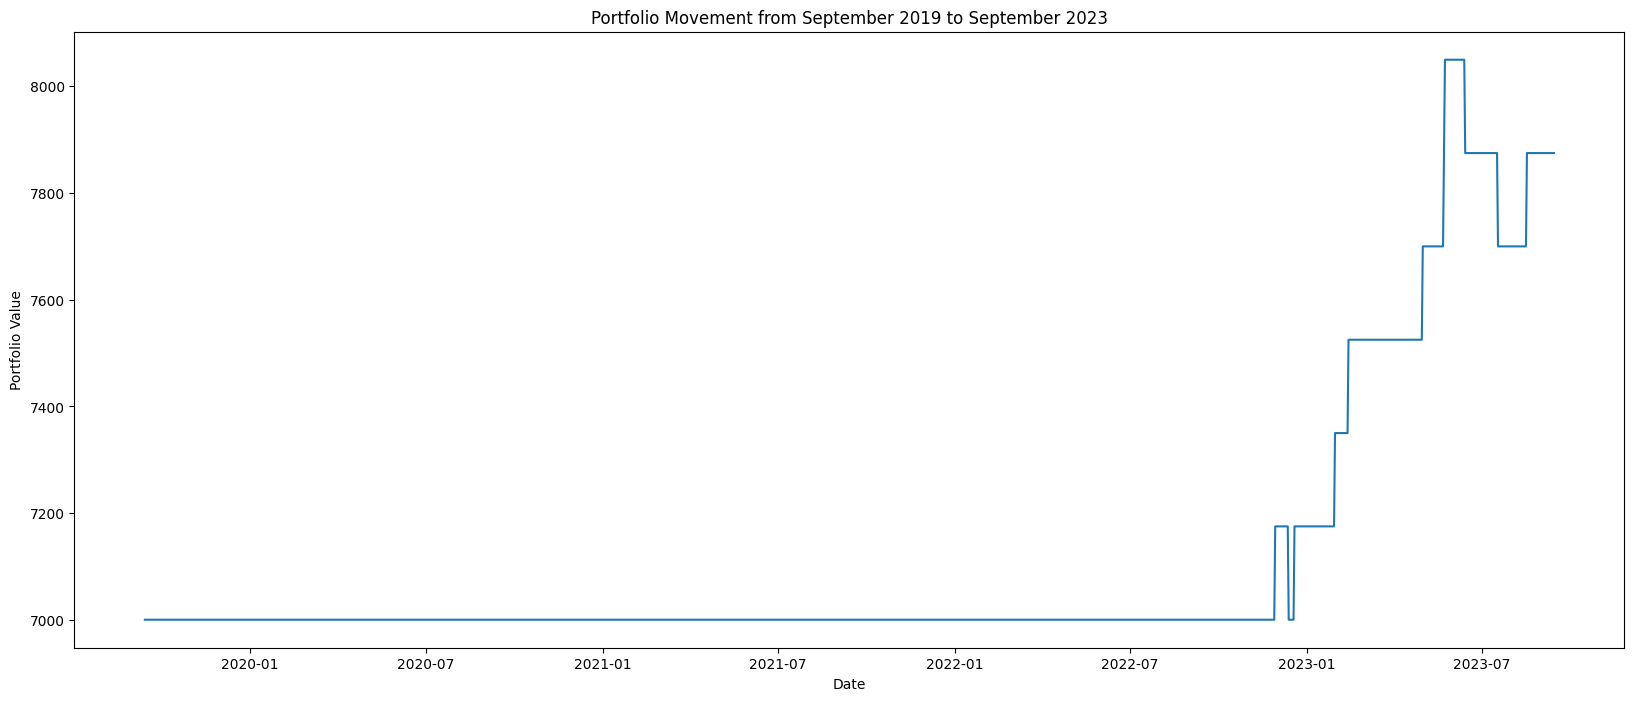

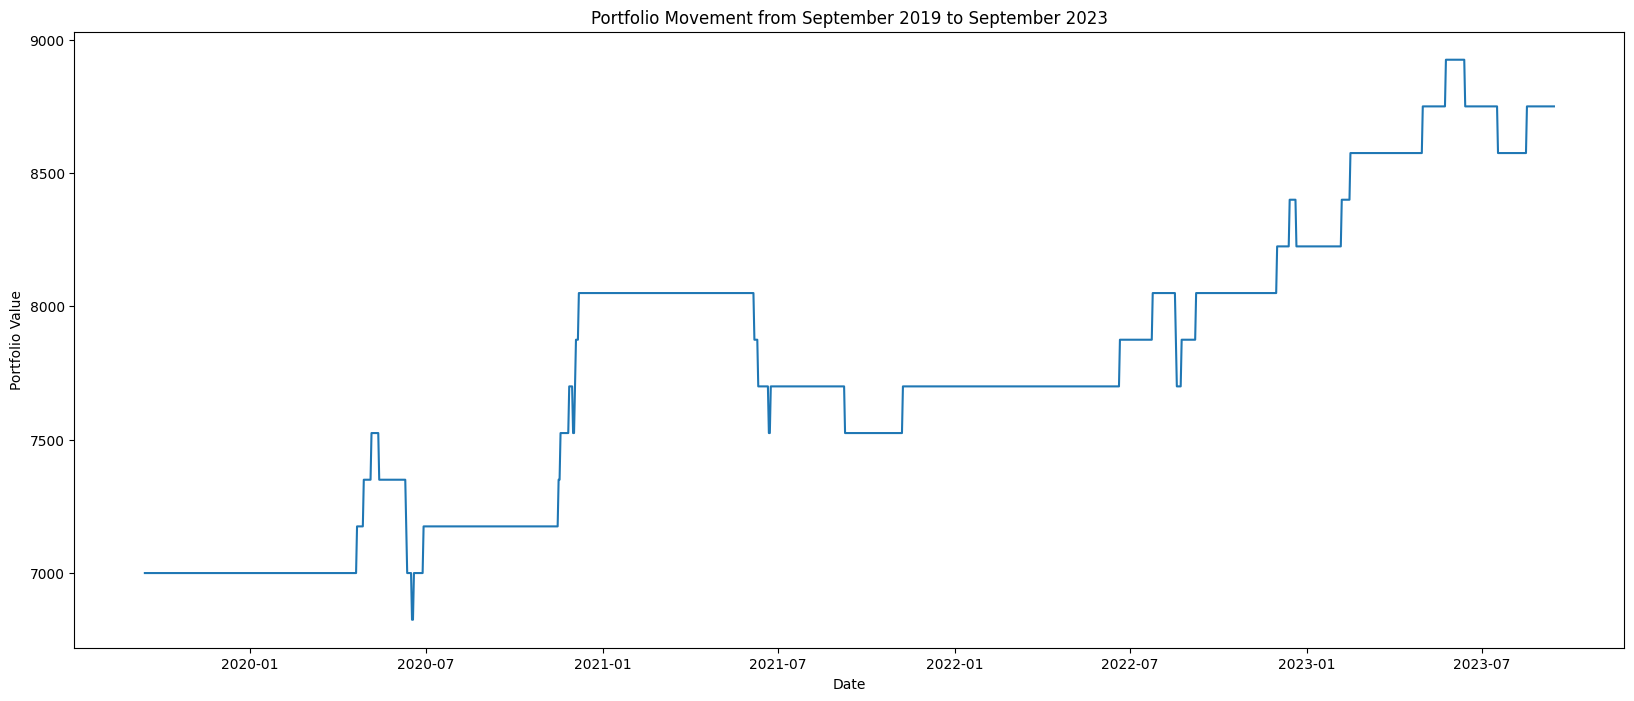

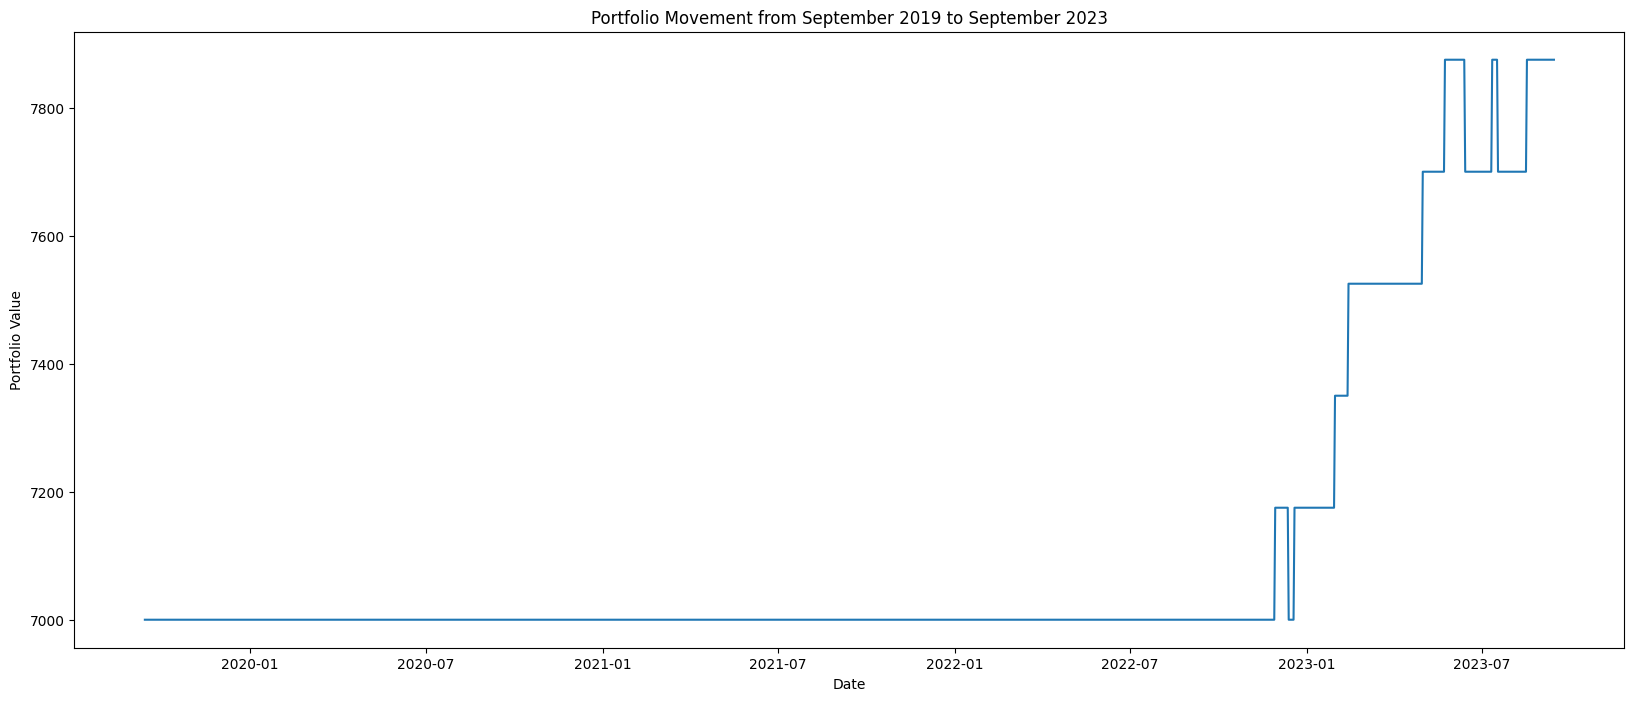

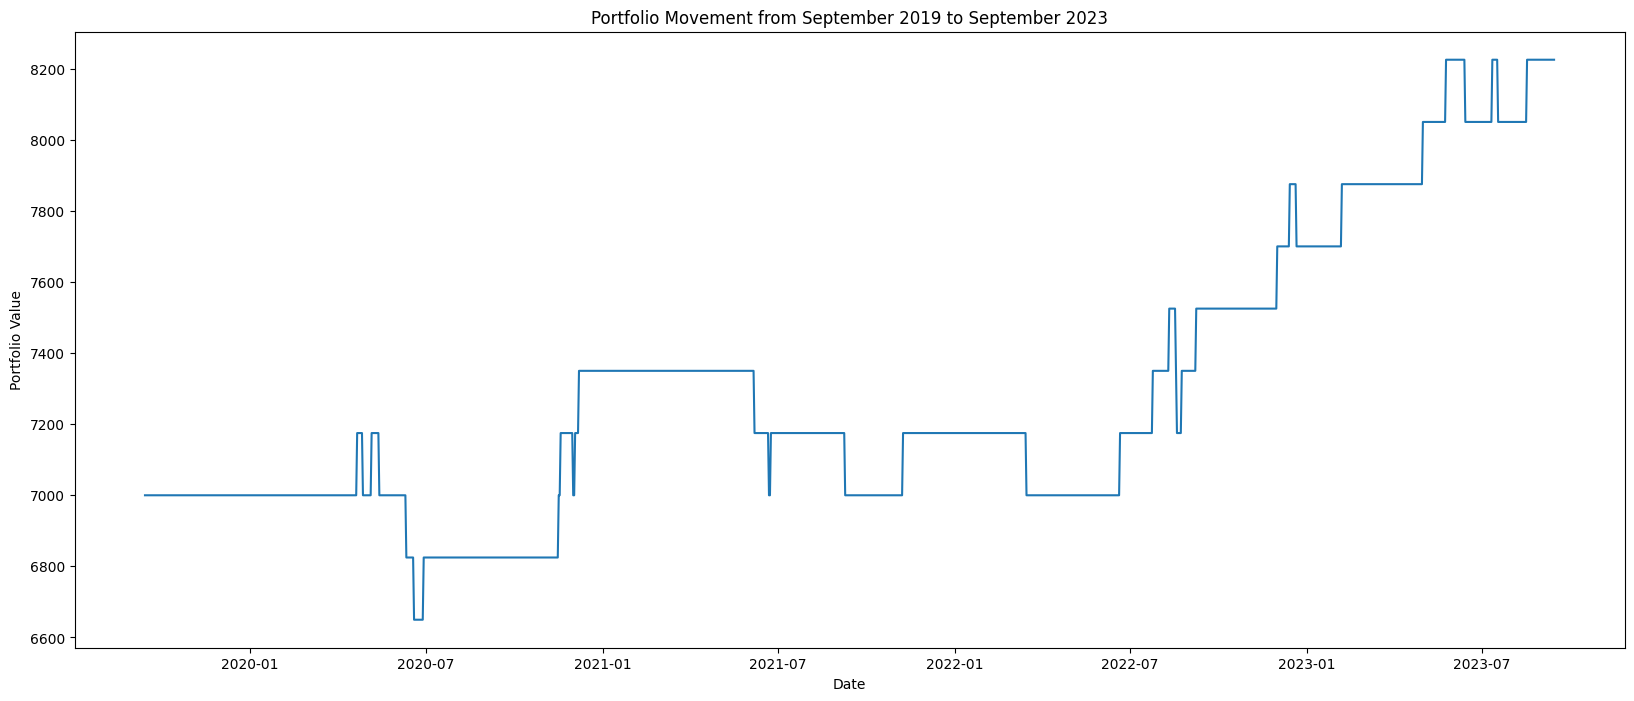

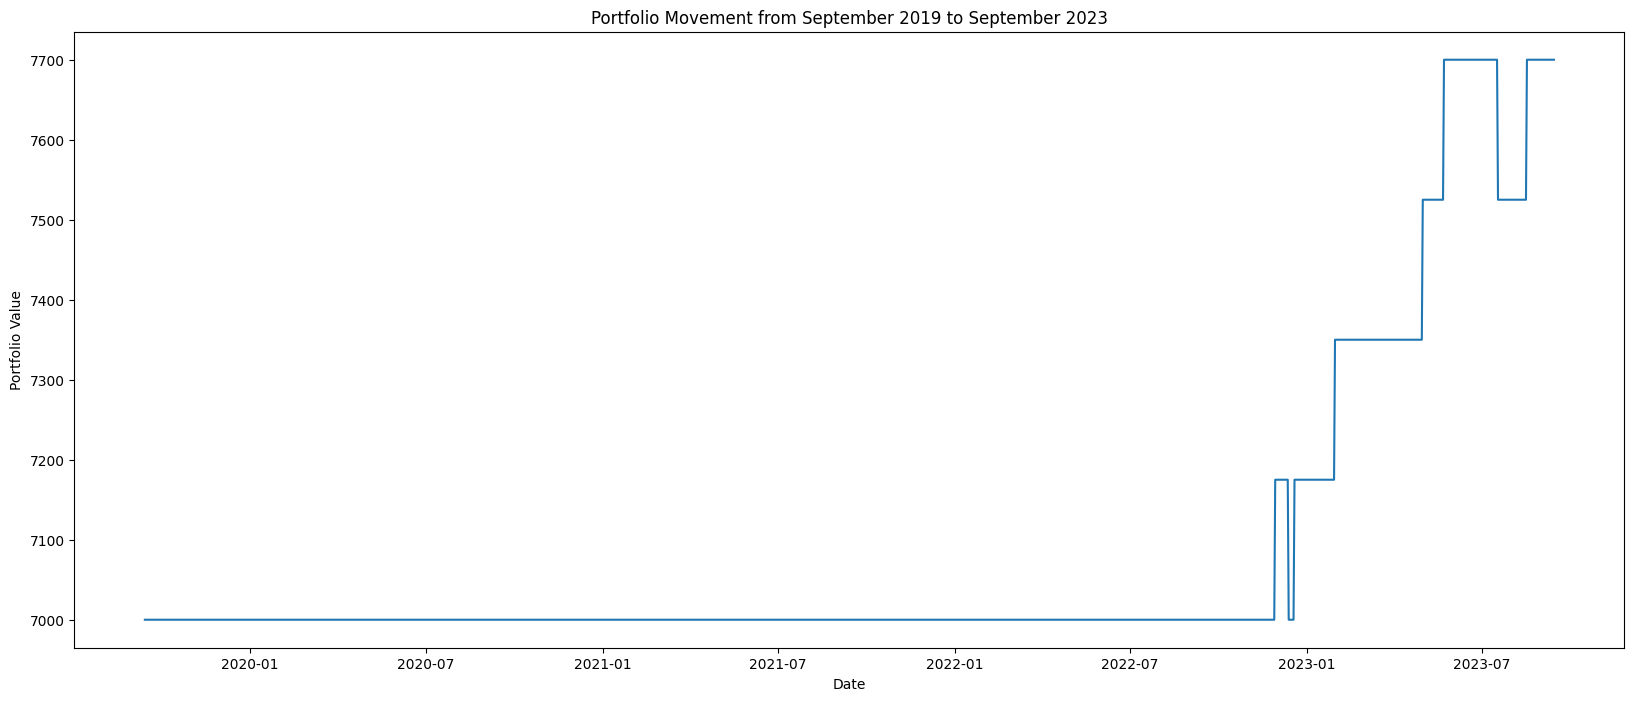

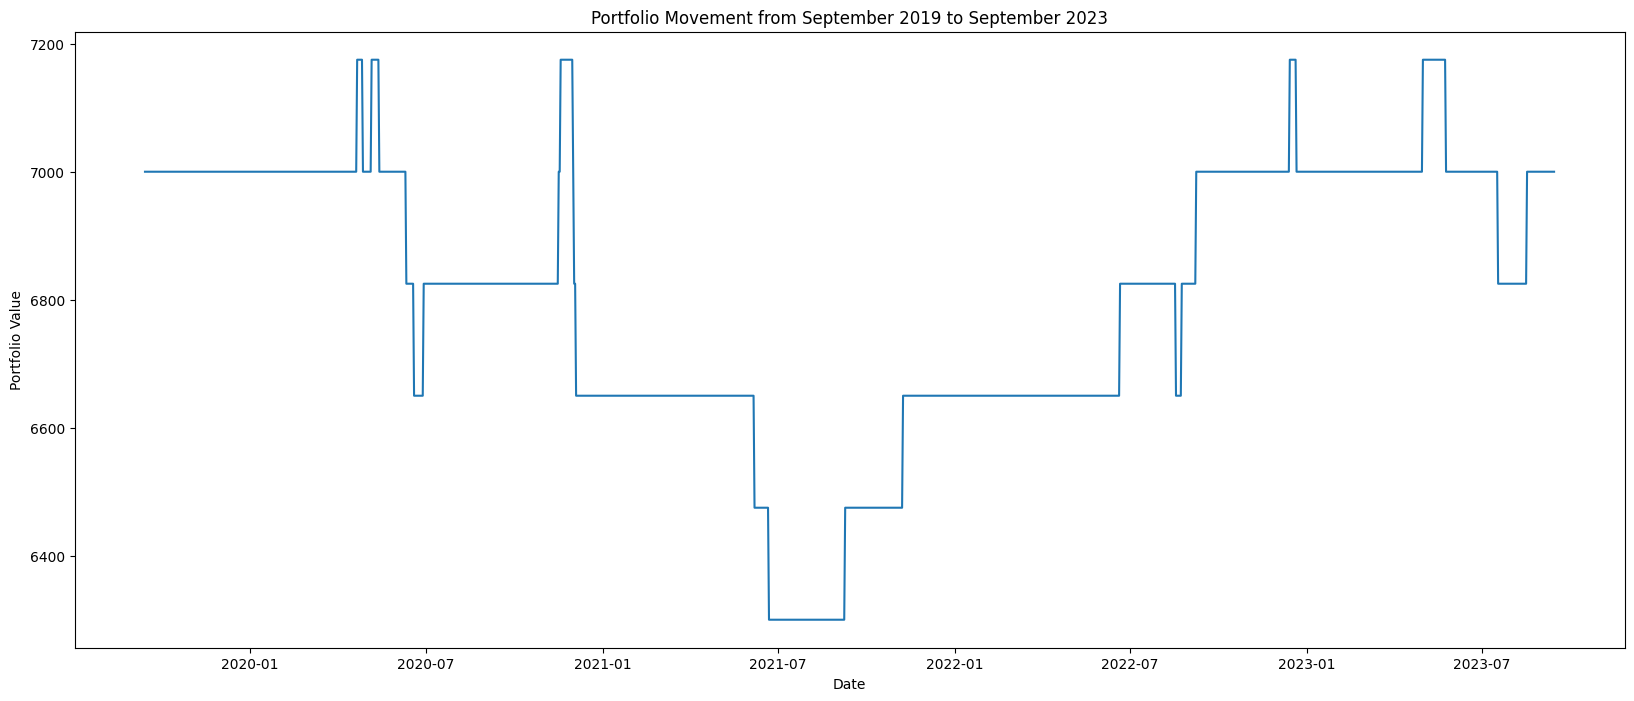

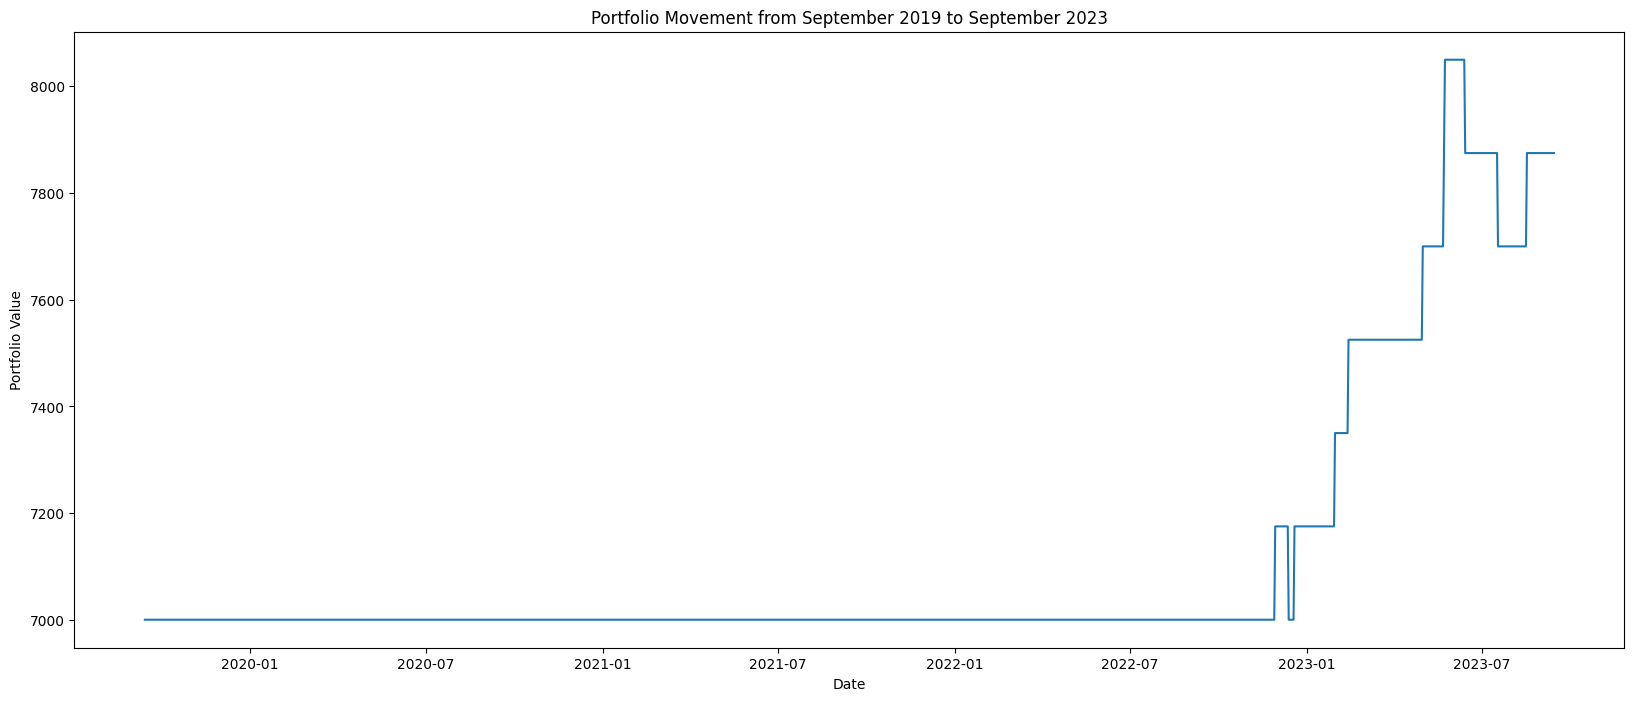

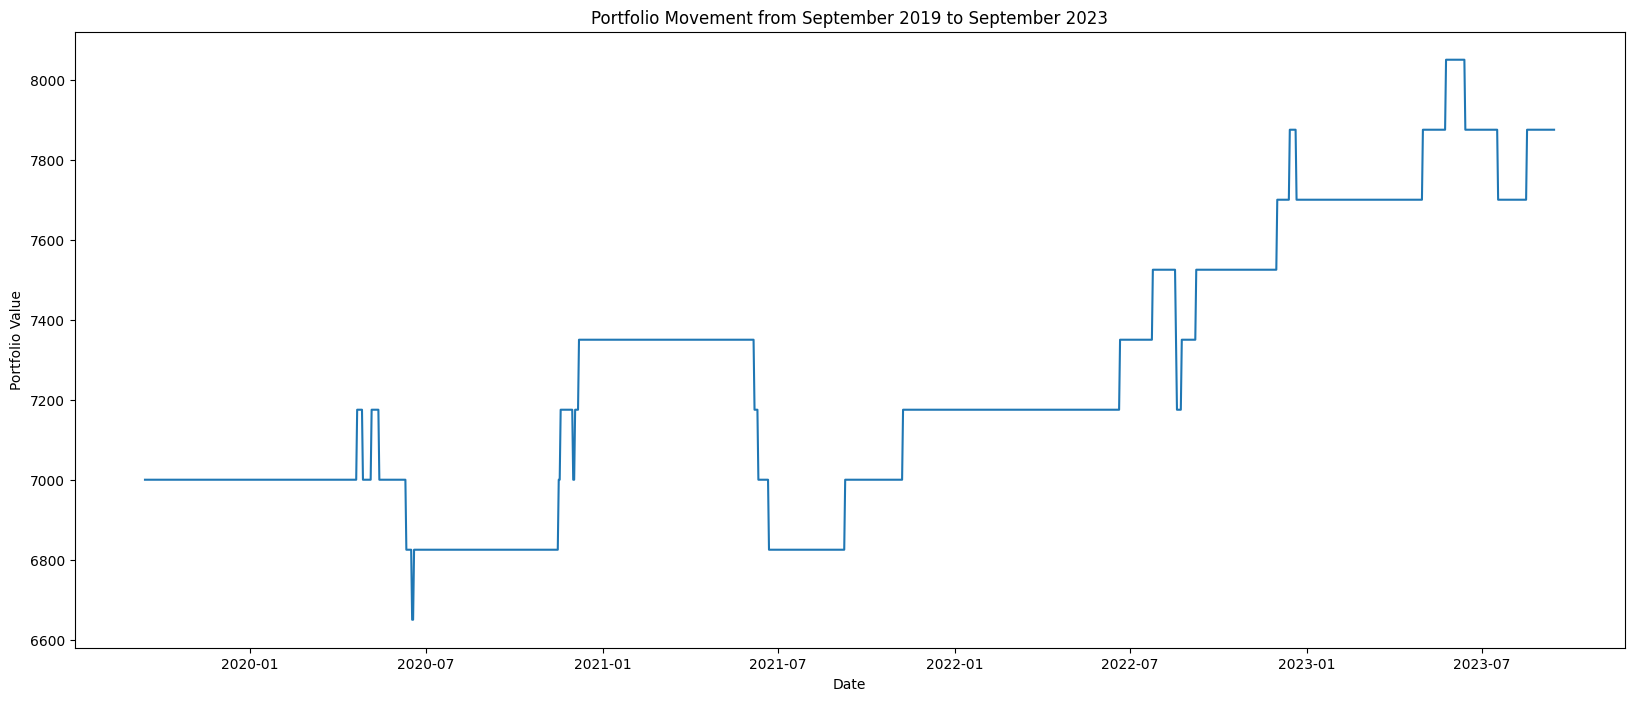

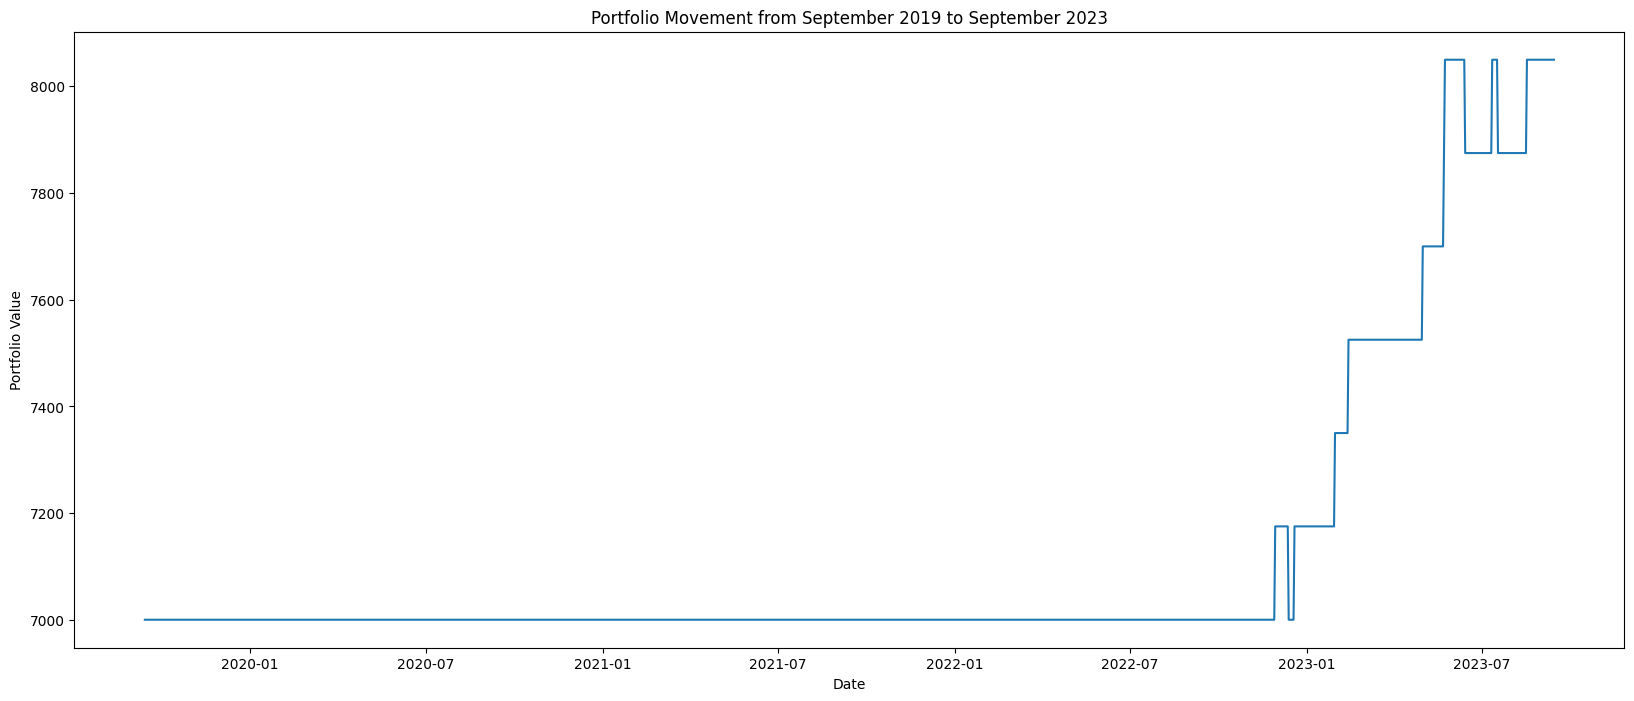

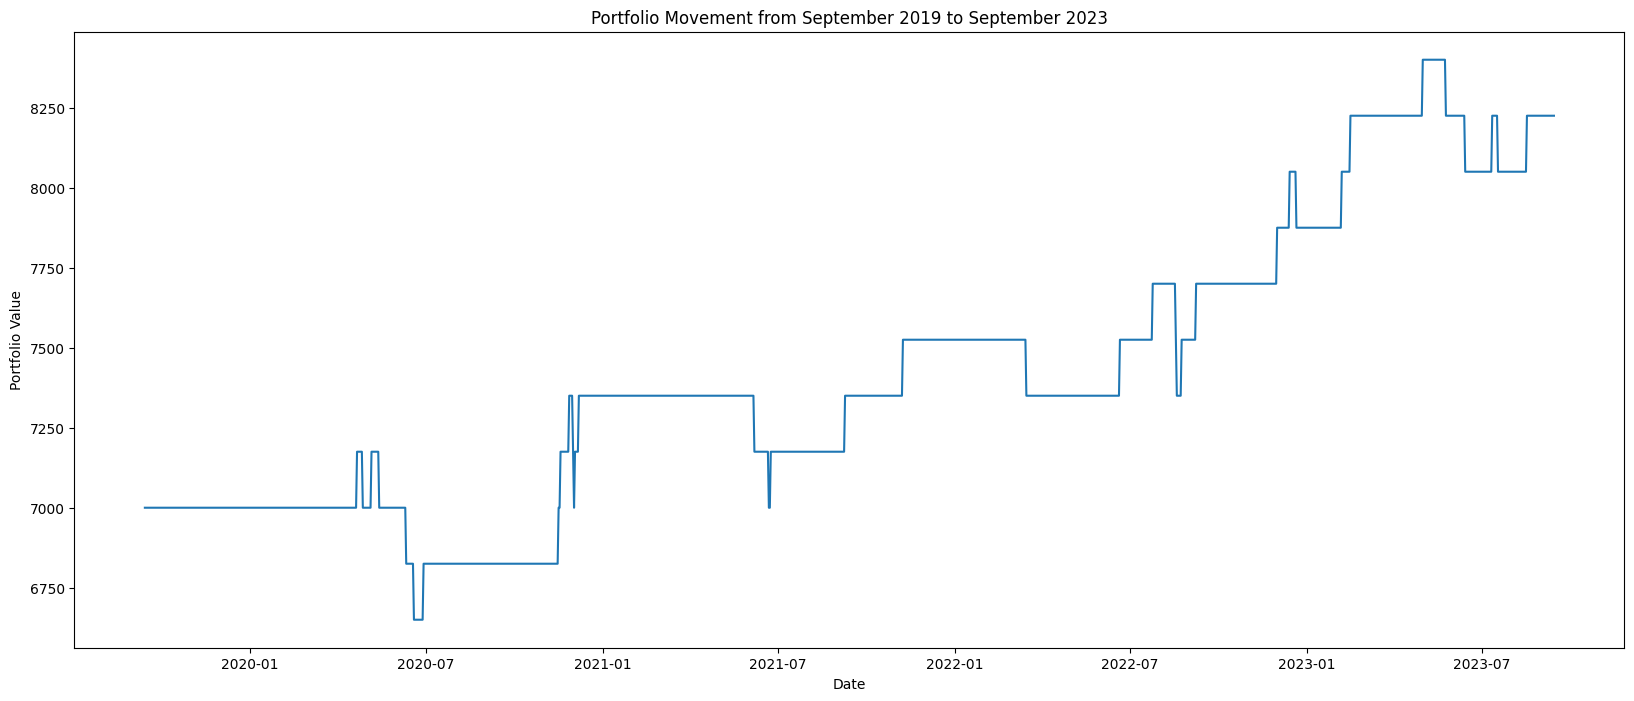

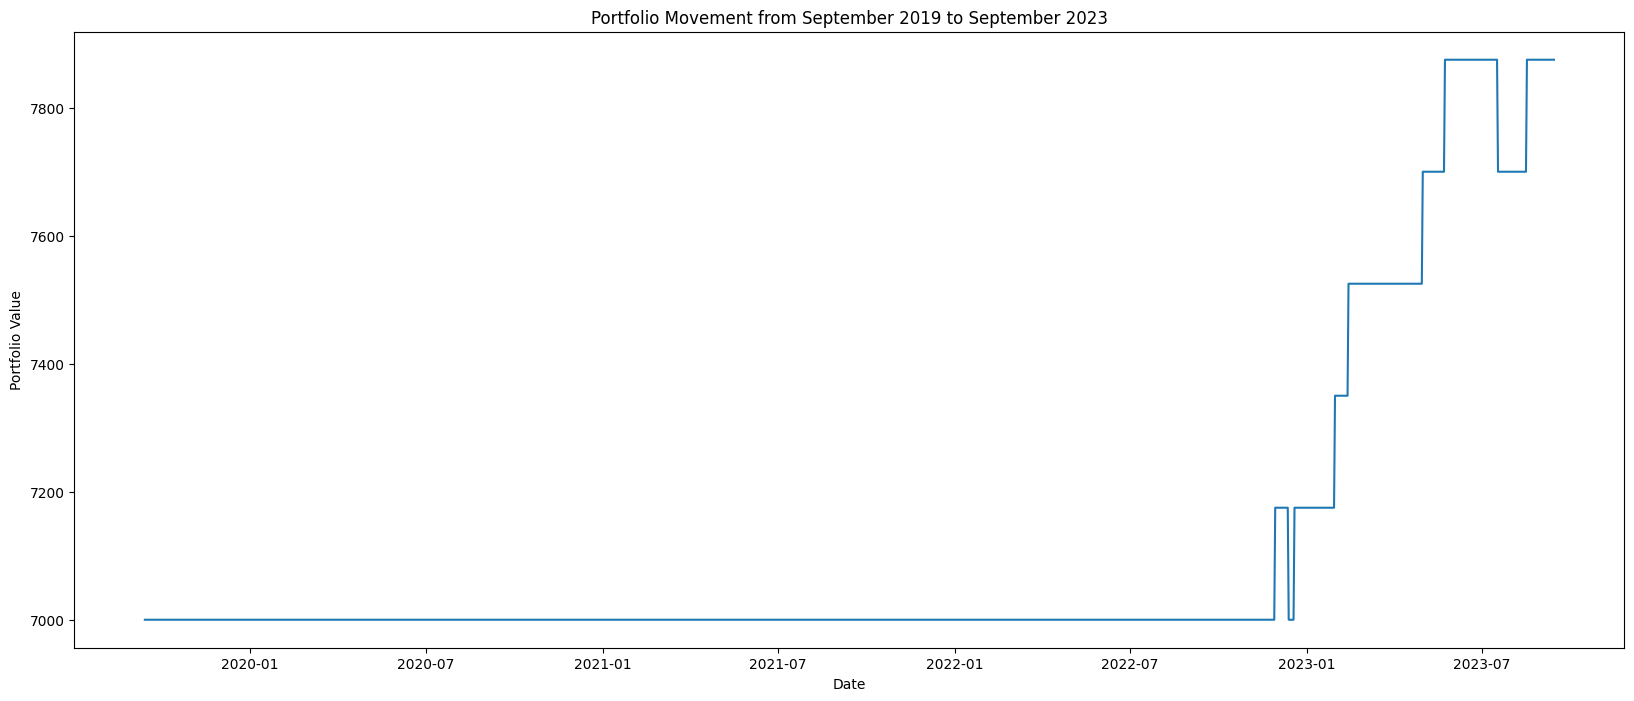

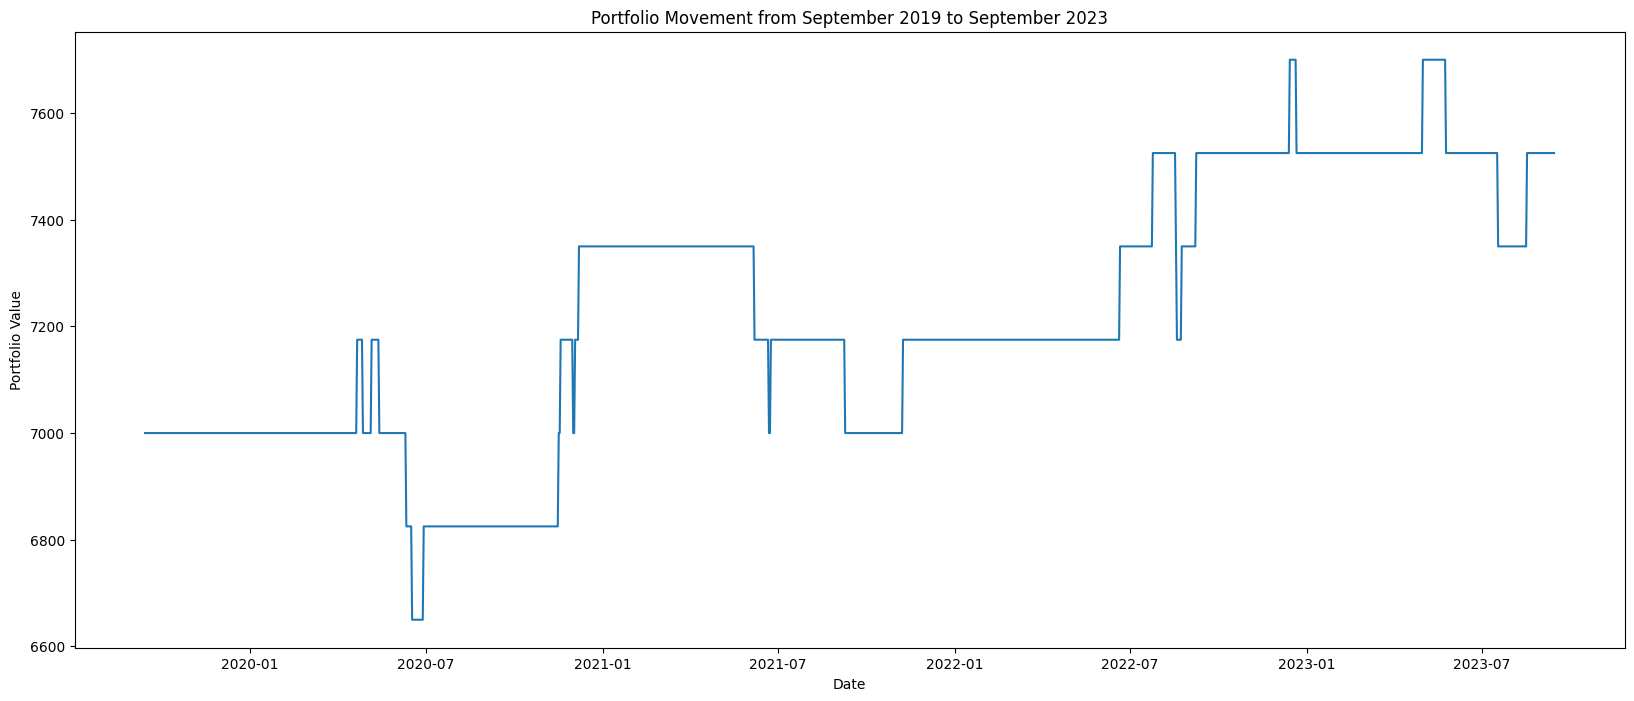

In [ ]:
mid = []
short = []

for i in range(30):
    model = train_model(common_long, large_window, small_window, window)
    short.append(create_trade_signals(common_short, window, 7000, 3500, model))
    mid.append(create_trade_signals(common_decade, window, 7000, 3500, model))

print(np.mean(short))
print(np.mean(mid))